(array([-1,  0,  1,  2,  3,  4,  5,  7,  8]), array([ 440, 1796,   15,  103,  427,  114,  363, 1054,   10]))
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7]), array([ 440, 1796, 1054,  427,  363,  114,  103,   15,   10]))
There are 719 H2 regions
Cluster -1: 73/439 signals (16.63%) belong to HII regions
Cluster 0: 301/1793 signals (16.79%) belong to HII regions
Cluster 1: 181/1052 signals (17.21%) belong to HII regions
Cluster 2: 64/427 signals (14.99%) belong to HII regions
Cluster 3: 53/362 signals (14.64%) belong to HII regions
Cluster 4: 18/114 signals (15.79%) belong to HII regions
Cluster 5: 21/103 signals (20.39%) belong to HII regions
Cluster 6: 1/15 signals (6.67%) belong to HII regions
Cluster 7: 7/10 signals (70.00%) belong to HII regions


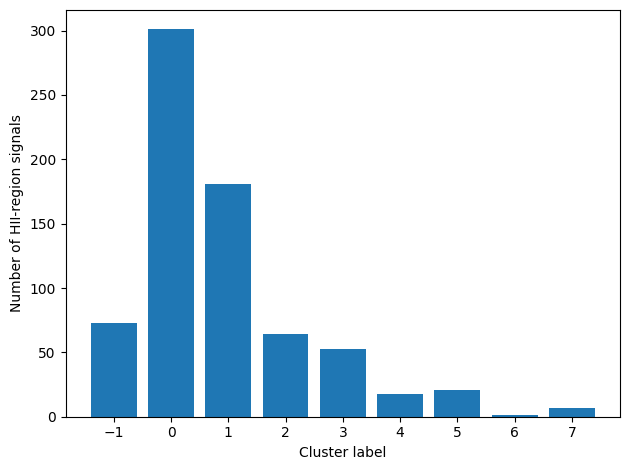

<ipython-input-1-c54f146ec9f4>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'] = ordered_labels


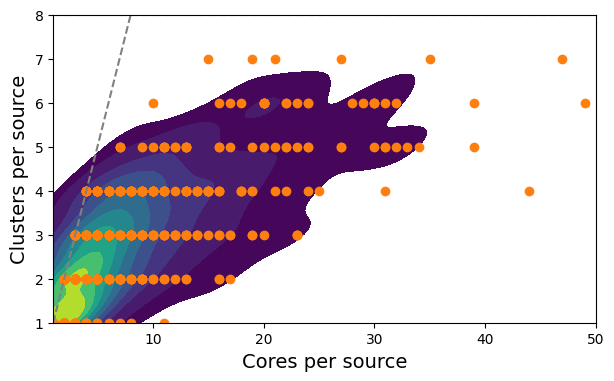

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from seaborn import kdeplot


mapping = np.load("Data/mapping.npy")
freq = np.load('Data/frequencies.npy')
subtraction_signals = np.load('Data/Processed/subtraction_signals.npy')
shifted_signals = np.load("Data/Processed/shifted_signals.npy")
shifted_residual = np.load("Data/Processed/shifted_residual.npy")

data_info = pd.read_csv('Data/data_info.csv')  # Provided
velocity_info = pd.read_csv('Data/velocity_info.csv')  # Calculated
velocity_info = velocity_info.dropna(subset=["Automatic velocity"]).reset_index(drop=True)

# Load and re-order labels such that largest cluster is cluster 0 and smalles is cluster -1
labels_10 = np.load("Data/Processed/labels10.npy")
print(np.unique(labels_10, return_counts=True))

labels_10_mask = labels_10 != -1  # Mask for clustered signals
ordered_labels = labels_10.copy()

unique_labels, sizes = np.unique(labels_10[labels_10_mask], return_counts=True)
for i, label in enumerate(unique_labels[np.argsort(sizes)[::-1]]):
    ordered_labels[labels_10 == label] = i

print(np.unique(ordered_labels, return_counts=True))

# Match data from tables to data from available sources
idx = []
labels = []
sc_pair = []

# Filter data from data_info not in velocity_info
for i in range(len(data_info)):
    source = data_info['CLUMP'].iloc[i]
    core = data_info['ID'].iloc[i]
    
    index = velocity_info[(velocity_info['Source'] == source) & (velocity_info['Core'] == core)].index.to_list()
    if len(index) > 0:
        idx.append(index[0])
        labels.append(labels_10[index[0]])
        
        sc_pair.append((source, core))

df = data_info.iloc[idx]

# Filter data from velocity_info not in data_info
idx = []
for i in range(len(velocity_info)):
    source = velocity_info["Source"].iloc[i]
    core = velocity_info["Core"].iloc[i]
    
    if (source, core) in sc_pair:
        idx.append(i)

velocity_info = velocity_info.iloc[idx]
ordered_labels = ordered_labels[idx]

# Delete data from H_II regions
h2_mask = df['RADIO_MATCH'] == 1

print(f"There are {sum(h2_mask)} H2 regions")

clusters_10_h2, count_10_h2 = np.unique(ordered_labels[h2_mask], return_counts=True)
for i in range(len(clusters_10_h2)):
    print(f"Cluster {clusters_10_h2[i]}: {count_10_h2[i]}/{sum(ordered_labels == clusters_10_h2[i])} signals ({count_10_h2[i]/sum(ordered_labels == clusters_10_h2[i]) * 100:.2f}%) belong to HII regions")

plt.bar(clusters_10_h2, count_10_h2)
plt.xticks(ticks=np.unique(ordered_labels))
plt.xlabel("Cluster label")
plt.ylabel("Number of HII-region signals")
plt.tight_layout()
plt.show()

variables = ['DIST', 'Lclump', 'Mclump', 'Tclump', 'n(H2)', 'Dcore', 'Lclump/Mclump', 'Surfd_nd']

# Add label column
df['Label'] = ordered_labels

cores_per_source = np.array([len(df['ID'][df['CLUMP'] == source].unique()) for source in df['CLUMP'].unique()])
n_cores_per_source, instances_core = np.unique(cores_per_source, return_counts=True)

clusters_per_source = np.array([len(df['Label'][df['CLUMP'] == source].unique()) for source in df['CLUMP'].unique()])
n_clusters_per_source, instances_clusters = np.unique(clusters_per_source, return_counts=True)

fig, ax = plt.subplots(figsize=(7, 4))
kdeplot(x=cores_per_source, y=clusters_per_source, fill=True, cmap="viridis", clip=[(1, 50), (1, 8)], ax=ax)
ax.scatter(cores_per_source, clusters_per_source)
ax.plot([1, len(np.unique(ordered_labels)) - 1], [1, len(np.unique(ordered_labels)) - 1], linestyle='--', color='grey')
plt.axhline(len(np.unique(ordered_labels)) - 1, linestyle='--', color='grey')
plt.xlabel('Cores per source', fontsize=14)
plt.ylabel('Clusters per source', fontsize=14)
plt.savefig('results/analysis/cores_and_clusters_label10.pdf')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
kdeplot(x=cores_per_source, y=clusters_per_source, fill=True, cmap="viridis", clip=[(1, 50), (1, 8)], ax=ax)
ax.scatter(cores_per_source, clusters_per_source)
ax.plot([1, len(np.unique(ordered_labels)) - 1], [1, len(np.unique(ordered_labels)) - 1], linestyle='--', color='lightgrey')
plt.axhline(len(np.unique(ordered_labels)) - 1, linestyle='--', color='lightgrey')
plt.xlabel('Cores per source', fontsize=14)
plt.ylabel('Clusters per source', fontsize=14)
plt.savefig('results/analysis/cores_and_clusters_label10.pdf')
plt.show()



In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
kdeplot(x=cores_per_source, y=clusters_per_source, fill=False, cmap="viridis", clip=[(1, 50), (1, 8)], ax=ax)
ax.scatter(cores_per_source, clusters_per_source)
ax.plot([1, len(np.unique(ordered_labels)) - 1], [1, len(np.unique(ordered_labels)) - 1], linestyle='--', color='lightgrey', width=5)
plt.xlabel('Cores per source', fontsize=14)
plt.ylabel('Clusters per source', fontsize=14)
plt.savefig('results/analysis/cores_and_clusters_label10.pdf')
plt.show()

AttributeError: Line2D.set() got an unexpected keyword argument 'width'

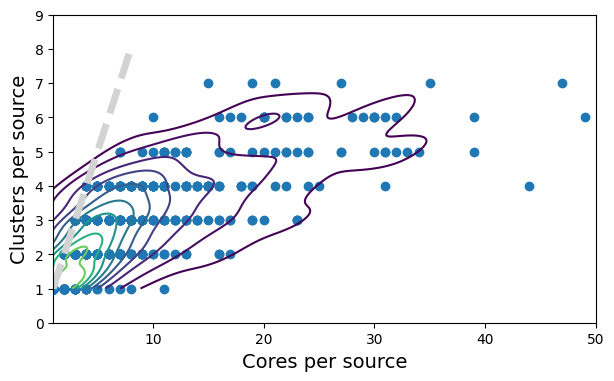

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
kdeplot(x=cores_per_source, y=clusters_per_source, fill=False, cmap="viridis", clip=[(1, 50), (1, 8)], ax=ax)
ax.scatter(cores_per_source, clusters_per_source)
ax.plot([1, len(np.unique(ordered_labels)) - 1], [1, len(np.unique(ordered_labels)) - 1], linestyle='--', color='lightgrey', linewidth=5)
plt.ylim((0, 9))
plt.xlabel('Cores per source', fontsize=14)
plt.ylabel('Clusters per source', fontsize=14)
plt.savefig('results/analysis/cores_and_clusters_label10.pdf')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
kdeplot(x=cores_per_source, y=clusters_per_source, fill=False, cmap="viridis", clip=[(1, 50), (1, 8)], ax=ax)
ax.scatter(cores_per_source, clusters_per_source)
ax.plot([1, len(np.unique(ordered_labels)) - 1], [1, len(np.unique(ordered_labels)) - 1], linestyle='--', color='black', linewidth=3)
plt.ylim((0, 8))
plt.xlabel('Cores per source', fontsize=14)
plt.ylabel('Clusters per source', fontsize=14)
plt.savefig('results/analysis/cores_and_clusters_label10.pdf')
plt.show()

In [ ]:
clusters_per_source = np.array([len(df['Label'][df['CLUMP'] == source].unique()) for source in df['CLUMP'].unique()])
for i, source in enumerate(df["CLUMP"].unique()):
    if -1 in df['Label'][df['CLUMP'] == source]:
        clusters_per_source[i] -= 1
n_clusters_per_source, instances_clusters = np.unique(clusters_per_source, return_counts=True)

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
kdeplot(x=cores_per_source, y=clusters_per_source, fill=False, cmap="viridis", clip=[(1, 50), (1, 8)], ax=ax)
ax.scatter(cores_per_source, clusters_per_source)
ax.plot([1, len(np.unique(ordered_labels)) - 1], [1, len(np.unique(ordered_labels)) - 1], linestyle='--', color='black', linewidth=3)
plt.ylim((0, 8))
plt.xlabel('Cores per source', fontsize=14)
plt.ylabel('Clusters per source', fontsize=14)
plt.savefig('results/analysis/cores_and_clusters_label10.pdf')
plt.show()

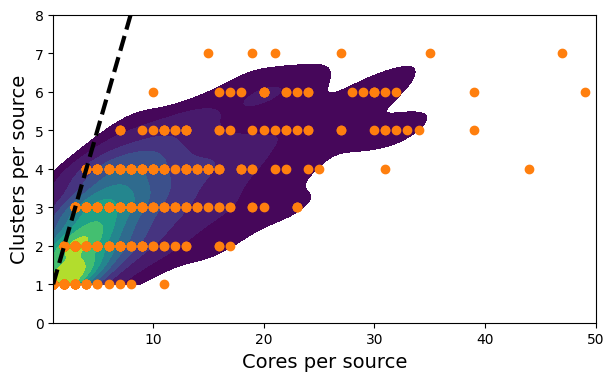

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
kdeplot(x=cores_per_source, y=clusters_per_source, fill=True, cmap="viridis", clip=[(1, 50), (1, 8)], ax=ax, gridsize=1000)
ax.scatter(cores_per_source, clusters_per_source)
ax.plot([1, len(np.unique(ordered_labels)) - 1], [1, len(np.unique(ordered_labels)) - 1], linestyle='--', color='black', linewidth=3)
plt.ylim((0, 8))
plt.xlabel('Cores per source', fontsize=14)
plt.ylabel('Clusters per source', fontsize=14)
plt.savefig('results/analysis/cores_and_clusters_label10.pdf')
plt.show()

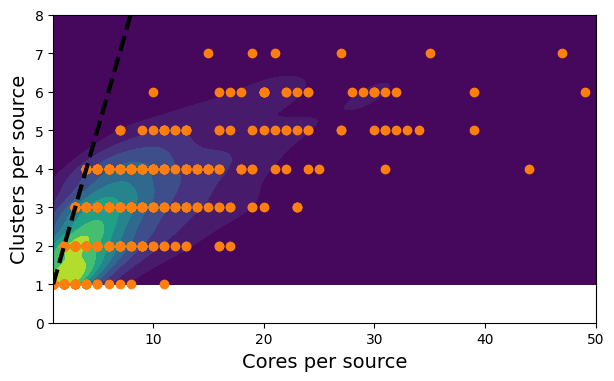

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
kdeplot(x=cores_per_source, y=clusters_per_source, fill=True, cmap="viridis", clip=[(1, 50), (1, 8)], ax=ax, thresh=0)
ax.scatter(cores_per_source, clusters_per_source)
ax.plot([1, len(np.unique(ordered_labels)) - 1], [1, len(np.unique(ordered_labels)) - 1], linestyle='--', color='black', linewidth=3)
plt.ylim((0, 8))
plt.xlabel('Cores per source', fontsize=14)
plt.ylabel('Clusters per source', fontsize=14)
plt.savefig('results/analysis/cores_and_clusters_label10.pdf')
plt.show()

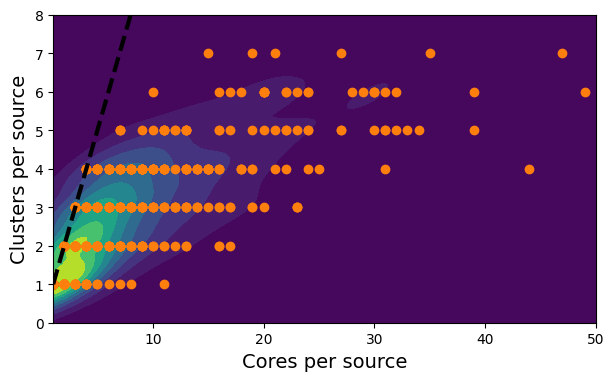

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
kdeplot(x=cores_per_source, y=clusters_per_source, fill=True, cmap="viridis", clip=[(1, 50), (0, 8)], ax=ax, thresh=0)
ax.scatter(cores_per_source, clusters_per_source)
ax.plot([1, len(np.unique(ordered_labels)) - 1], [1, len(np.unique(ordered_labels)) - 1], linestyle='--', color='black', linewidth=3)
plt.ylim((0, 8))
plt.xlabel('Cores per source', fontsize=14)
plt.ylabel('Clusters per source', fontsize=14)
plt.savefig('results/analysis/cores_and_clusters_label10.pdf')
plt.show()

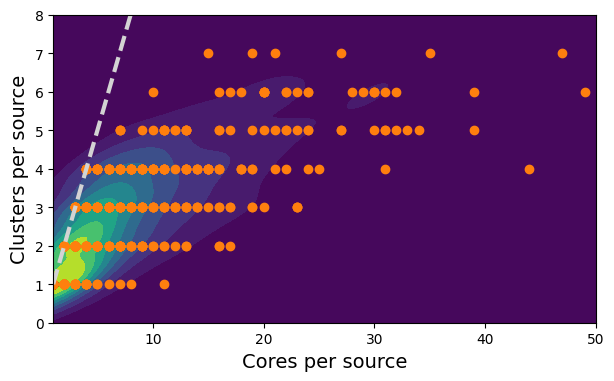

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
kdeplot(x=cores_per_source, y=clusters_per_source, fill=True, cmap="viridis", clip=[(1, 50), (0, 8)], ax=ax, thresh=0)
ax.scatter(cores_per_source, clusters_per_source)
ax.plot([1, len(np.unique(ordered_labels)) - 1], [1, len(np.unique(ordered_labels)) - 1], linestyle='--', color='lightgrey', linewidth=3)
plt.ylim((0, 8))
plt.xlabel('Cores per source', fontsize=14)
plt.ylabel('Clusters per source', fontsize=14)
plt.savefig('results/analysis/cores_and_clusters_label10.pdf')
plt.show()

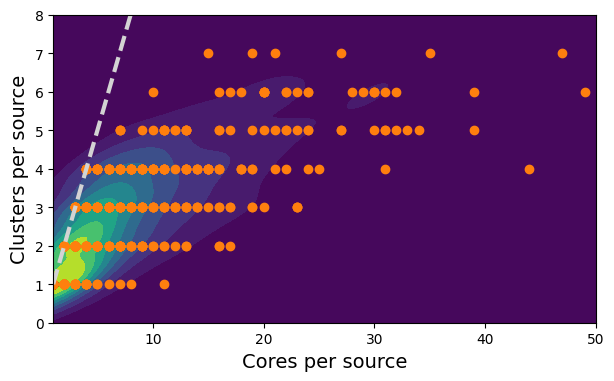

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
kdeplot(x=cores_per_source, y=clusters_per_source, fill=True, cmap="viridis", clip=[(1, 50), (0, 8)], ax=ax, thresh=0)
ax.plot([1, len(np.unique(ordered_labels)) - 1], [1, len(np.unique(ordered_labels)) - 1], linestyle='--', color='lightgrey', linewidth=3)
ax.scatter(cores_per_source, clusters_per_source)
plt.ylim((0, 8))
plt.xlabel('Cores per source', fontsize=14)
plt.ylabel('Clusters per source', fontsize=14)
plt.savefig('results/analysis/cores_and_clusters_label10.pdf')
plt.show()

<Axes: ylabel='Density'>

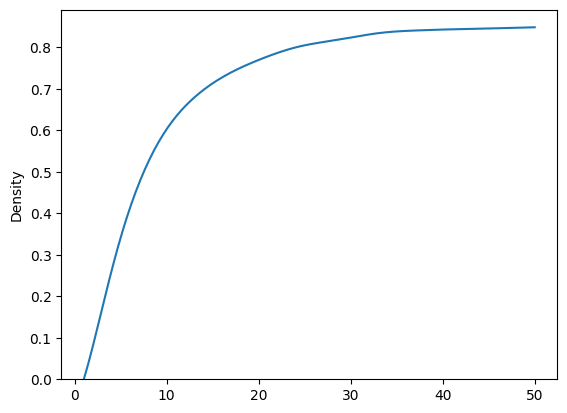

In [ ]:
kdeplot(cores_per_source, clip=(1, 50), cumulative=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 15, 16, 17, 18,
       20, 21, 22]), array([384, 469,  30, 311, 844,  34,  11, 316,  10,  41, 189,   3,  75,
        69, 891,  63, 174, 189, 167,  52]))
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18]), array([384, 891, 844, 469, 316, 311, 189, 189, 174, 167,  75,  69,  63,
        52,  41,  34,  30,  11,  10,   3]))
There are 719 H2 regions
Cluster -1: 46/384 signals (11.98%) belong to HII regions
Cluster 0: 179/891 signals (20.09%) belong to HII regions
Cluster 1: 143/844 signals (16.94%) belong to HII regions
Cluster 2: 90/465 signals (19.35%) belong to HII regions
Cluster 3: 51/316 signals (16.14%) belong to HII regions
Cluster 4: 44/310 signals (14.19%) belong to HII regions
Cluster 5: 31/189 signals (16.40%) belong to HII regions
Cluster 6: 23/189 signals (12.17%) belong to HII regions
Cluster 7: 29/174 signals (16.67%) belong to HII regions
Cluster 8: 21/167 signals (12.57%

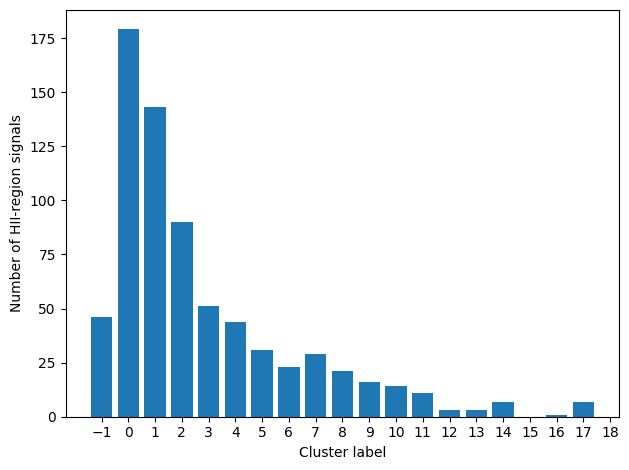

<ipython-input-14-1f95148a1a88>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'] = ordered_labels


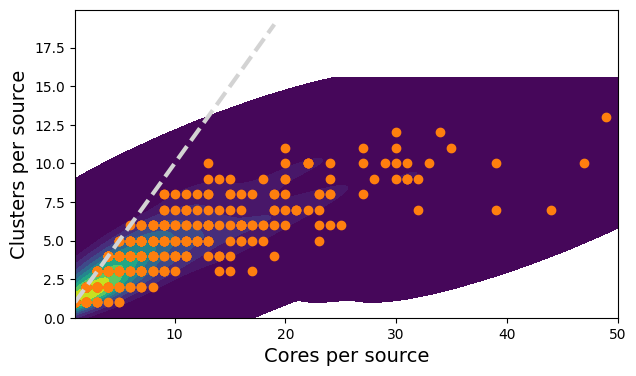

In [ ]:
labels_10 = np.load("Data/Processed/labels23.npy")
print(np.unique(labels_10, return_counts=True))

labels_10_mask = labels_10 != -1  # Mask for clustered signals
ordered_labels = labels_10.copy()

unique_labels, sizes = np.unique(labels_10[labels_10_mask], return_counts=True)
for i, label in enumerate(unique_labels[np.argsort(sizes)[::-1]]):
    ordered_labels[labels_10 == label] = i

print(np.unique(ordered_labels, return_counts=True))

# Match data from tables to data from available sources
idx = []
labels = []
sc_pair = []

# Filter data from data_info not in velocity_info
for i in range(len(data_info)):
    source = data_info['CLUMP'].iloc[i]
    core = data_info['ID'].iloc[i]
    
    index = velocity_info[(velocity_info['Source'] == source) & (velocity_info['Core'] == core)].index.to_list()
    if len(index) > 0:
        idx.append(index[0])
        labels.append(labels_10[index[0]])
        
        sc_pair.append((source, core))

df = data_info.iloc[idx]

# Filter data from velocity_info not in data_info
idx = []
for i in range(len(velocity_info)):
    source = velocity_info["Source"].iloc[i]
    core = velocity_info["Core"].iloc[i]
    
    if (source, core) in sc_pair:
        idx.append(i)

velocity_info = velocity_info.iloc[idx]
ordered_labels = ordered_labels[idx]

# Delete data from H_II regions
h2_mask = df['RADIO_MATCH'] == 1

print(f"There are {sum(h2_mask)} H2 regions")

clusters_10_h2, count_10_h2 = np.unique(ordered_labels[h2_mask], return_counts=True)
for i in range(len(clusters_10_h2)):
    print(f"Cluster {clusters_10_h2[i]}: {count_10_h2[i]}/{sum(ordered_labels == clusters_10_h2[i])} signals ({count_10_h2[i]/sum(ordered_labels == clusters_10_h2[i]) * 100:.2f}%) belong to HII regions")

plt.bar(clusters_10_h2, count_10_h2)
plt.xticks(ticks=np.unique(ordered_labels))
plt.xlabel("Cluster label")
plt.ylabel("Number of HII-region signals")
plt.tight_layout()
plt.show()

variables = ['DIST', 'Lclump', 'Mclump', 'Tclump', 'n(H2)', 'Dcore', 'Lclump/Mclump', 'Surfd_nd']

# Add label column
df['Label'] = ordered_labels

cores_per_source = np.array([len(df['ID'][df['CLUMP'] == source].unique()) for source in df['CLUMP'].unique()])
n_cores_per_source, instances_core = np.unique(cores_per_source, return_counts=True)

clusters_per_source = np.array([len(df['Label'][df['CLUMP'] == source].unique()) for source in df['CLUMP'].unique()])
for i, source in enumerate(df["CLUMP"].unique()):
    if -1 in df['Label'][df['CLUMP'] == source]:
        clusters_per_source[i] -= 1
n_clusters_per_source, instances_clusters = np.unique(clusters_per_source, return_counts=True)

fig, ax = plt.subplots(figsize=(7, 4))
kdeplot(x=cores_per_source, y=clusters_per_source, fill=True, cmap="viridis", clip=[(1, 50), (0, 20)], ax=ax, thresh=0)
ax.plot([1, len(np.unique(ordered_labels)) - 1], [1, len(np.unique(ordered_labels)) - 1], linestyle='--', color='lightgrey', linewidth=3)
ax.scatter(cores_per_source, clusters_per_source)
# plt.ylim((0, 20))
plt.xlabel('Cores per source', fontsize=14)
plt.ylabel('Clusters per source', fontsize=14)
plt.savefig('results/analysis/cores_and_clusters_label23.pdf')
plt.show()

In [ ]:
len(np.unique(labels_10))

20

ValueError: Contour levels must be increasing

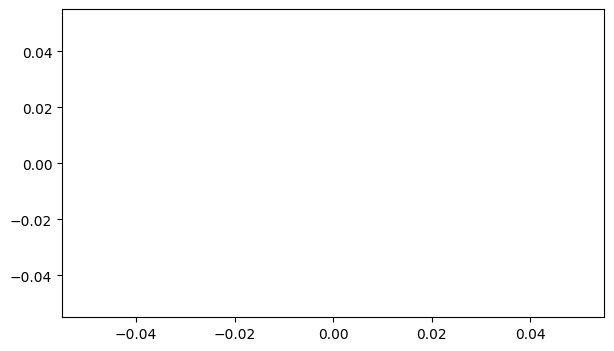

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
kdeplot(x=cores_per_source, y=clusters_per_source, fill=True, cmap="viridis", clip=[(1, 50), (0, 20)], ax=ax, thresh=-1)
ax.plot([1, len(np.unique(ordered_labels)) - 1], [1, len(np.unique(ordered_labels)) - 1], linestyle='--', color='lightgrey', linewidth=3)
ax.scatter(cores_per_source, clusters_per_source)
plt.ylim((0, 20))
plt.yticsk(ticks=np.arange(1, 20, 2))
plt.xlabel('Cores per source', fontsize=14)
plt.ylabel('Clusters per source', fontsize=14)
plt.savefig('results/analysis/cores_and_clusters_label23.pdf')
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'yticsk'

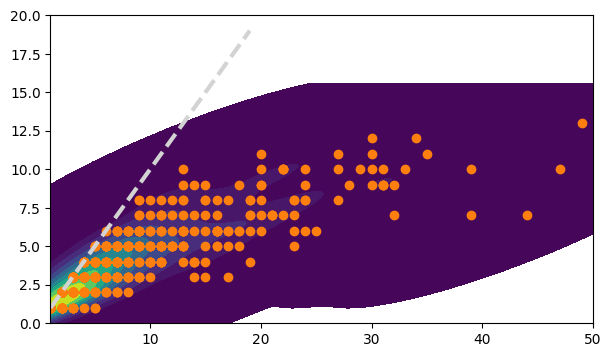

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
kdeplot(x=cores_per_source, y=clusters_per_source, fill=True, cmap="viridis", clip=[(1, 50), (0, 20)], ax=ax, thresh=0)
ax.plot([1, len(np.unique(ordered_labels)) - 1], [1, len(np.unique(ordered_labels)) - 1], linestyle='--', color='lightgrey', linewidth=3)
ax.scatter(cores_per_source, clusters_per_source)
plt.ylim((0, 20))
plt.yticsk(ticks=np.arange(1, 20, 2))
plt.xlabel('Cores per source', fontsize=14)
plt.ylabel('Clusters per source', fontsize=14)
plt.savefig('results/analysis/cores_and_clusters_label23.pdf')
plt.show()

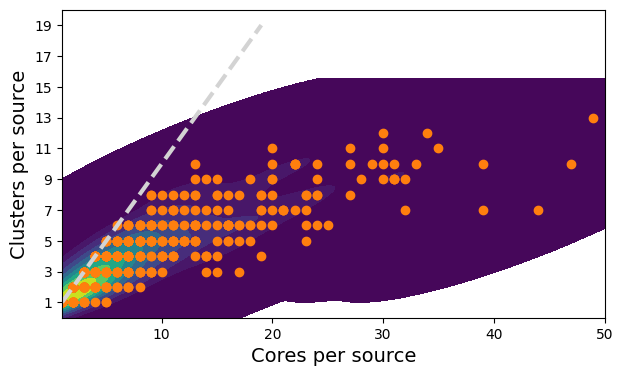

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
kdeplot(x=cores_per_source, y=clusters_per_source, fill=True, cmap="viridis", clip=[(1, 50), (0, 20)], ax=ax, thresh=0)
ax.plot([1, len(np.unique(ordered_labels)) - 1], [1, len(np.unique(ordered_labels)) - 1], linestyle='--', color='lightgrey', linewidth=3)
ax.scatter(cores_per_source, clusters_per_source)
plt.ylim((0, 20))
plt.yticks(ticks=np.arange(1, 20, 2))
plt.xlabel('Cores per source', fontsize=14)
plt.ylabel('Clusters per source', fontsize=14)
plt.savefig('results/analysis/cores_and_clusters_label23.pdf')
plt.show()

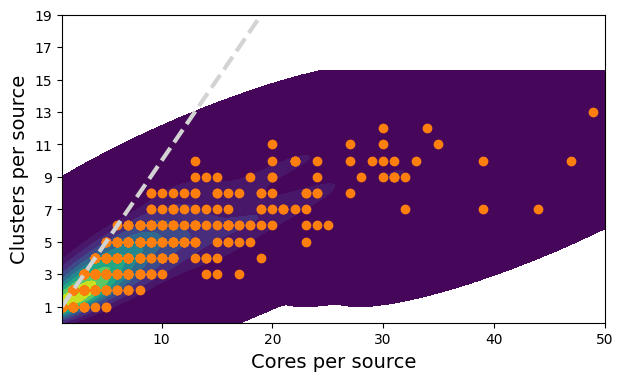

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
kdeplot(x=cores_per_source, y=clusters_per_source, fill=True, cmap="viridis", clip=[(1, 50), (0, 19)], ax=ax, thresh=0)
ax.plot([1, len(np.unique(ordered_labels)) - 1], [1, len(np.unique(ordered_labels)) - 1], linestyle='--', color='lightgrey', linewidth=3)
ax.scatter(cores_per_source, clusters_per_source)
plt.ylim((0, 19))
plt.yticks(ticks=np.arange(1, 20, 2))
plt.xlabel('Cores per source', fontsize=14)
plt.ylabel('Clusters per source', fontsize=14)
plt.savefig('results/analysis/cores_and_clusters_label23.pdf')
plt.show()

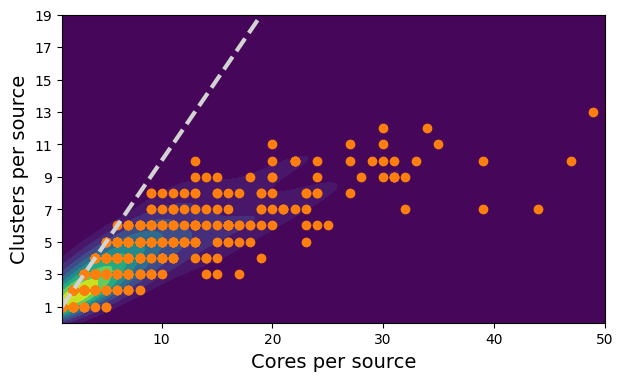

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
kdeplot(x=np.hstack((cores_per_source, np.array([20, 45, 45]))), y=np.hstack((clusters_per_source, np.array([20, 20, 3]))), fill=True, cmap="viridis", clip=[(1, 50), (0, 19)], ax=ax, thresh=0)
ax.plot([1, len(np.unique(ordered_labels)) - 1], [1, len(np.unique(ordered_labels)) - 1], linestyle='--', color='lightgrey', linewidth=3)
ax.scatter(cores_per_source, clusters_per_source)
plt.ylim((0, 19))
plt.yticks(ticks=np.arange(1, 20, 2))
plt.xlabel('Cores per source', fontsize=14)
plt.ylabel('Clusters per source', fontsize=14)
plt.savefig('results/analysis/cores_and_clusters_label23.pdf')
plt.show()

In [ ]:
np.corrcoef(cores_per_source, clusters_per_source)

array([[1.        , 0.86342297],
       [0.86342297, 1.        ]])

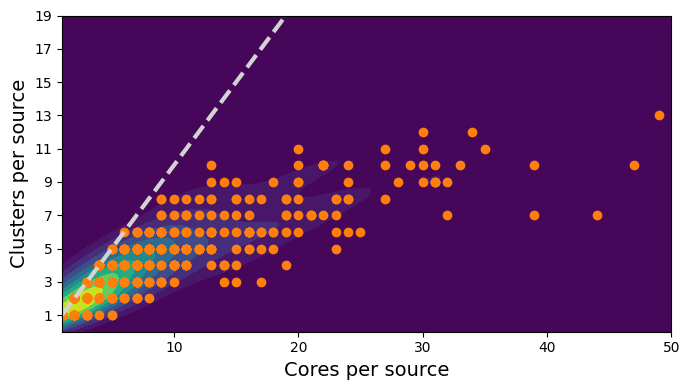

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
kdeplot(x=np.hstack((cores_per_source, np.array([20, 45, 45]))), y=np.hstack((clusters_per_source, np.array([20, 20, 3]))), fill=True, cmap="viridis", clip=[(1, 50), (0, 19)], ax=ax, thresh=0)
ax.plot([1, len(np.unique(ordered_labels)) - 1], [1, len(np.unique(ordered_labels)) - 1], linestyle='--', color='lightgrey', linewidth=3)
ax.scatter(cores_per_source, clusters_per_source)
plt.ylim((0, 19))
plt.yticks(ticks=np.arange(1, 20, 2))
plt.xlabel('Cores per source', fontsize=14)
plt.ylabel('Clusters per source', fontsize=14)
plt.tight_layout()
plt.savefig('results/analysis/cores_and_clusters_label23.pdf')
plt.show()

(array([-1,  0,  1,  2,  3,  4,  5,  7,  8]), array([ 440, 1796,   15,  103,  427,  114,  363, 1054,   10]))
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7]), array([ 440, 1796, 1054,  427,  363,  114,  103,   15,   10]))
There are 719 H2 regions
Cluster -1: 68/440 signals (15.45%) belong to HII regions
Cluster 0: 305/1792 signals (17.02%) belong to HII regions
Cluster 1: 188/1054 signals (17.84%) belong to HII regions
Cluster 2: 63/426 signals (14.79%) belong to HII regions
Cluster 3: 52/363 signals (14.33%) belong to HII regions
Cluster 4: 14/112 signals (12.50%) belong to HII regions
Cluster 5: 21/103 signals (20.39%) belong to HII regions
Cluster 6: 1/15 signals (6.67%) belong to HII regions
Cluster 7: 7/10 signals (70.00%) belong to HII regions


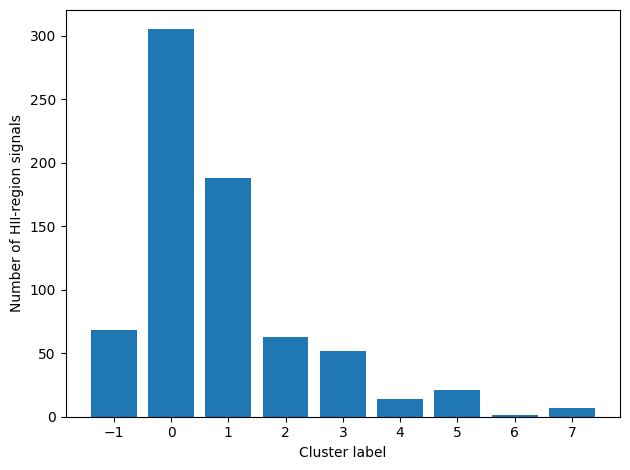

<ipython-input-23-32760c952e66>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'] = ordered_labels


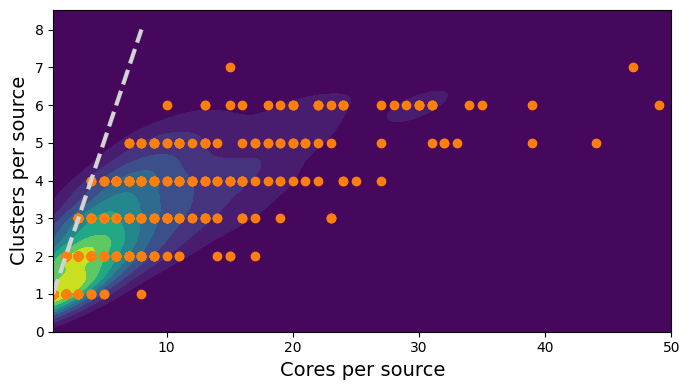

In [ ]:
labels_10 = np.load("Data/Processed/labels10.npy")
print(np.unique(labels_10, return_counts=True))

labels_10_mask = labels_10 != -1  # Mask for clustered signals
ordered_labels = labels_10.copy()

unique_labels, sizes = np.unique(labels_10[labels_10_mask], return_counts=True)
for i, label in enumerate(unique_labels[np.argsort(sizes)[::-1]]):
    ordered_labels[labels_10 == label] = i

print(np.unique(ordered_labels, return_counts=True))

# Match data from tables to data from available sources
idx = []
labels = []
sc_pair = []

# Filter data from data_info not in velocity_info
for i in range(len(data_info)):
    source = data_info['CLUMP'].iloc[i]
    core = data_info['ID'].iloc[i]
    
    index = velocity_info[(velocity_info['Source'] == source) & (velocity_info['Core'] == core)].index.to_list()
    if len(index) > 0:
        idx.append(index[0])
        labels.append(labels_10[index[0]])
        
        sc_pair.append((source, core))

df = data_info.iloc[idx]

# Filter data from velocity_info not in data_info
idx = []
for i in range(len(velocity_info)):
    source = velocity_info["Source"].iloc[i]
    core = velocity_info["Core"].iloc[i]
    
    if (source, core) in sc_pair:
        idx.append(i)

velocity_info = velocity_info.iloc[idx]
ordered_labels = ordered_labels[idx]

# Delete data from H_II regions
h2_mask = df['RADIO_MATCH'] == 1

print(f"There are {sum(h2_mask)} H2 regions")

clusters_10_h2, count_10_h2 = np.unique(ordered_labels[h2_mask], return_counts=True)
for i in range(len(clusters_10_h2)):
    print(f"Cluster {clusters_10_h2[i]}: {count_10_h2[i]}/{sum(ordered_labels == clusters_10_h2[i])} signals ({count_10_h2[i]/sum(ordered_labels == clusters_10_h2[i]) * 100:.2f}%) belong to HII regions")

plt.bar(clusters_10_h2, count_10_h2)
plt.xticks(ticks=np.unique(ordered_labels))
plt.xlabel("Cluster label")
plt.ylabel("Number of HII-region signals")
plt.tight_layout()
plt.show()

variables = ['DIST', 'Lclump', 'Mclump', 'Tclump', 'n(H2)', 'Dcore', 'Lclump/Mclump', 'Surfd_nd']

# Add label column
df['Label'] = ordered_labels

cores_per_source = np.array([len(df['ID'][df['CLUMP'] == source].unique()) for source in df['CLUMP'].unique()])
n_cores_per_source, instances_core = np.unique(cores_per_source, return_counts=True)

clusters_per_source = np.array([len(df['Label'][df['CLUMP'] == source].unique()) for source in df['CLUMP'].unique()])
for i, source in enumerate(df["CLUMP"].unique()):
    if -1 in df['Label'][df['CLUMP'] == source]:
        clusters_per_source[i] -= 1
n_clusters_per_source, instances_clusters = np.unique(clusters_per_source, return_counts=True)

fig, ax = plt.subplots(figsize=(7, 4))
kdeplot(x=cores_per_source, y=clusters_per_source, fill=True, cmap="viridis", clip=[(1, 50), (0, 20)], ax=ax, thresh=0)
ax.plot([1, len(np.unique(ordered_labels)) - 1], [1, len(np.unique(ordered_labels)) - 1], linestyle='--', color='lightgrey', linewidth=3)
ax.scatter(cores_per_source, clusters_per_source)
# plt.ylim((0, 20))
plt.xlabel('Cores per source', fontsize=14)
plt.ylabel('Clusters per source', fontsize=14)
plt.tight_layout()
plt.savefig('results/analysis/cores_and_clusters_label10.pdf')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
kdeplot(x=cores_per_source, y=clusters_per_source, fill=True, cmap="viridis", clip=[(1, 50), (0, 20)], ax=ax, thresh=0)
ax.plot([1, len(np.unique(ordered_labels)) - 1], [1, len(np.unique(ordered_labels)) - 1], linestyle='--', color='lightgrey', linewidth=3)
ax.scatter(cores_per_source, clusters_per_source)
plt.ylim((0, 8))
plt.xlabel('Cores per source', fontsize=14)
plt.ylabel('Clusters per source', fontsize=14)
plt.tight_layout()
plt.savefig('results/analysis/cores_and_clusters_label10.pdf')
plt.show()

(array([-1,  0,  1,  2,  3,  4,  5,  7,  8]), array([ 440, 1796,   15,  103,  427,  114,  363, 1054,   10]))
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7]), array([ 440, 1796, 1054,  427,  363,  114,  103,   15,   10]))
There are 719 H2 regions
Cluster -1: 68/440 signals (15.45%) belong to HII regions
Cluster 0: 305/1792 signals (17.02%) belong to HII regions
Cluster 1: 188/1054 signals (17.84%) belong to HII regions
Cluster 2: 63/426 signals (14.79%) belong to HII regions
Cluster 3: 52/363 signals (14.33%) belong to HII regions
Cluster 4: 14/112 signals (12.50%) belong to HII regions
Cluster 5: 21/103 signals (20.39%) belong to HII regions
Cluster 6: 1/15 signals (6.67%) belong to HII regions
Cluster 7: 7/10 signals (70.00%) belong to HII regions


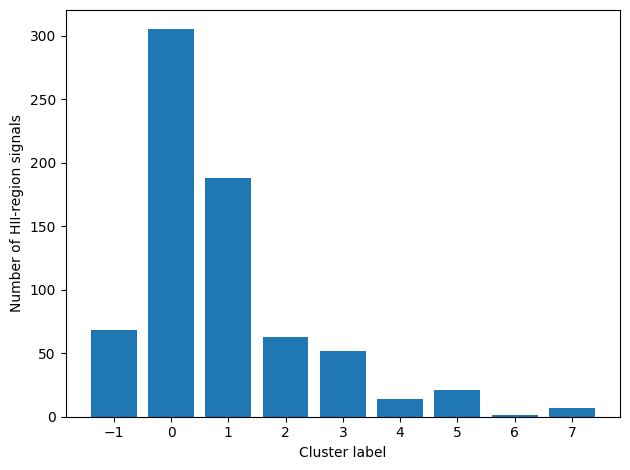

<ipython-input-25-f69183ed1387>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'] = ordered_labels


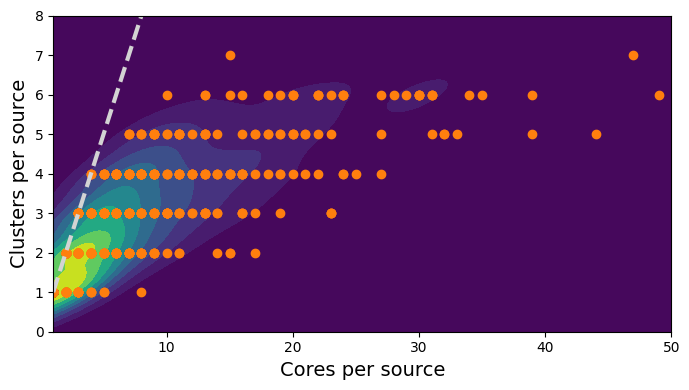

In [ ]:
labels_10 = np.load("Data/Processed/labels10.npy")
print(np.unique(labels_10, return_counts=True))

labels_10_mask = labels_10 != -1  # Mask for clustered signals
ordered_labels = labels_10.copy()

unique_labels, sizes = np.unique(labels_10[labels_10_mask], return_counts=True)
for i, label in enumerate(unique_labels[np.argsort(sizes)[::-1]]):
    ordered_labels[labels_10 == label] = i

print(np.unique(ordered_labels, return_counts=True))

# Match data from tables to data from available sources
idx = []
labels = []
sc_pair = []

# Filter data from data_info not in velocity_info
for i in range(len(data_info)):
    source = data_info['CLUMP'].iloc[i]
    core = data_info['ID'].iloc[i]
    
    index = velocity_info[(velocity_info['Source'] == source) & (velocity_info['Core'] == core)].index.to_list()
    if len(index) > 0:
        idx.append(index[0])
        labels.append(labels_10[index[0]])
        
        sc_pair.append((source, core))

df = data_info.iloc[idx]

# Filter data from velocity_info not in data_info
idx = []
for i in range(len(velocity_info)):
    source = velocity_info["Source"].iloc[i]
    core = velocity_info["Core"].iloc[i]
    
    if (source, core) in sc_pair:
        idx.append(i)

velocity_info = velocity_info.iloc[idx]
ordered_labels = ordered_labels[idx]

# Delete data from H_II regions
h2_mask = df['RADIO_MATCH'] == 1

print(f"There are {sum(h2_mask)} H2 regions")

clusters_10_h2, count_10_h2 = np.unique(ordered_labels[h2_mask], return_counts=True)
for i in range(len(clusters_10_h2)):
    print(f"Cluster {clusters_10_h2[i]}: {count_10_h2[i]}/{sum(ordered_labels == clusters_10_h2[i])} signals ({count_10_h2[i]/sum(ordered_labels == clusters_10_h2[i]) * 100:.2f}%) belong to HII regions")

plt.bar(clusters_10_h2, count_10_h2)
plt.xticks(ticks=np.unique(ordered_labels))
plt.xlabel("Cluster label")
plt.ylabel("Number of HII-region signals")
plt.tight_layout()
plt.show()

variables = ['DIST', 'Lclump', 'Mclump', 'Tclump', 'n(H2)', 'Dcore', 'Lclump/Mclump', 'Surfd_nd']

# Add label column
df['Label'] = ordered_labels

cores_per_source = np.array([len(df['ID'][df['CLUMP'] == source].unique()) for source in df['CLUMP'].unique()])
n_cores_per_source, instances_core = np.unique(cores_per_source, return_counts=True)

clusters_per_source = np.array([len(df['Label'][df['CLUMP'] == source].unique()) for source in df['CLUMP'].unique()])
for i, source in enumerate(df["CLUMP"].unique()):
    if -1 in df['Label'][df['CLUMP'] == source]:
        clusters_per_source[i] -= 1
n_clusters_per_source, instances_clusters = np.unique(clusters_per_source, return_counts=True)

fig, ax = plt.subplots(figsize=(7, 4))
kdeplot(x=cores_per_source, y=clusters_per_source, fill=True, cmap="viridis", clip=[(1, 50), (0, 8)], ax=ax, thresh=0)
ax.plot([1, len(np.unique(ordered_labels)) - 1], [1, len(np.unique(ordered_labels)) - 1], linestyle='--', color='lightgrey', linewidth=3)
ax.scatter(cores_per_source, clusters_per_source)
plt.ylim((0, 8))
plt.xlabel('Cores per source', fontsize=14)
plt.ylabel('Clusters per source', fontsize=14)
plt.tight_layout()
plt.savefig('results/analysis/cores_and_clusters_label10.pdf')
plt.show()

In [ ]:
np.corrcoef(cores_per_source, clusters_per_source)

array([[1.        , 0.77734804],
       [0.77734804, 1.        ]])

In [ ]:
np.unique(labels_10)

array([-1,  0,  1,  2,  3,  4,  5,  7,  8])

In [ ]:
for label in np.unique(labels_10):
    if label == -1:
        continue
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
    ax[0].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    ax[0].plot(freq, subtraction_signal[labels_10==label].mean(axis=0), color=colors[label], label=f'{sum(labels == i)} signals')

    prod_signal = subtraction_signal[labels_10==label].prod(axis=0)
    ax[1].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    if np.any(prod_signal > 0):
        ax[1].plot(freq, prod_signal / np.max(prod_signal), color=colors[label])
    fig.supxlabel('Frequency [MHz]', fontsize=14)
    fig.supylabel('Intensity [Jy]', fontsize=14)
    fig.tight_layout()
    fig.savefig(f'results/analysis/cluster_{label}_composition.pdf')
    plt.show()

NameError: name 'subtraction_signal' is not defined

In [ ]:
for label in np.unique(labels_10):
    if label == -1:
        continue
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
    ax[0].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    ax[0].plot(freq, subtraction_signals[labels_10==label].mean(axis=0), color=colors[label], label=f'{sum(labels == i)} signals')

    prod_signal = subtraction_signals[labels_10==label].prod(axis=0)
    ax[1].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    if np.any(prod_signal > 0):
        ax[1].plot(freq, prod_signal / np.max(prod_signal), color=colors[label])
    fig.supxlabel('Frequency [MHz]', fontsize=14)
    fig.supylabel('Intensity [Jy]', fontsize=14)
    fig.tight_layout()
    fig.savefig(f'results/analysis/cluster_{label}_composition.pdf')
    plt.show()

NameError: name 'colors' is not defined

In [ ]:
colors = plt.get_cmap("tab10").colors

In [ ]:
for label in np.unique(labels_10):
    if label == -1:
        continue
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
    ax[0].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    ax[0].plot(freq, subtraction_signals[labels_10==label].mean(axis=0), color=colors[label], label=f'{sum(labels == i)} signals')

    prod_signal = subtraction_signals[labels_10==label].prod(axis=0)
    ax[1].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    if np.any(prod_signal > 0):
        ax[1].plot(freq, prod_signal / np.max(prod_signal), color=colors[label])
    fig.supxlabel('Frequency [MHz]', fontsize=14)
    fig.supylabel('Intensity [Jy]', fontsize=14)
    fig.tight_layout()
    fig.savefig(f'results/analysis/cluster_{label}_composition.pdf')
    plt.show()

TypeError: 'bool' object is not iterable

In [ ]:
colors

((0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529))

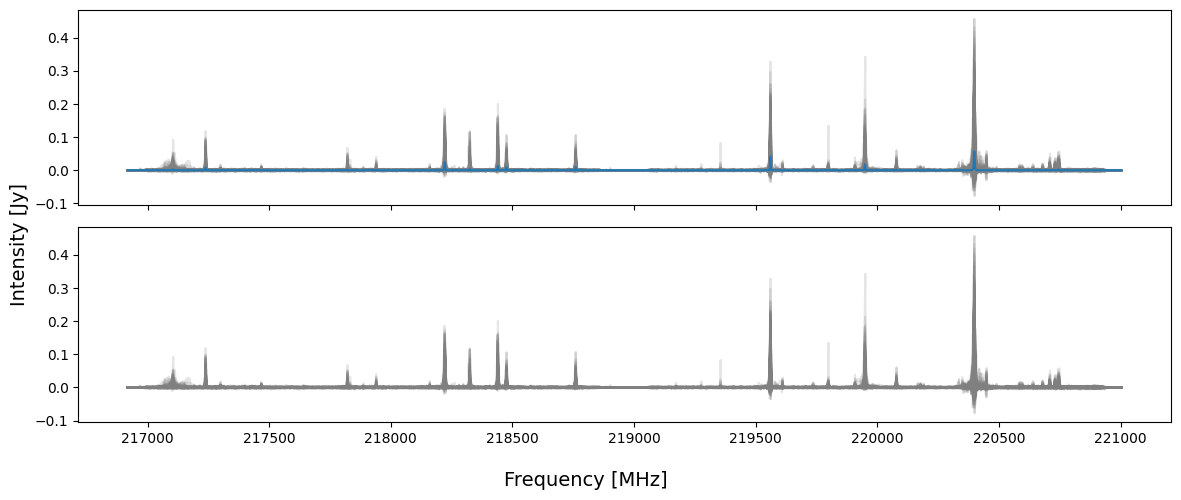

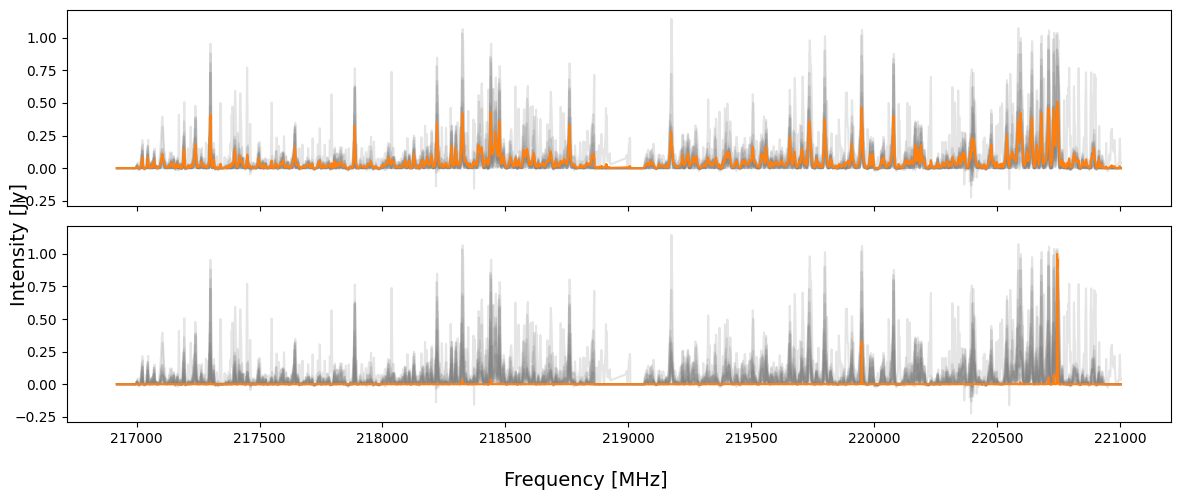

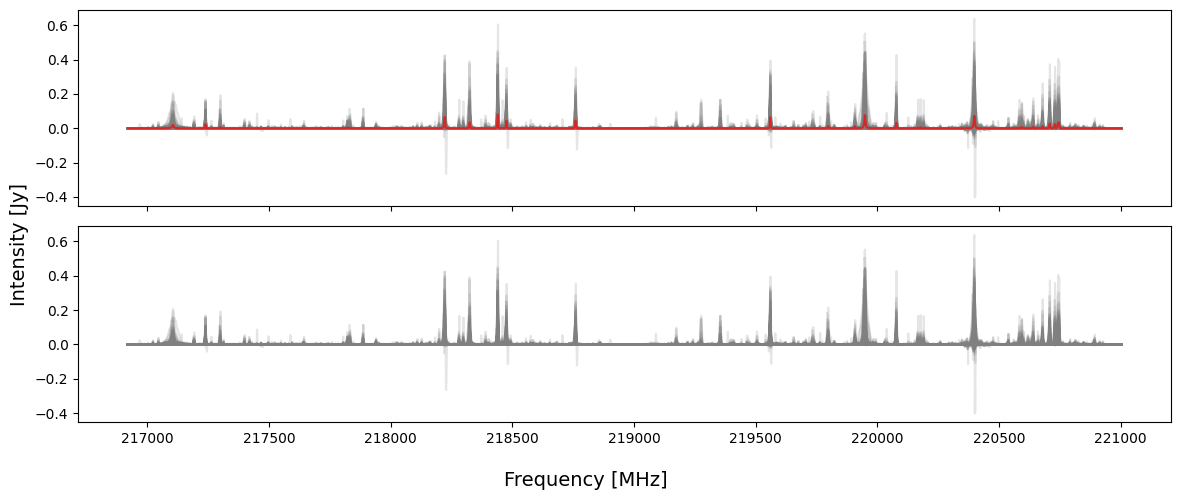

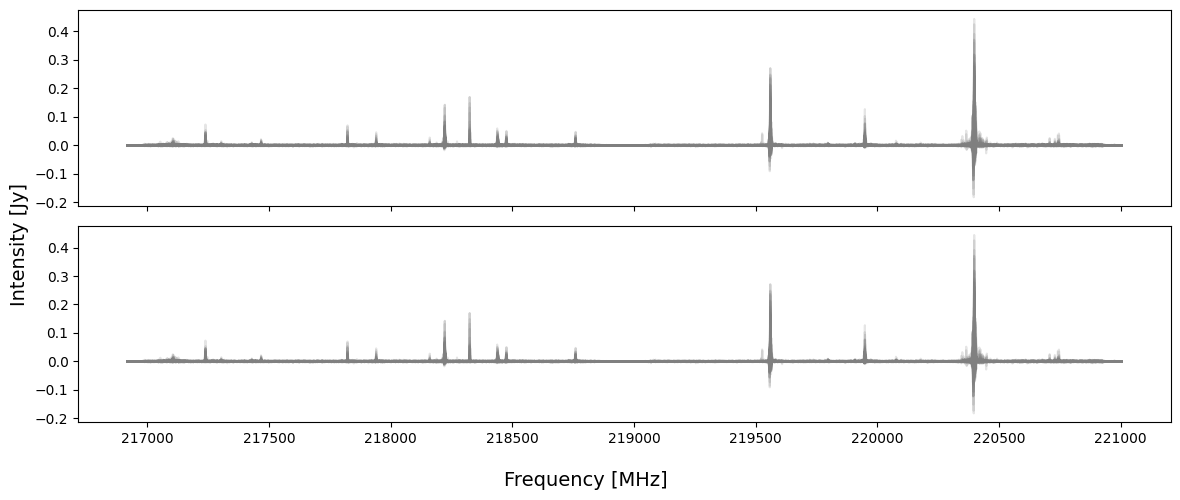

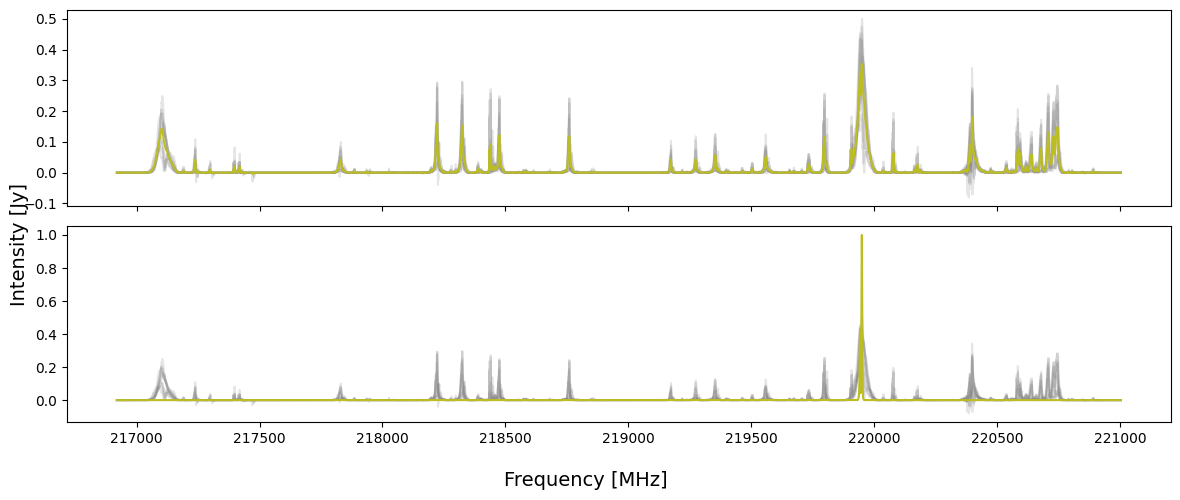

In [ ]:
for label in np.unique(labels_10):
    if label == -1:
        continue
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
    ax[0].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    ax[0].plot(freq, subtraction_signals[labels_10==label].mean(axis=0), color=colors[label])

    prod_signal = subtraction_signals[labels_10==label].prod(axis=0)
    ax[1].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    if np.any(prod_signal > 0):
        ax[1].plot(freq, prod_signal / np.max(prod_signal), color=colors[label])
    fig.supxlabel('Frequency [MHz]', fontsize=14)
    fig.supylabel('Intensity [Jy]', fontsize=14)
    fig.tight_layout()
    fig.savefig(f'results/analysis/cluster_{label}_composition.pdf')
    plt.show()

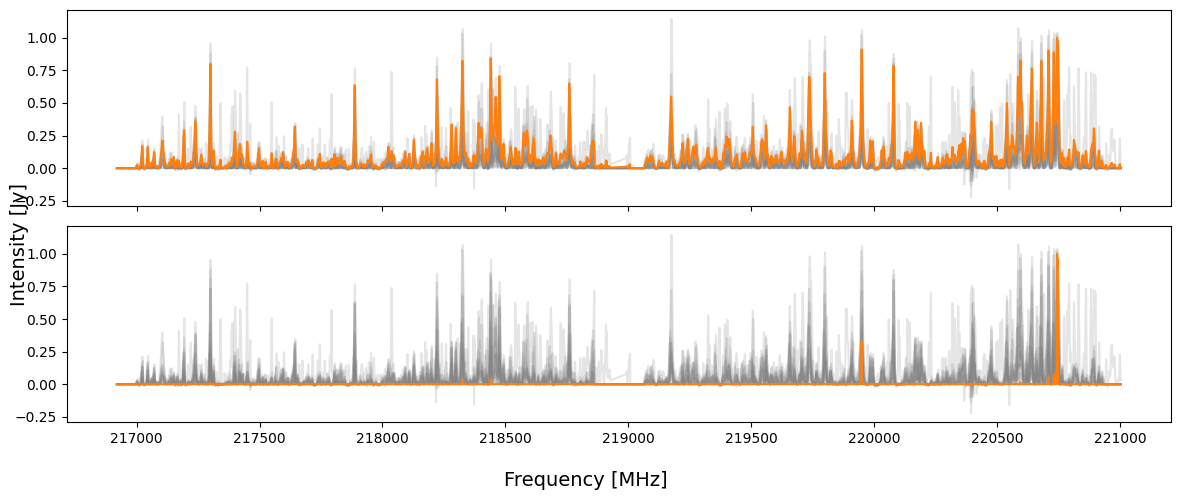

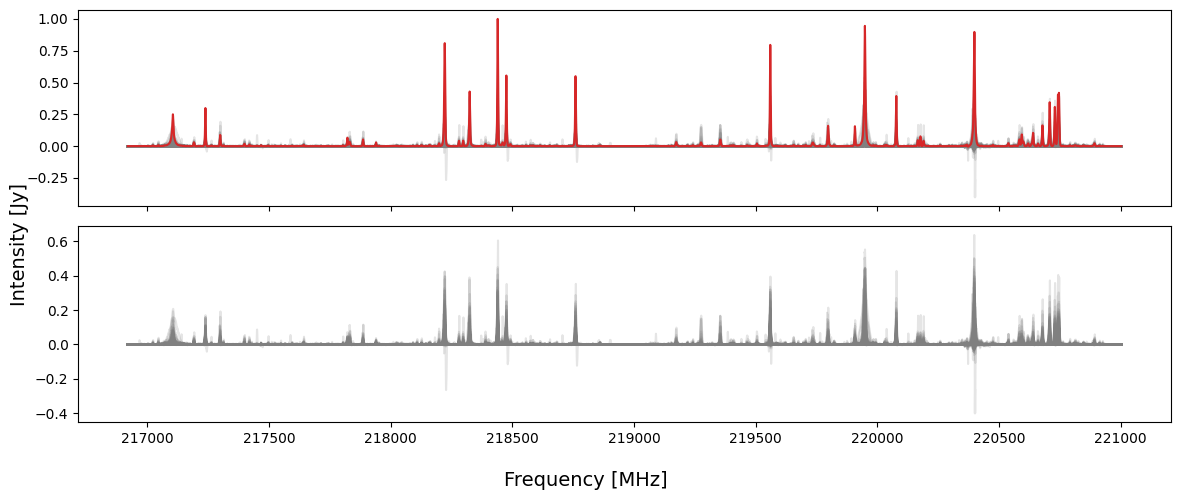

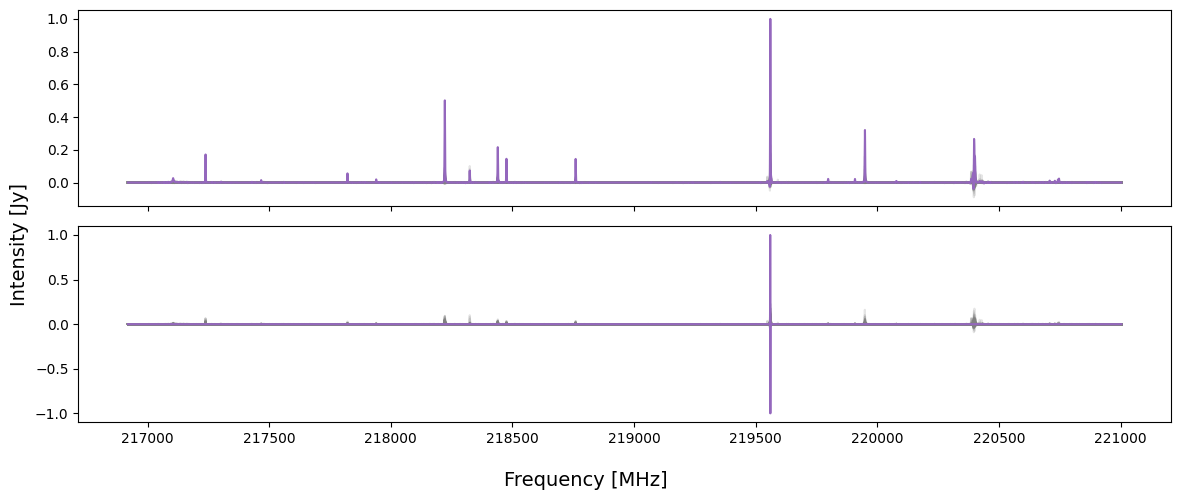

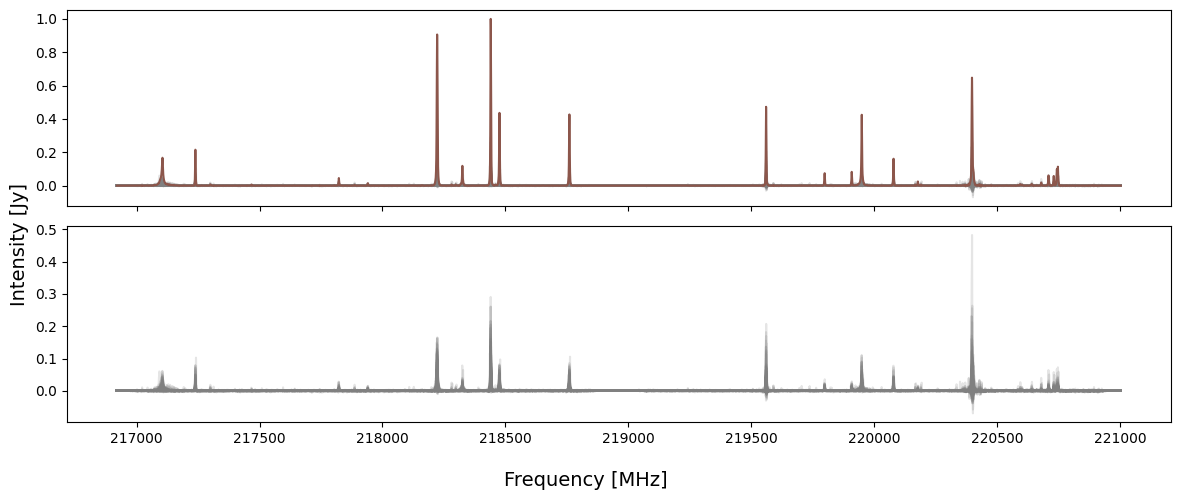

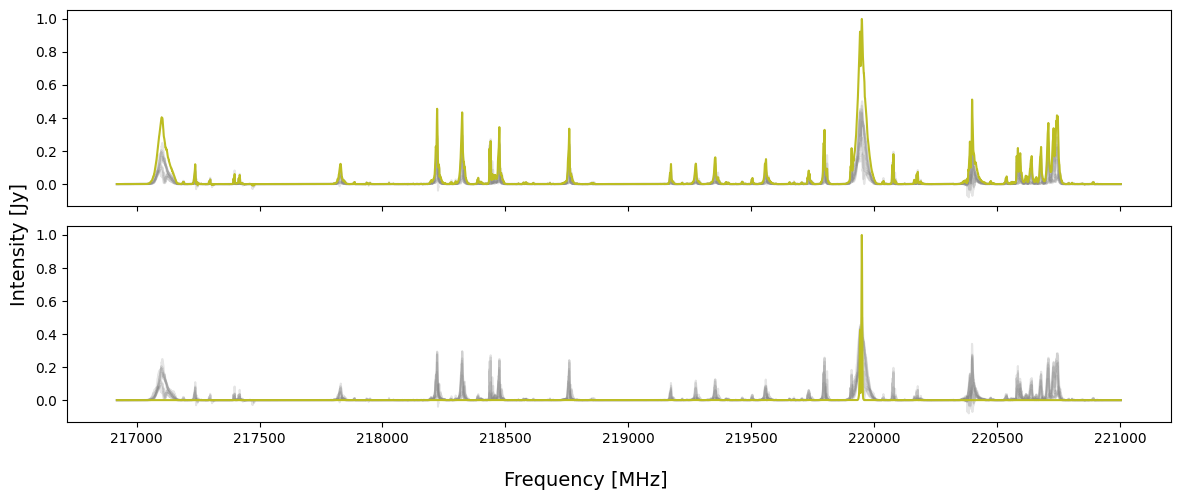

In [ ]:
for label in np.unique(labels_10):
    if label == -1:
        continue
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 5))

    mean = subtraction_signals[labels_10==label].mean(axis=0)
    mean /= np.max(mean)
    mean[mean < -1] = -1

    ax[0].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    ax[0].plot(freq, mean, color=colors[label])

    prod_signal = subtraction_signals[labels_10==label].prod(axis=0)
    
    ax[1].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    if np.any(prod_signal > 0):
        prod_signal /= np.max(prod_signal)
        prod_signal[prod_signal < -1] = -1
        ax[1].plot(freq, prod_signal, color=colors[label])
    fig.supxlabel('Frequency [MHz]', fontsize=14)
    fig.supylabel('Intensity [Jy]', fontsize=14)
    fig.tight_layout()
    fig.savefig(f'results/analysis/cluster_{label}_composition.pdf')
    plt.show()

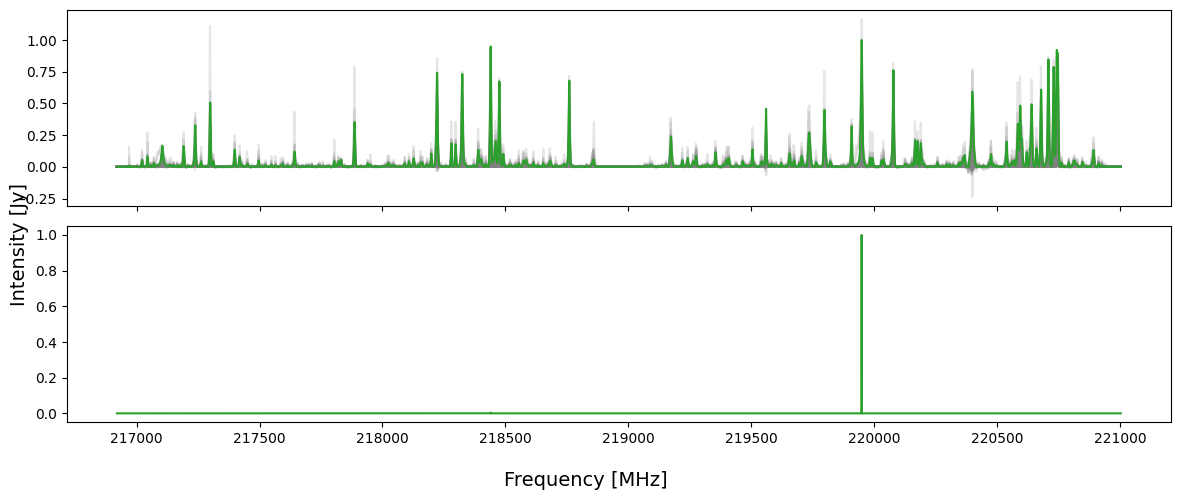

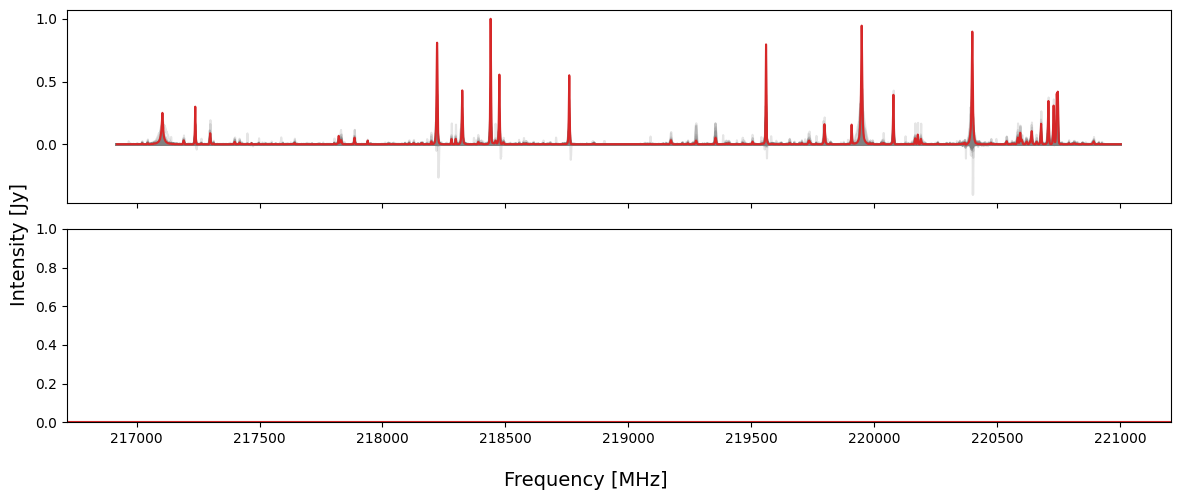

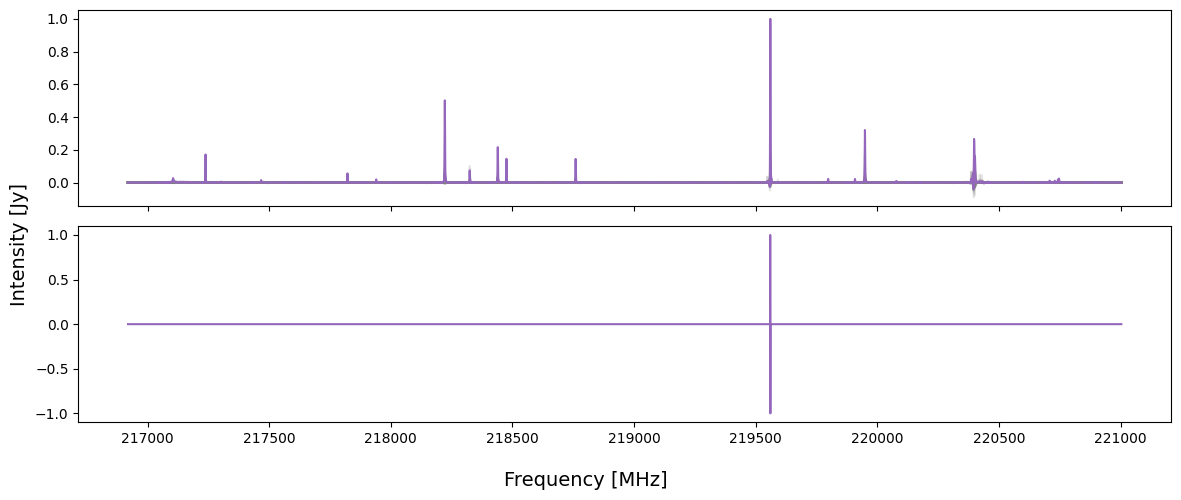

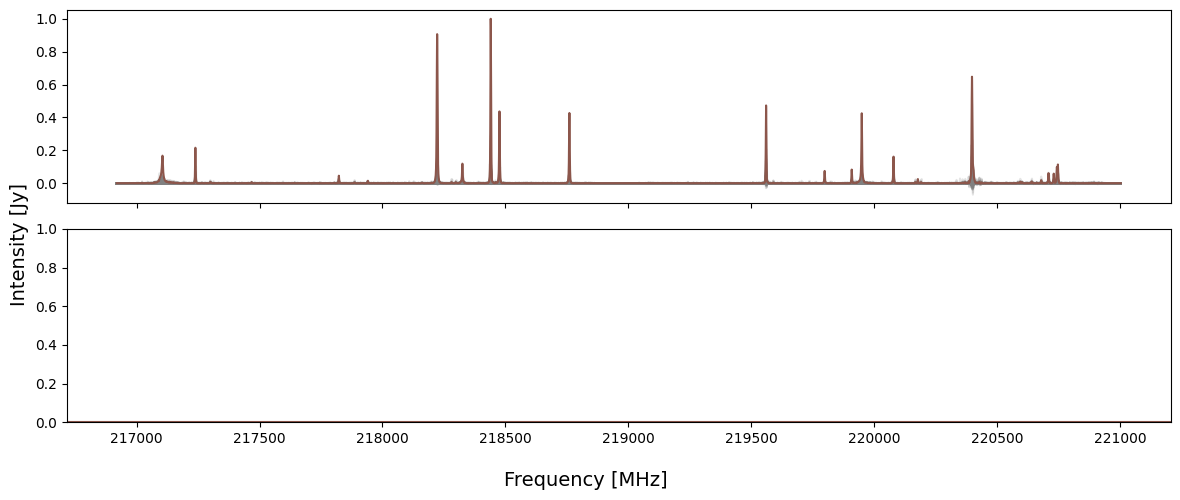

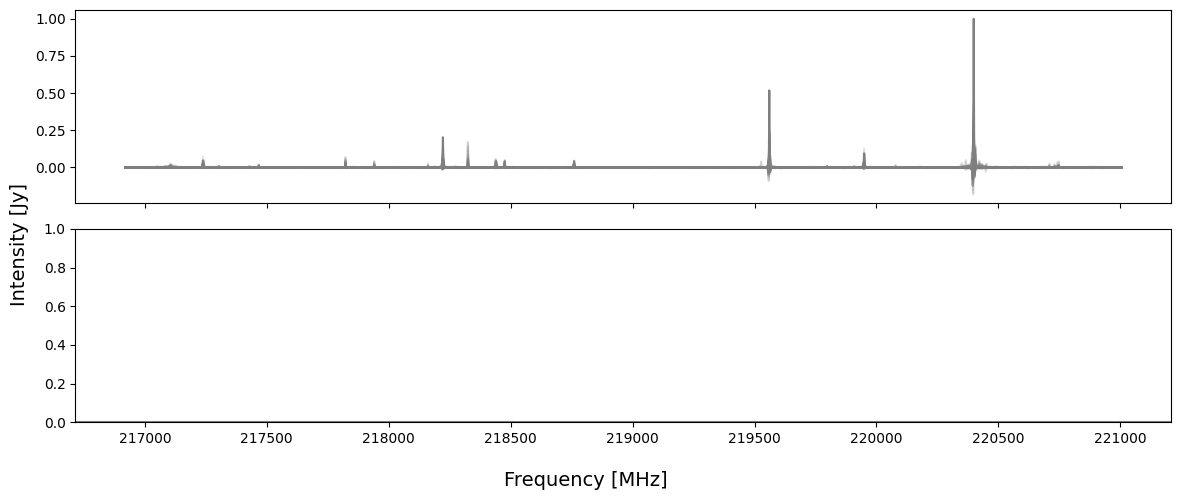

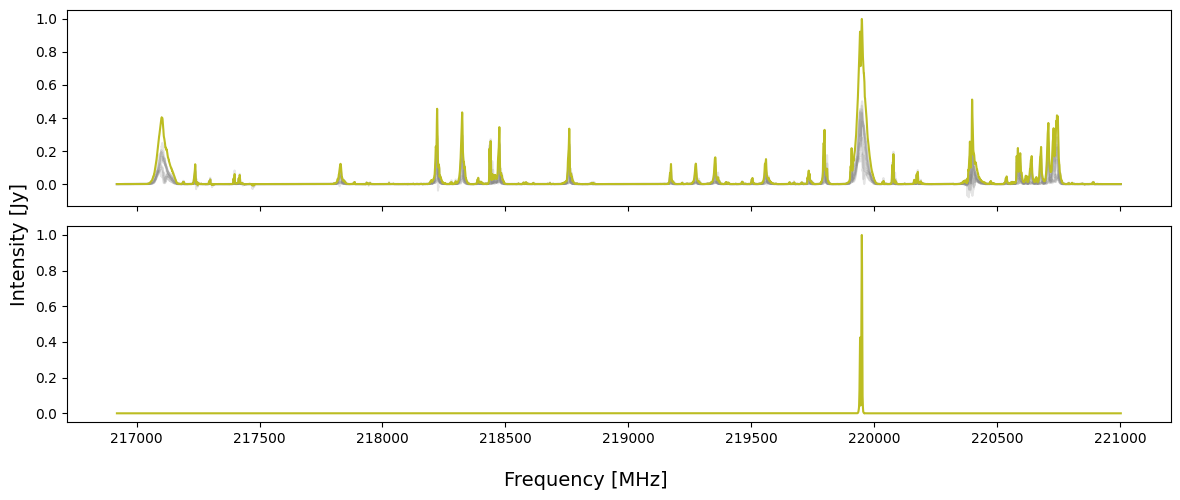

In [ ]:
for label in np.unique(labels_10):
    if label == -1:
        continue
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 5))

    mean = subtraction_signals[labels_10==label].mean(axis=0)
    mean /= np.max(mean)
    mean[mean < -1] = -1

    ax[0].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    ax[0].plot(freq, mean, color=colors[label])

    prod_signal = subtraction_signals[labels_10==label].prod(axis=0)
    
    # ax[1].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    if np.any(prod_signal > 0):
        prod_signal /= np.max(prod_signal)
        prod_signal[prod_signal < -1] = -1
        ax[1].plot(freq, prod_signal, color=colors[label])
    else:
        plt.axhline(0, color=colors[label])
    fig.supxlabel('Frequency [MHz]', fontsize=14)
    fig.supylabel('Intensity [Jy]', fontsize=14)
    fig.tight_layout()
    fig.savefig(f'results/analysis/cluster_{label}_composition.pdf')
    plt.show()

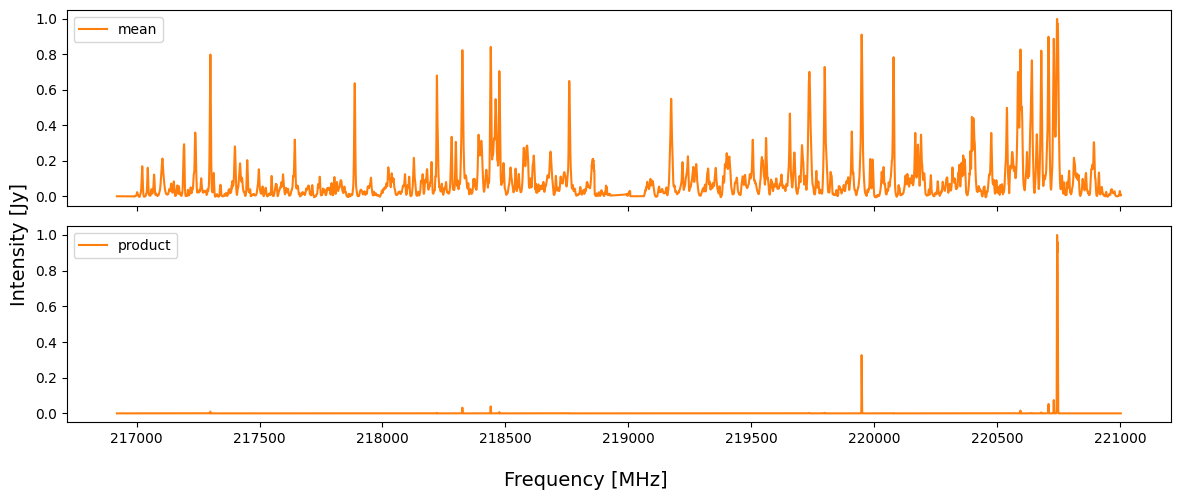

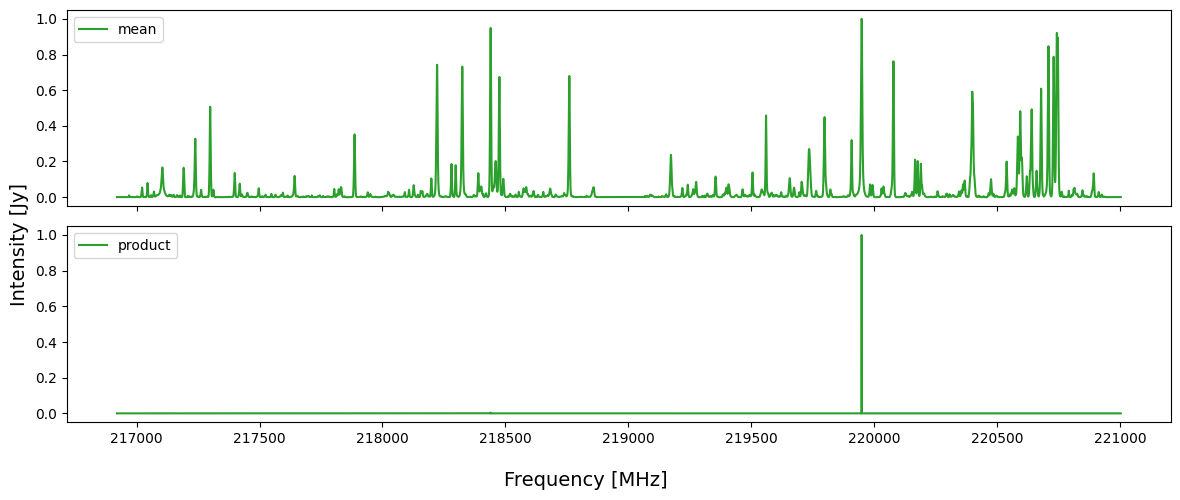

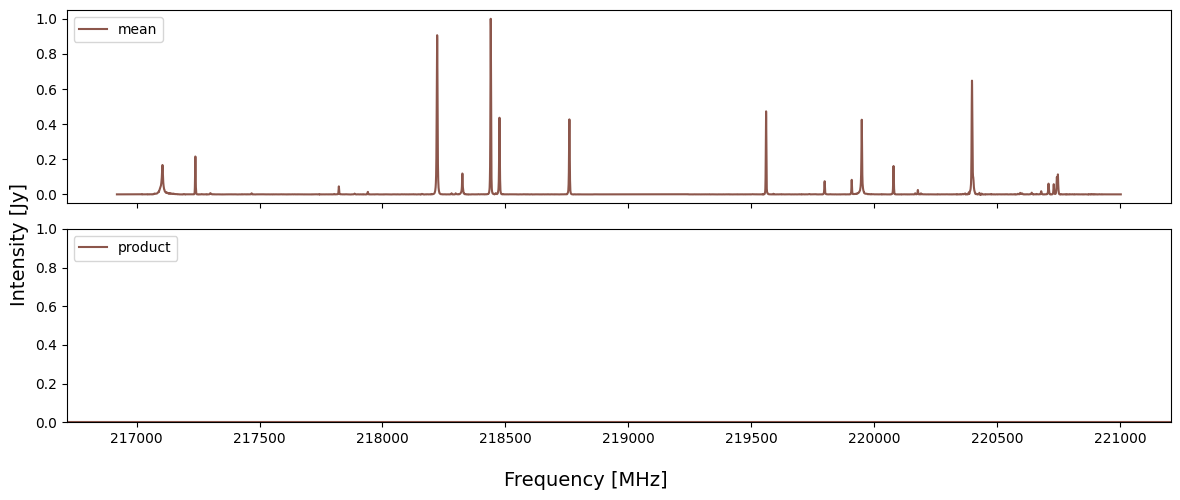

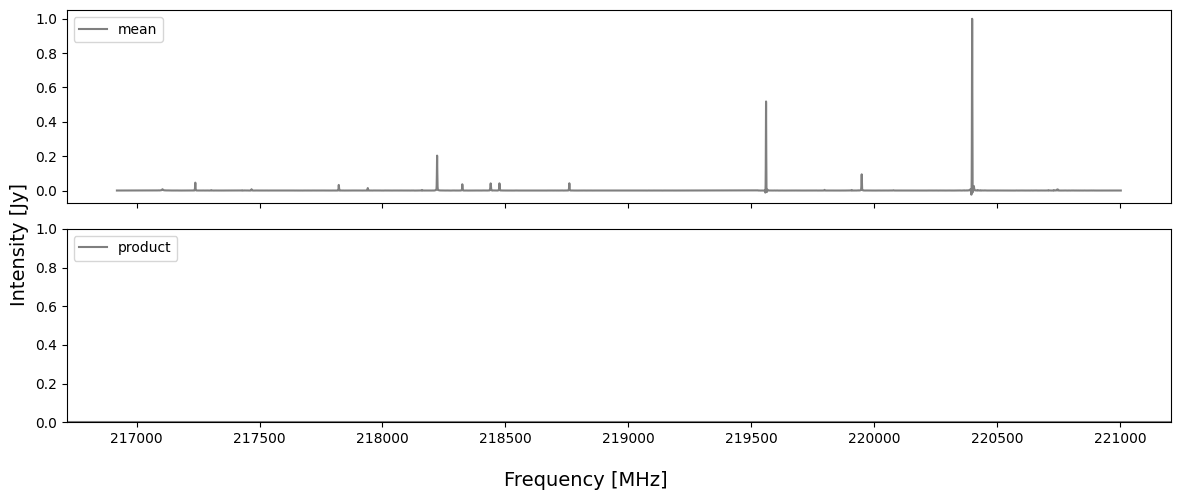

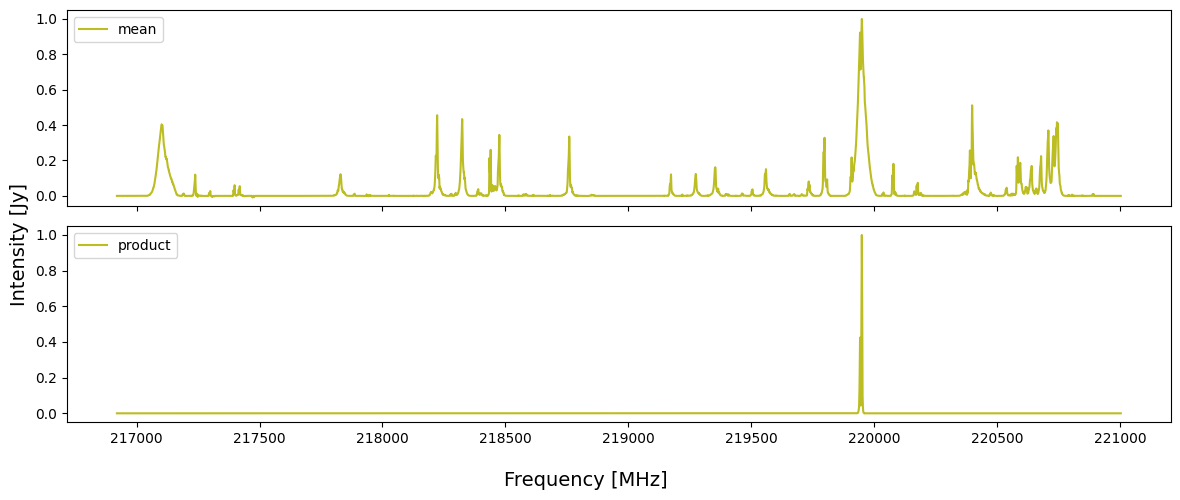

In [ ]:
for label in np.unique(labels_10):
    if label == -1:
        continue
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 5))

    mean = subtraction_signals[labels_10==label].mean(axis=0)
    mean /= np.max(mean)
    mean[mean < -1] = -1

    # ax[0].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    ax[0].plot(freq, mean, color=colors[label], label="mean")
    ax[0].legend(loc="upper left")

    prod_signal = subtraction_signals[labels_10==label].prod(axis=0)
    
    # ax[1].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    if np.any(prod_signal > 0):
        prod_signal /= np.max(prod_signal)
        prod_signal[prod_signal < -1] = -1
        ax[1].plot(freq, prod_signal, color=colors[label], label="product")
    else:
        ax[1].axhline(0, color=colors[label], label="product")
    ax[1].legend(loc="upper left")
    fig.supxlabel('Frequency [MHz]', fontsize=14)
    fig.supylabel('Intensity [Jy]', fontsize=14)
    fig.tight_layout()
    fig.savefig(f'results/analysis/cluster_{label}_composition.pdf')
    plt.show()

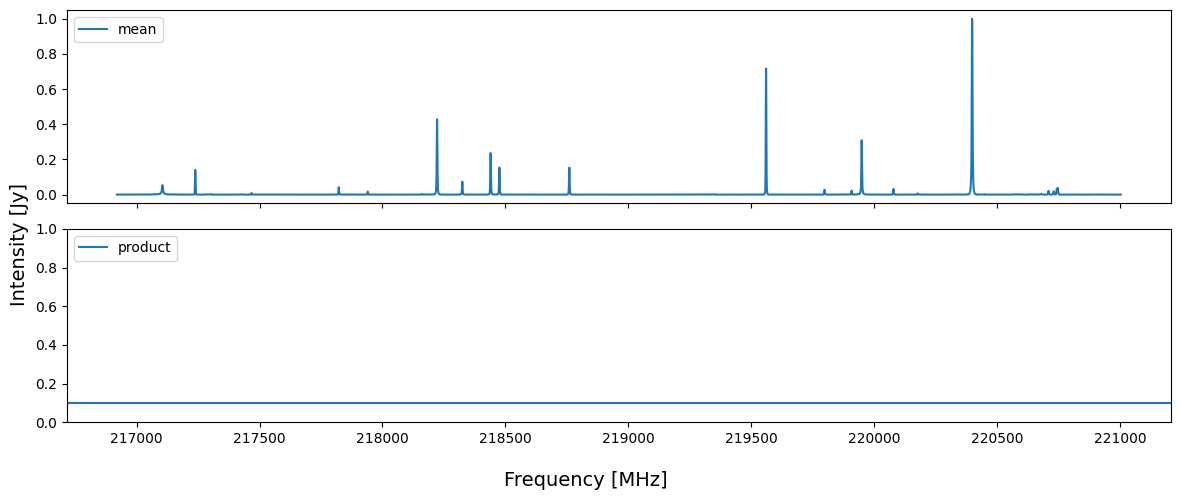

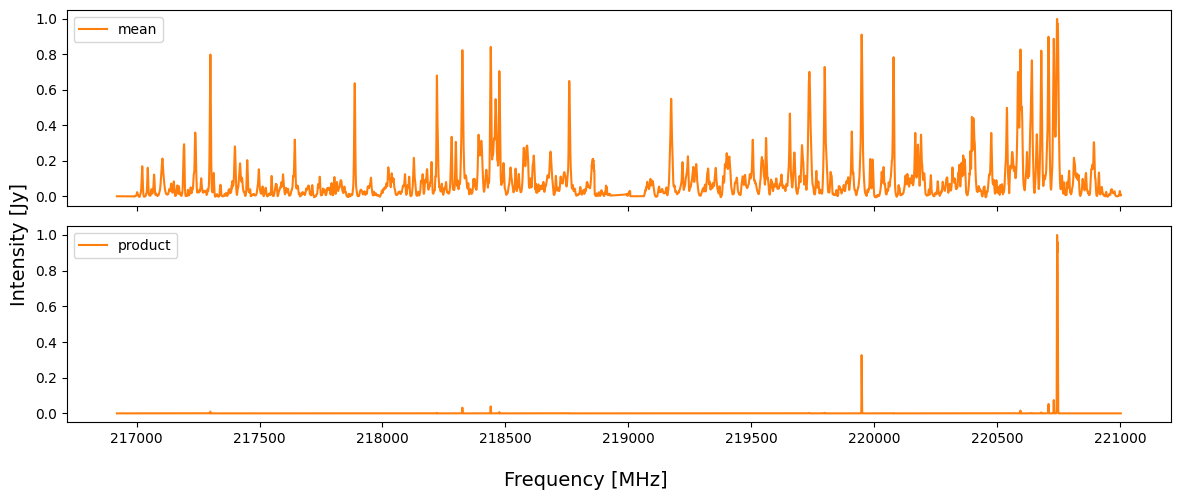

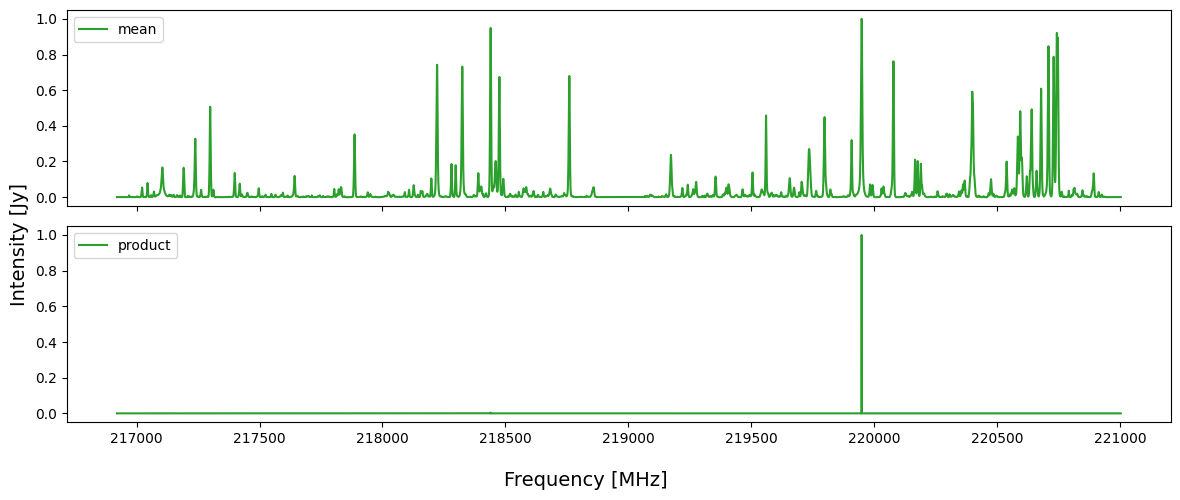

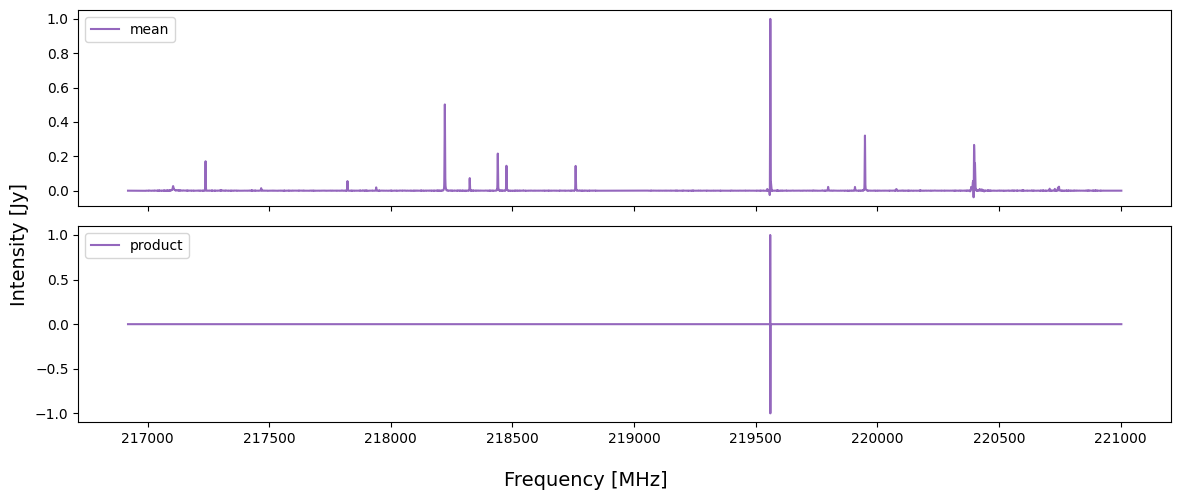

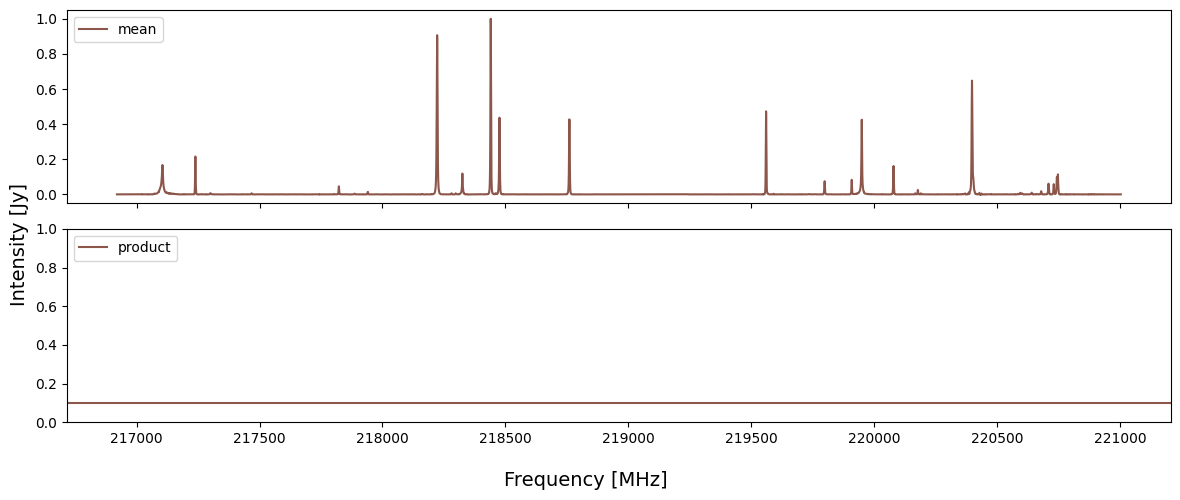

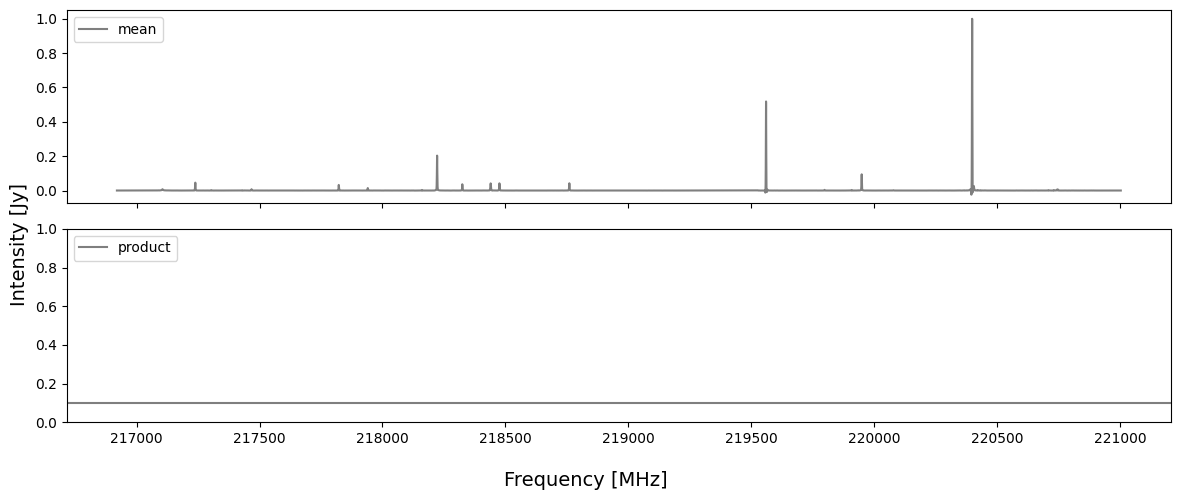

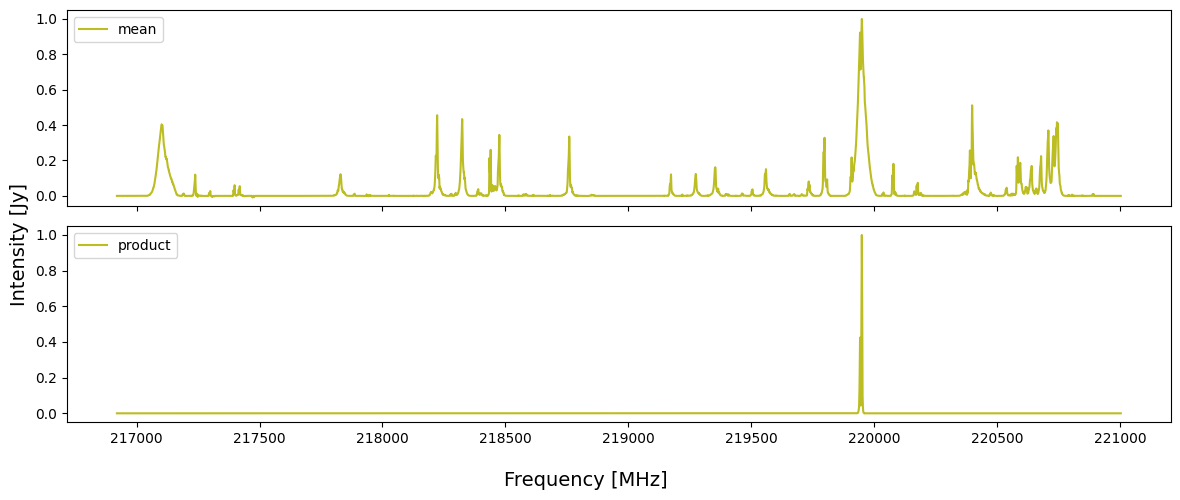

In [ ]:
for label in np.unique(labels_10):
    if label == -1:
        continue
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 5))

    mean = subtraction_signals[labels_10==label].mean(axis=0)
    mean /= np.max(mean)
    mean[mean < -1] = -1

    # ax[0].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    ax[0].plot(freq, mean, color=colors[label], label="mean")
    ax[0].legend(loc="upper left")

    prod_signal = subtraction_signals[labels_10==label].prod(axis=0)
    
    # ax[1].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    if np.any(prod_signal > 0):
        prod_signal /= np.max(prod_signal)
        prod_signal[prod_signal < -1] = -1
        ax[1].plot(freq, prod_signal, color=colors[label], label="product")
    else:
        ax[1].axhline(0.1, color=colors[label], label="product")
    ax[1].legend(loc="upper left")
    fig.supxlabel('Frequency [MHz]', fontsize=14)
    fig.supylabel('Intensity [Jy]', fontsize=14)
    fig.tight_layout()
    fig.savefig(f'results/analysis/cluster_{label}_composition.pdf')
    plt.show()

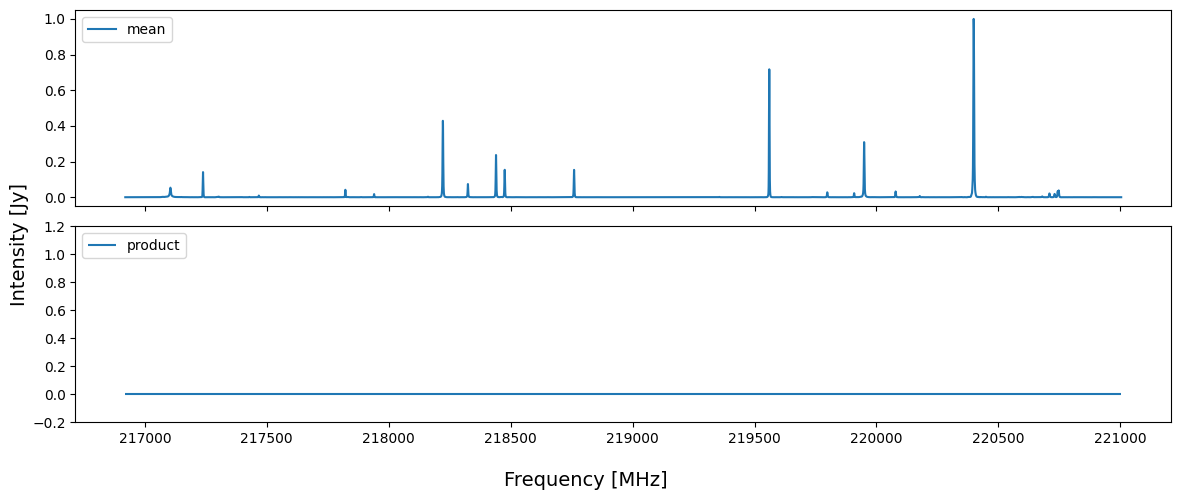

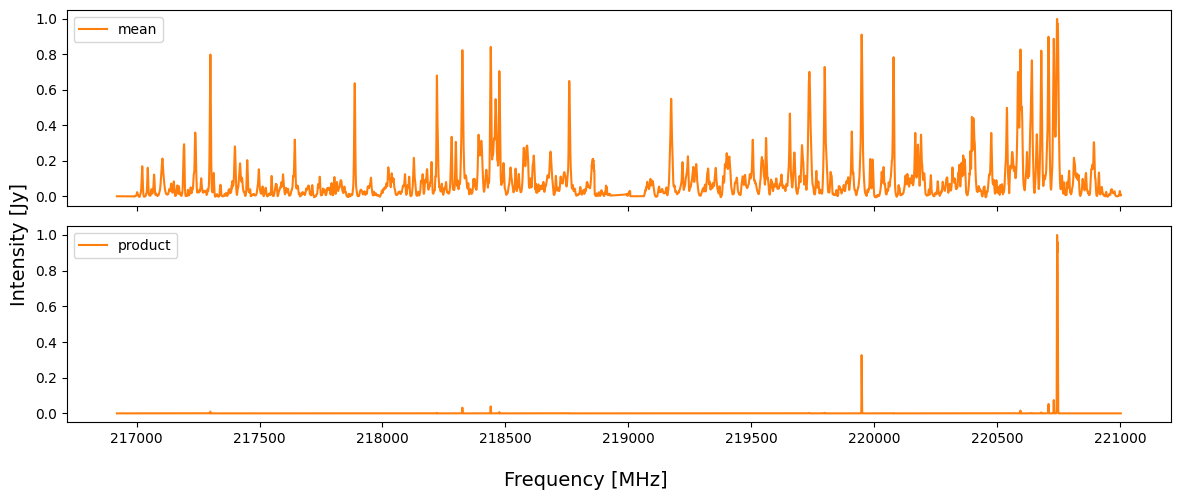

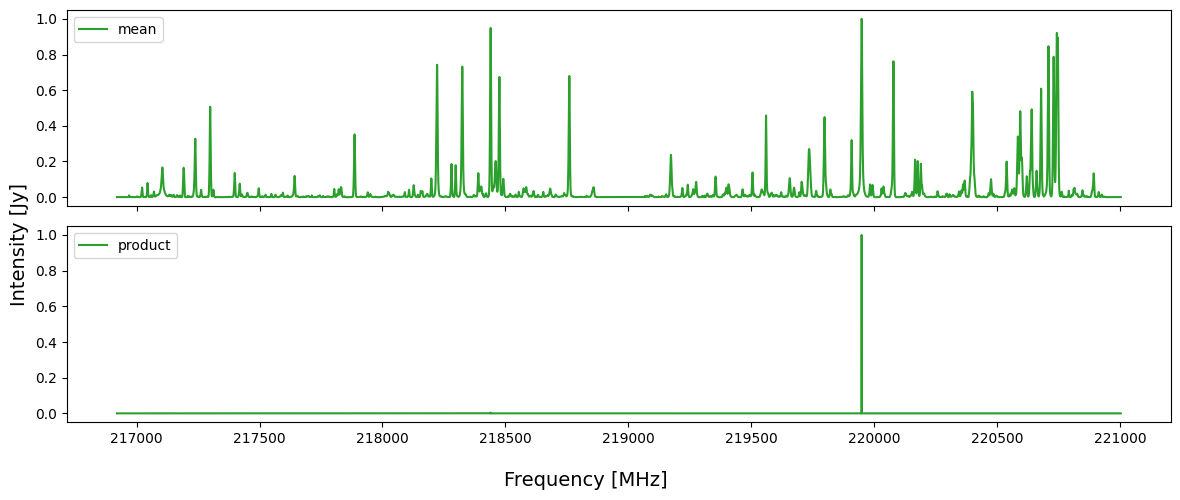

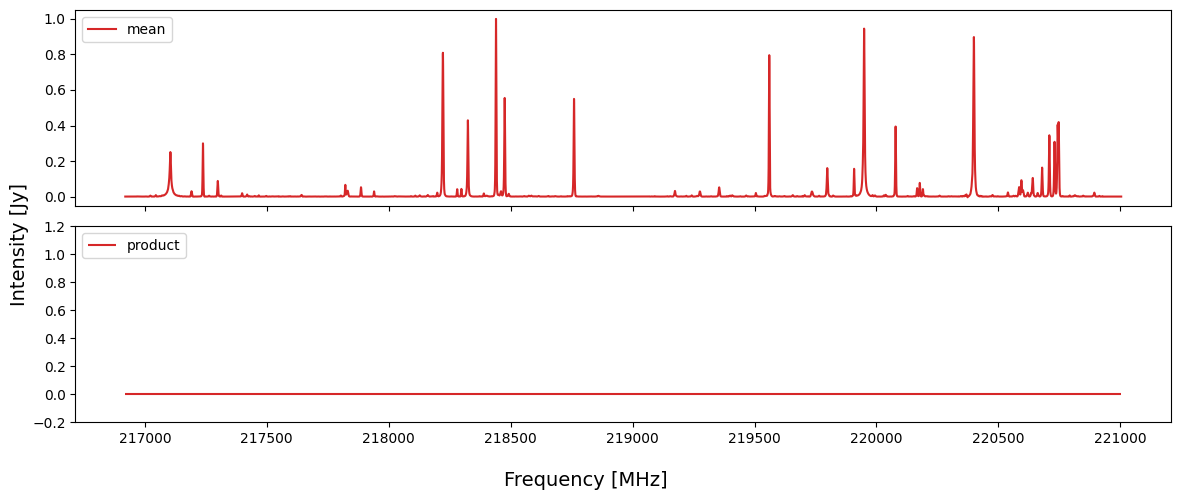

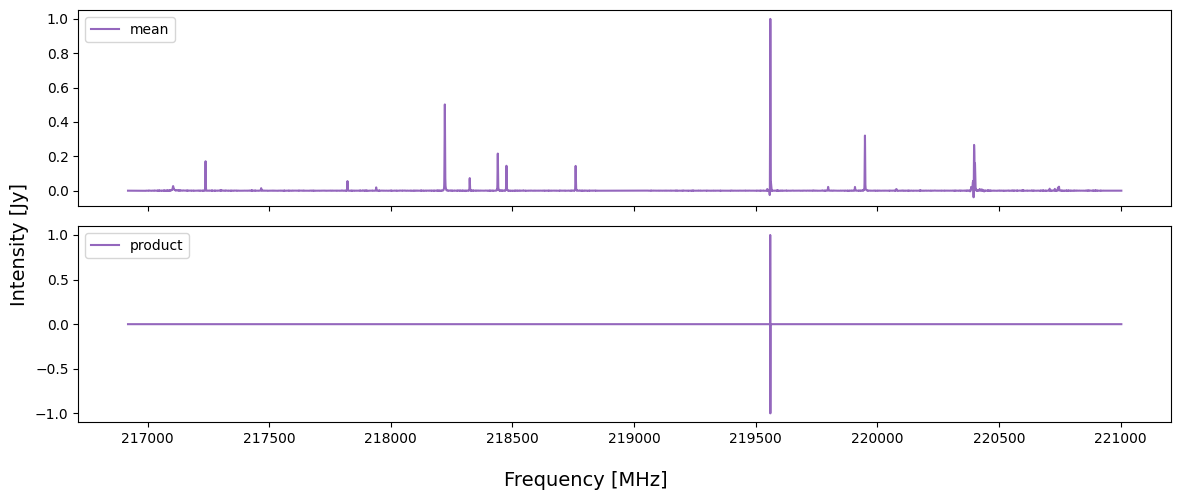

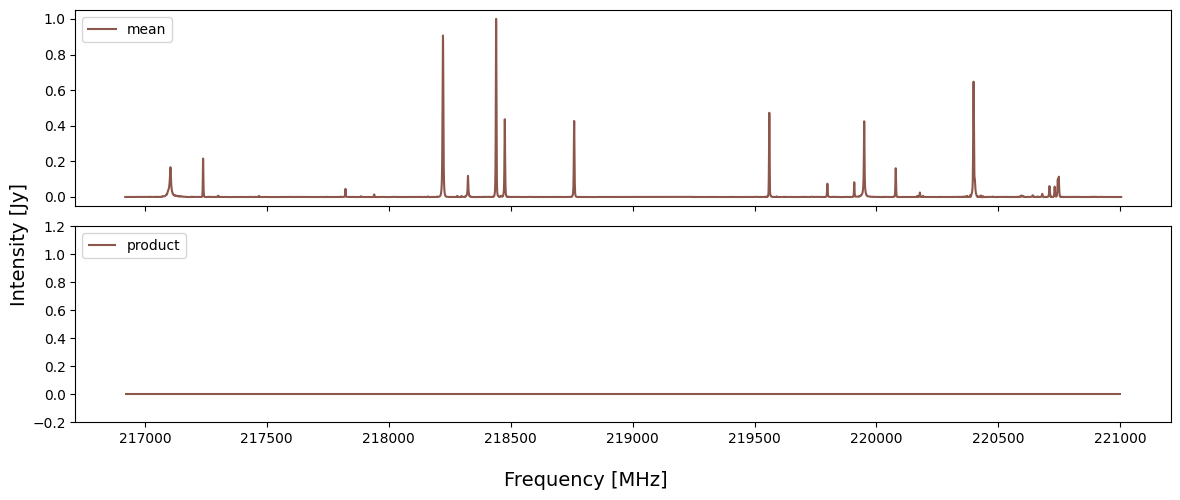

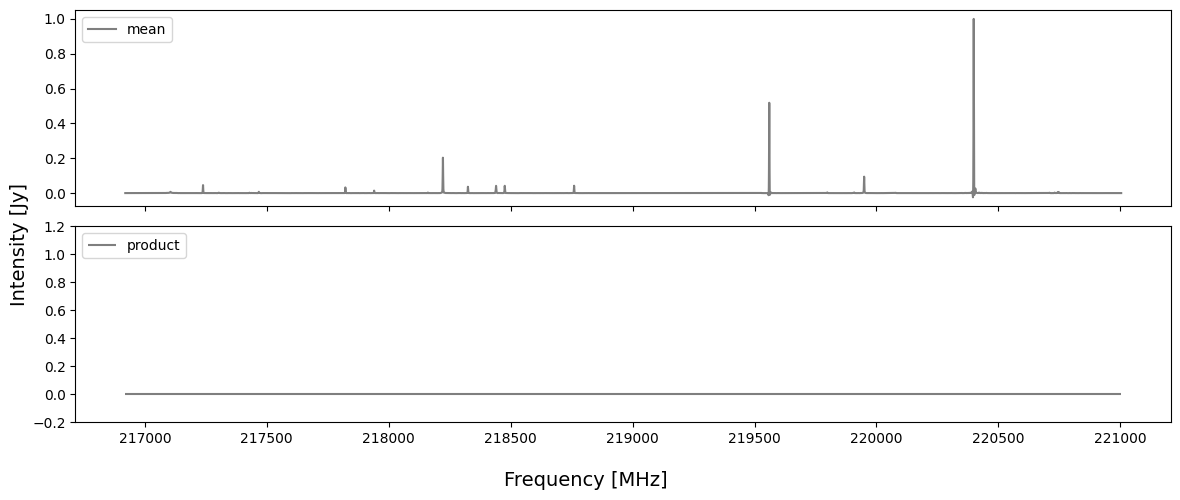

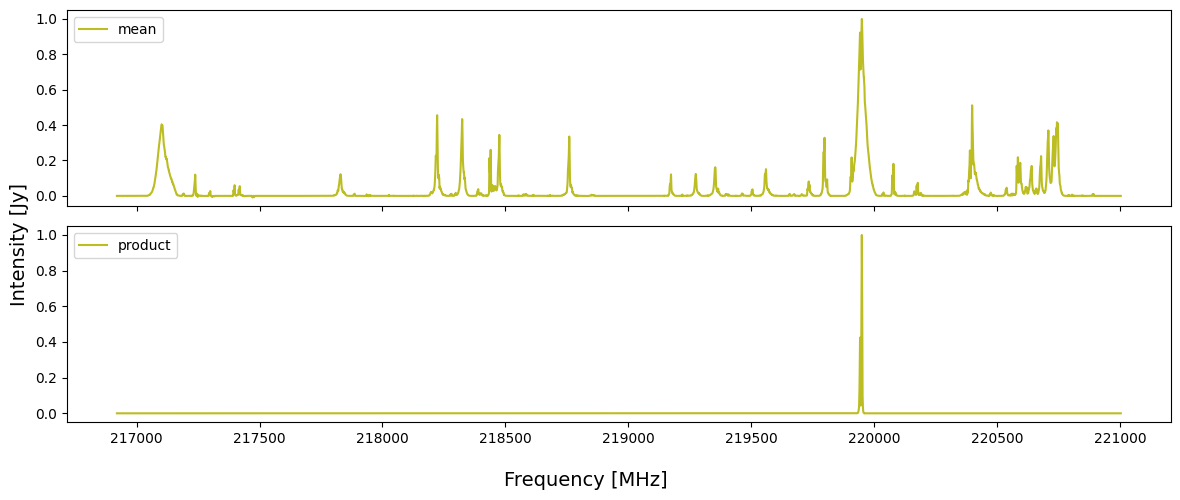

In [ ]:
for label in np.unique(labels_10):
    if label == -1:
        continue
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 5))

    mean = subtraction_signals[labels_10==label].mean(axis=0)
    mean /= np.max(mean)
    mean[mean < -1] = -1

    # ax[0].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    ax[0].plot(freq, mean, color=colors[label], label="mean")
    ax[0].legend(loc="upper left")

    prod_signal = subtraction_signals[labels_10==label].prod(axis=0)
    
    # ax[1].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    if np.any(prod_signal > 0):
        prod_signal /= np.max(prod_signal)
        prod_signal[prod_signal < -1] = -1
        ax[1].plot(freq, prod_signal, color=colors[label], label="product")
    else:
        ax[1].hlines(y=0, xmin=min(freq), xmax=max(freq), color=colors[label], label="product")
        ax[1].set_ylim((-0.2, 1.2))

    ax[1].legend(loc="upper left")
    fig.supxlabel('Frequency [MHz]', fontsize=14)
    fig.supylabel('Intensity [Jy]', fontsize=14)
    fig.tight_layout()
    fig.savefig(f'results/analysis/cluster_{label}_composition.pdf')
    plt.show()

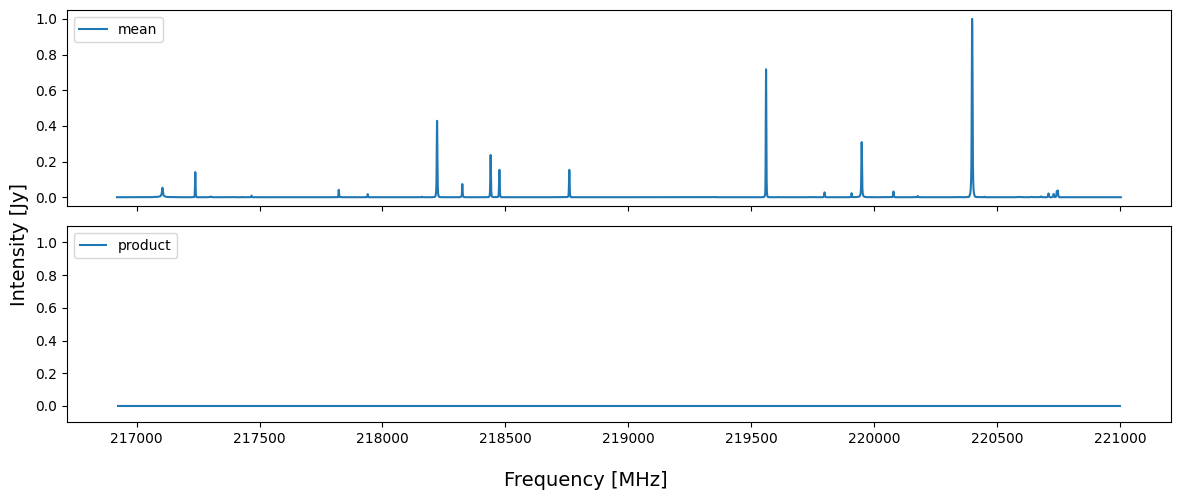

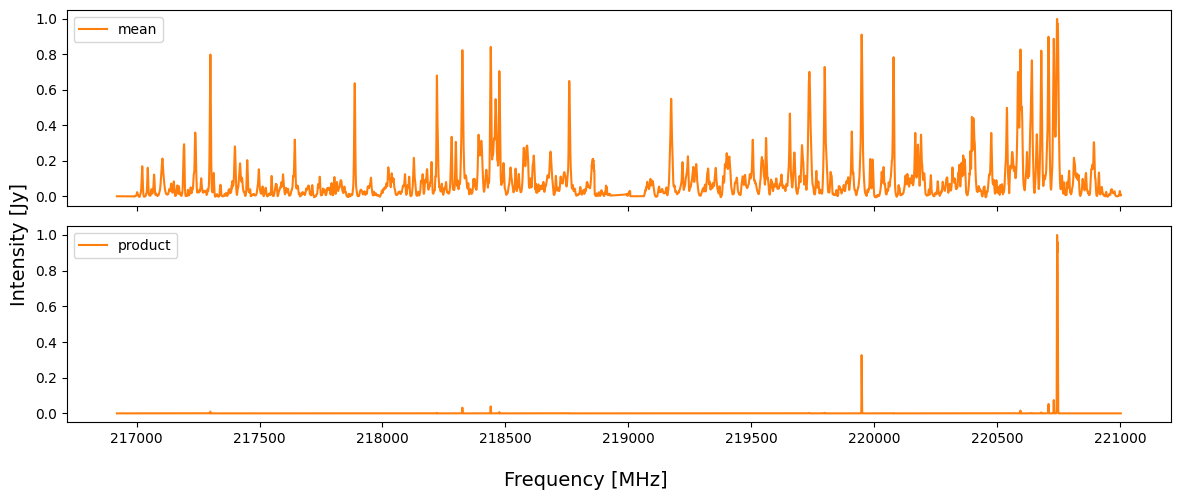

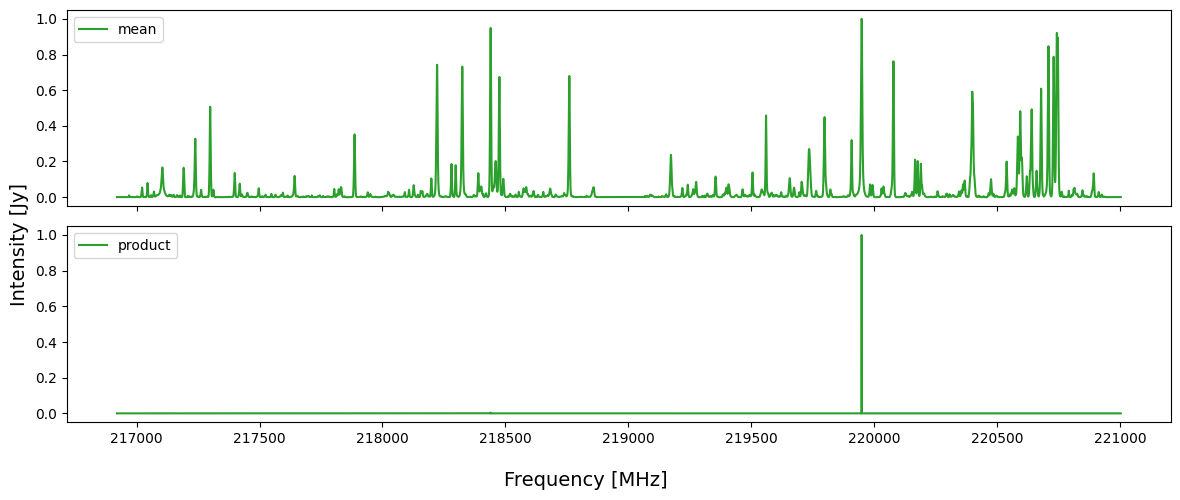

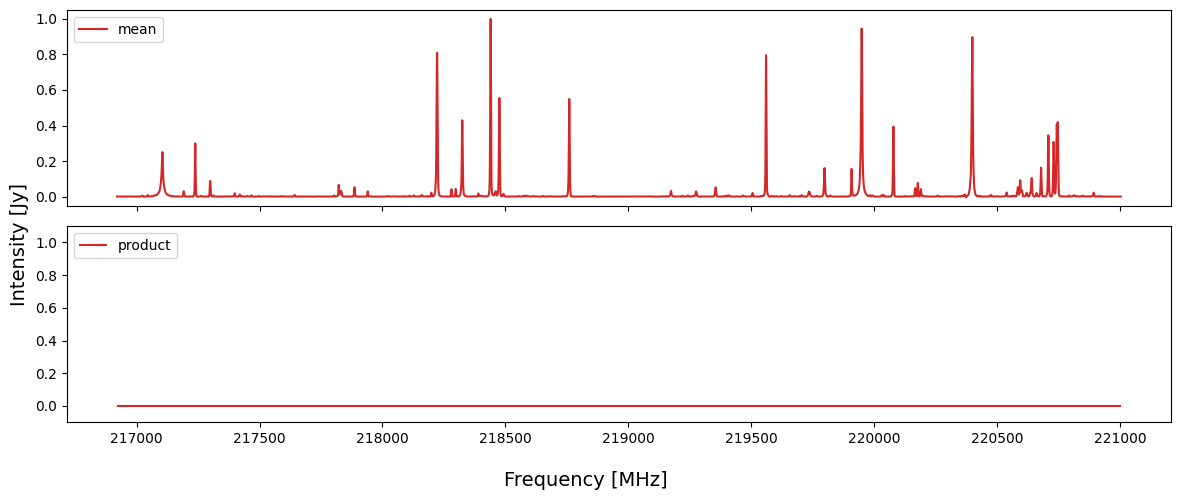

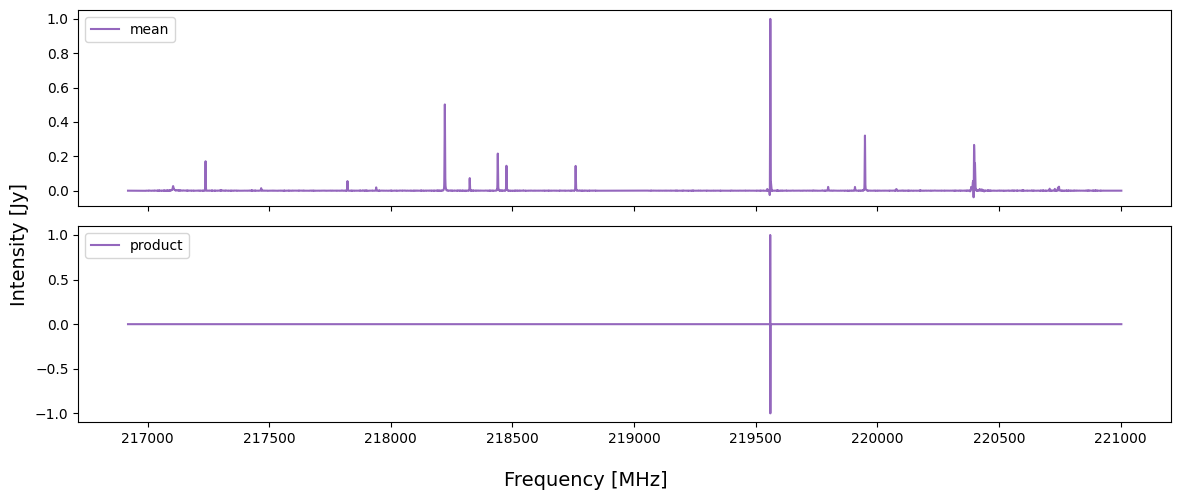

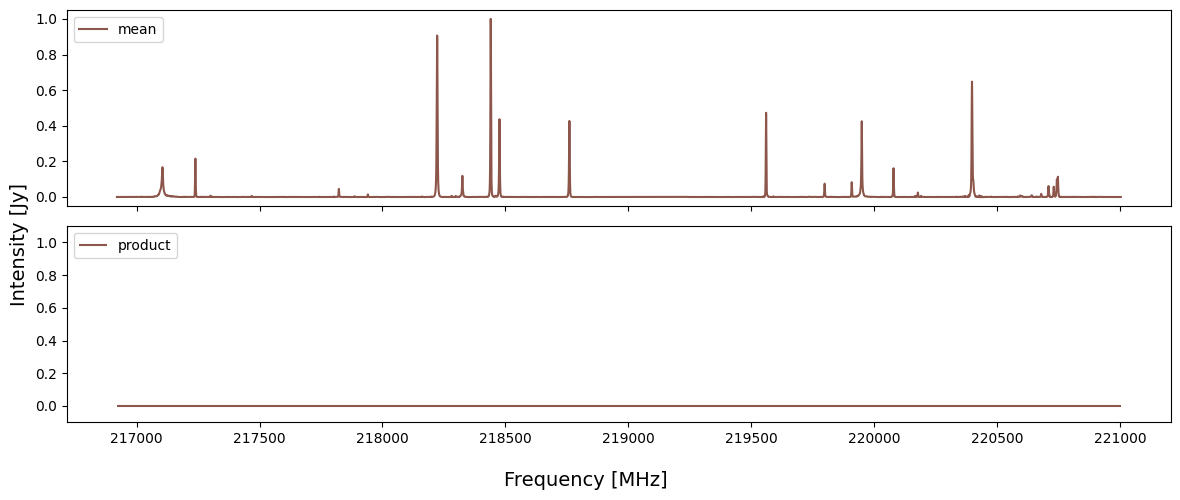

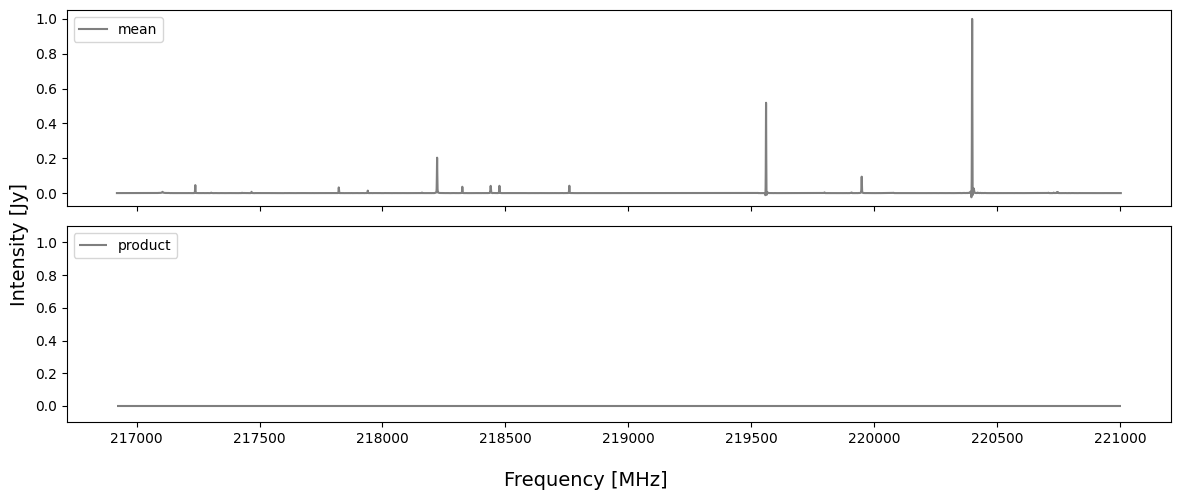

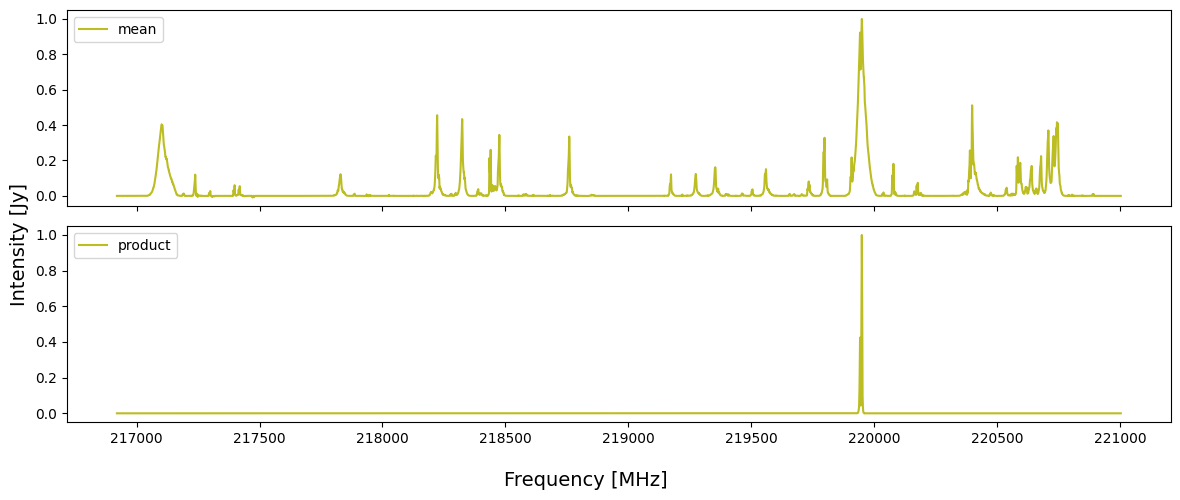

In [ ]:
for label in np.unique(labels_10):
    if label == -1:
        continue
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 5))

    mean = subtraction_signals[labels_10==label].mean(axis=0)
    mean /= np.max(mean)
    mean[mean < -1] = -1

    # ax[0].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    ax[0].plot(freq, mean, color=colors[label], label="mean")
    ax[0].legend(loc="upper left")

    prod_signal = subtraction_signals[labels_10==label].prod(axis=0)
    
    # ax[1].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    if np.any(prod_signal > 0):
        prod_signal /= np.max(prod_signal)
        prod_signal[prod_signal < -1] = -1
        ax[1].plot(freq, prod_signal, color=colors[label], label="product")
    else:
        ax[1].hlines(y=0, xmin=min(freq), xmax=max(freq), color=colors[label], label="product")
        ax[1].set_ylim((-0.1, 1.1))
        ax[1].set_yticks(ticks=np.arange(0, 1.2, 0.2))

    ax[1].legend(loc="upper left")
    fig.supxlabel('Frequency [MHz]', fontsize=14)
    fig.supylabel('Intensity [Jy]', fontsize=14)
    fig.tight_layout()
    fig.savefig(f'results/analysis/cluster_{label}_composition.pdf')
    plt.show()

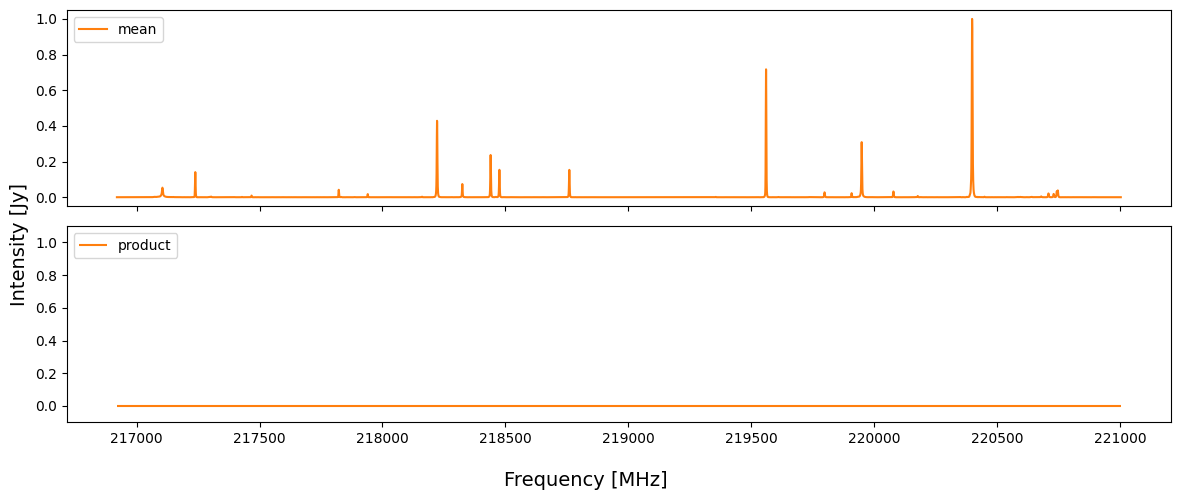

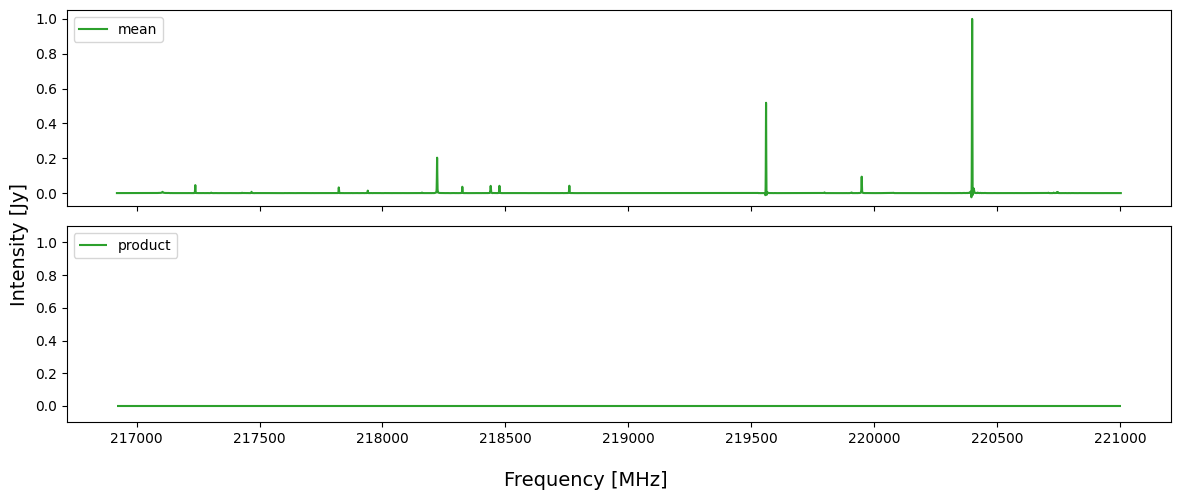

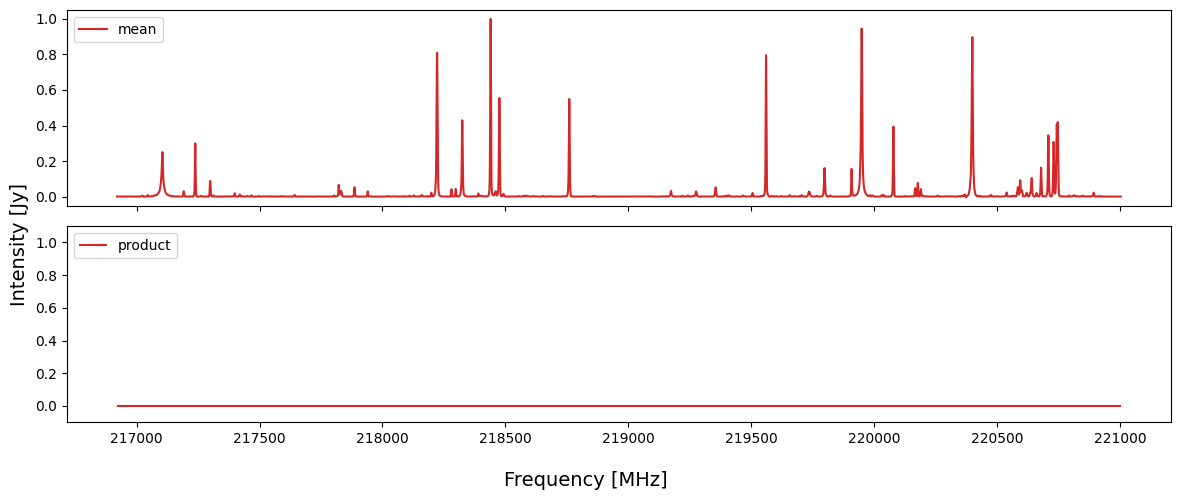

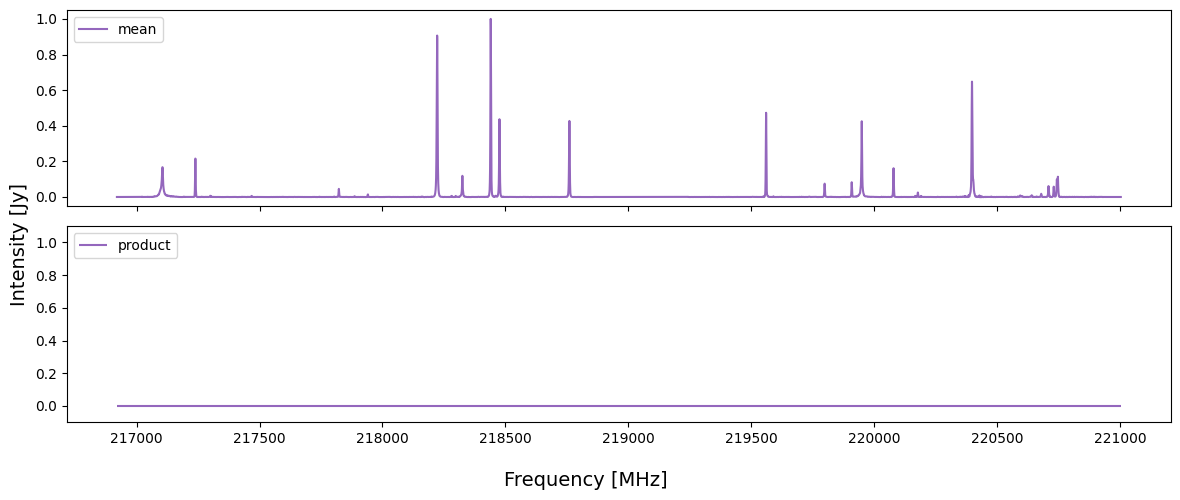

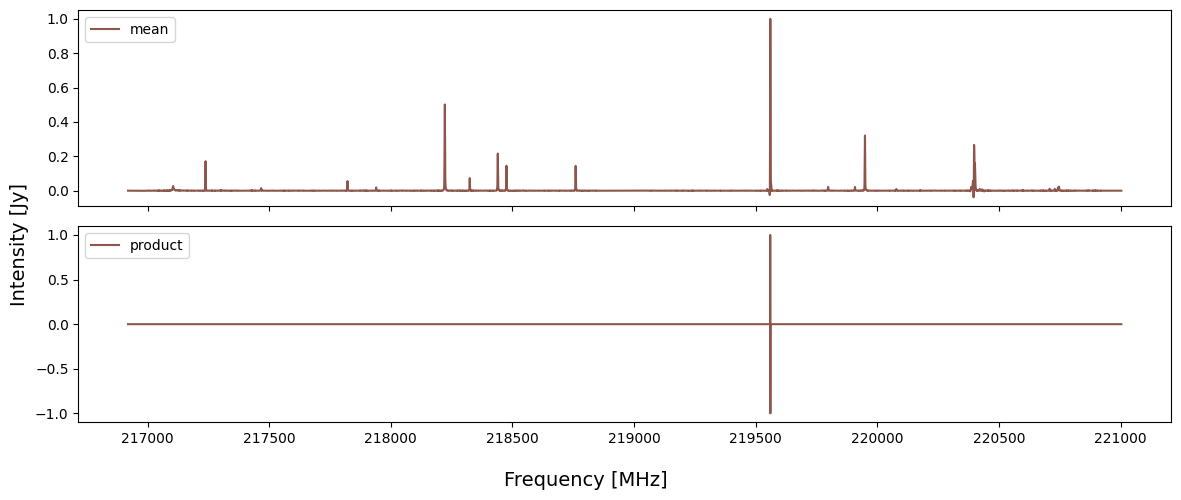

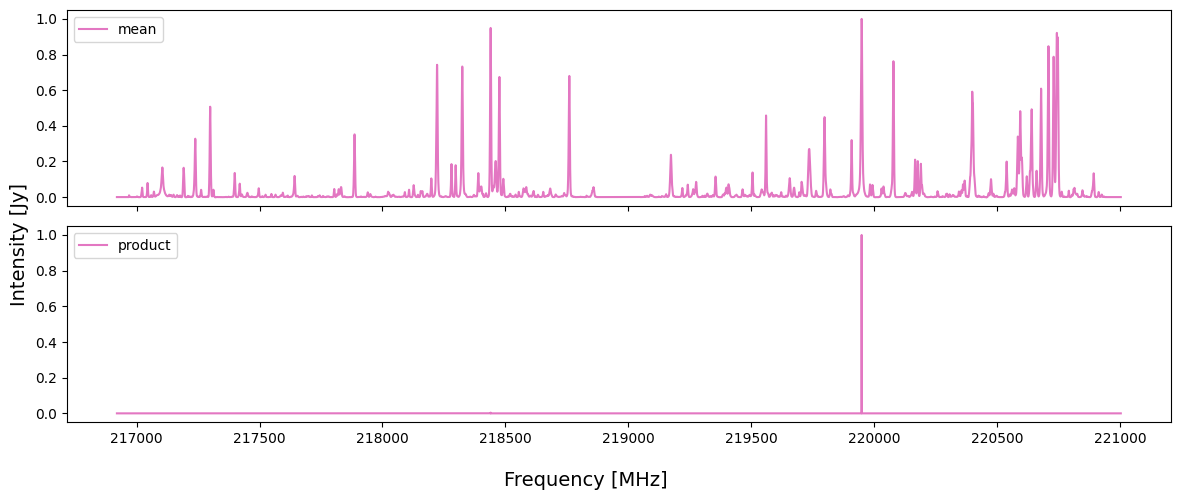

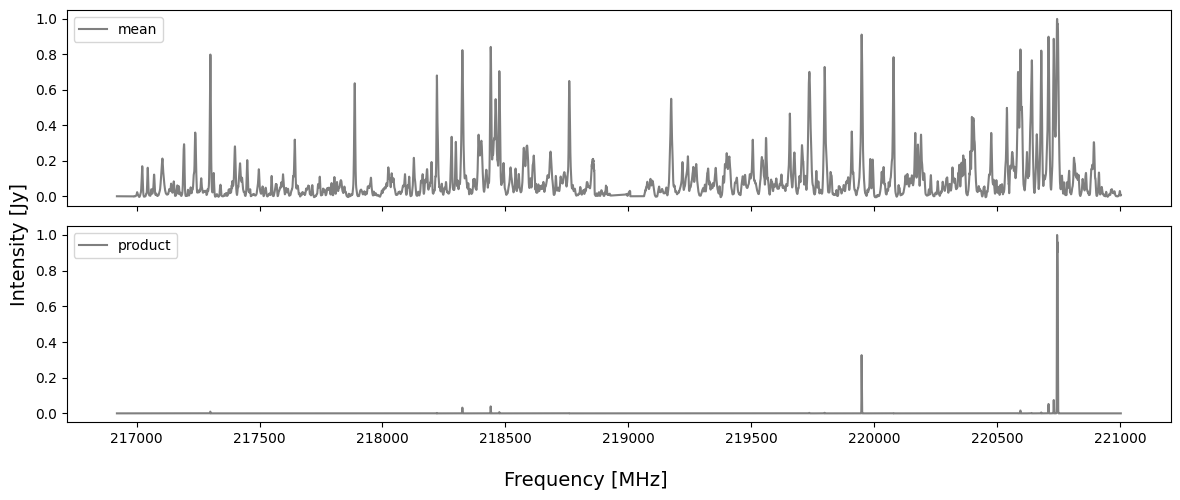

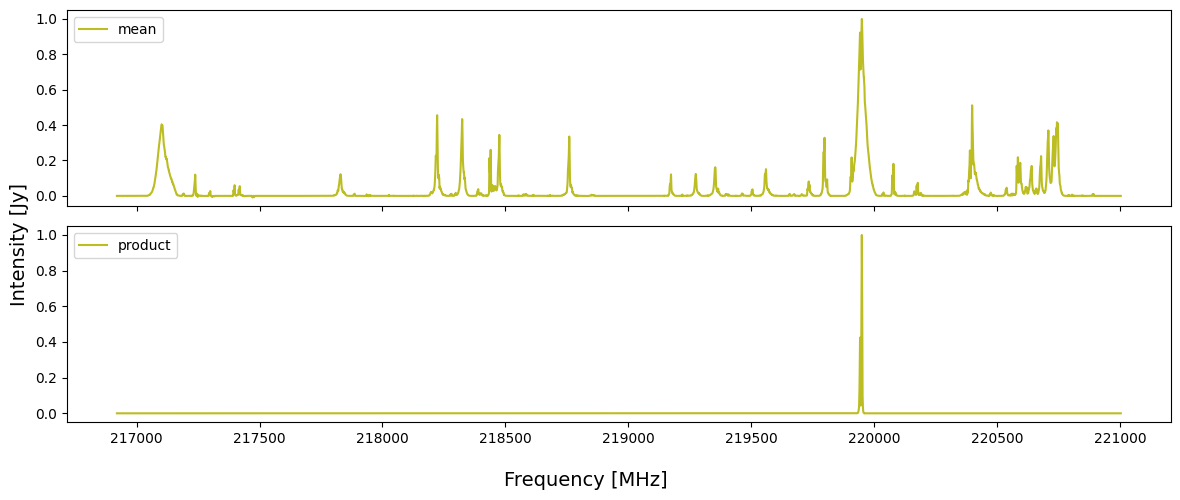

In [ ]:
n = 0
for label in np.unique(labels_10)[np.argsort(np.unique(labels_10, return_counts=True)[1])[::-1]]:
    if label == -1:
        continue
    n += 1
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 5))

    mean = subtraction_signals[labels_10==label].mean(axis=0)
    mean /= np.max(mean)
    mean[mean < -1] = -1

    # ax[0].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    ax[0].plot(freq, mean, color=colors[n], label="mean")
    ax[0].legend(loc="upper left")

    prod_signal = subtraction_signals[labels_10==label].prod(axis=0)
    
    # ax[1].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    if np.any(prod_signal > 0):
        prod_signal /= np.max(prod_signal)
        prod_signal[prod_signal < -1] = -1
        ax[1].plot(freq, prod_signal, color=colors[n], label="product")
    else:
        ax[1].hlines(y=0, xmin=min(freq), xmax=max(freq), color=colors[n], label="product")
        ax[1].set_ylim((-0.1, 1.1))
        ax[1].set_yticks(ticks=np.arange(0, 1.2, 0.2))

    ax[1].legend(loc="upper left")
    fig.supxlabel('Frequency [MHz]', fontsize=14)
    fig.supylabel('Intensity [Jy]', fontsize=14)
    fig.tight_layout()
    fig.savefig(f'results/analysis/cluster_{label}_composition.pdf')
    plt.show()

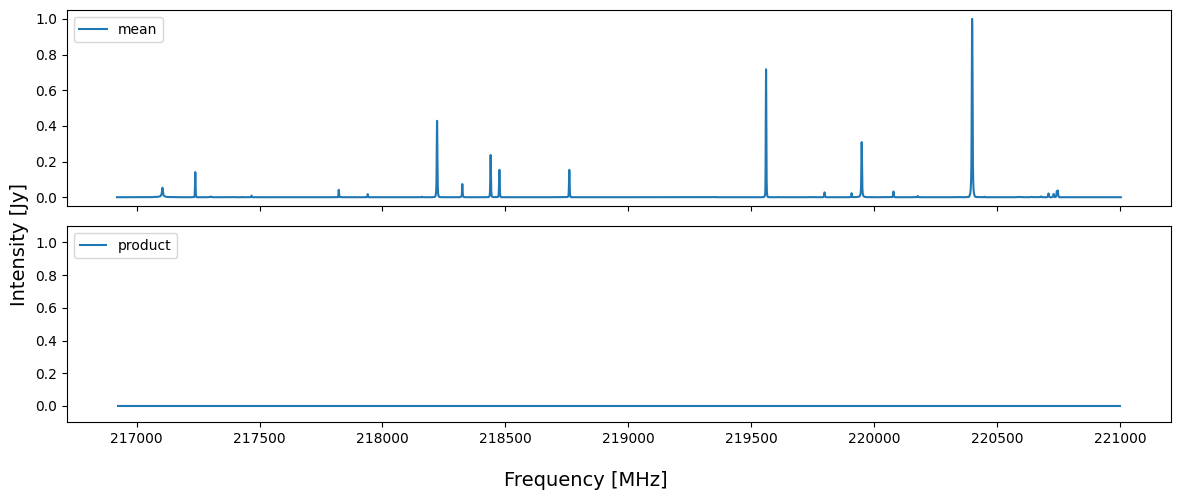

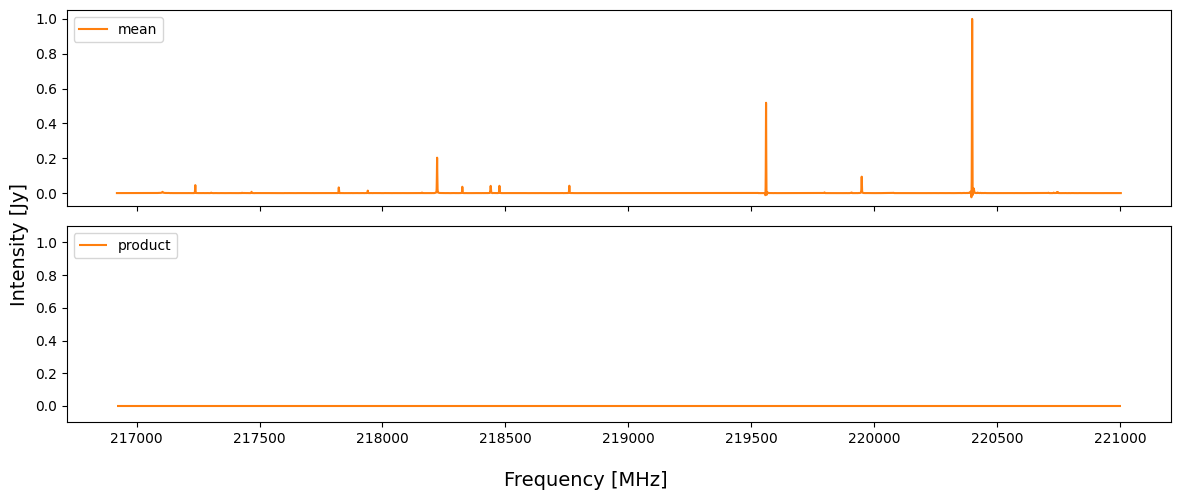

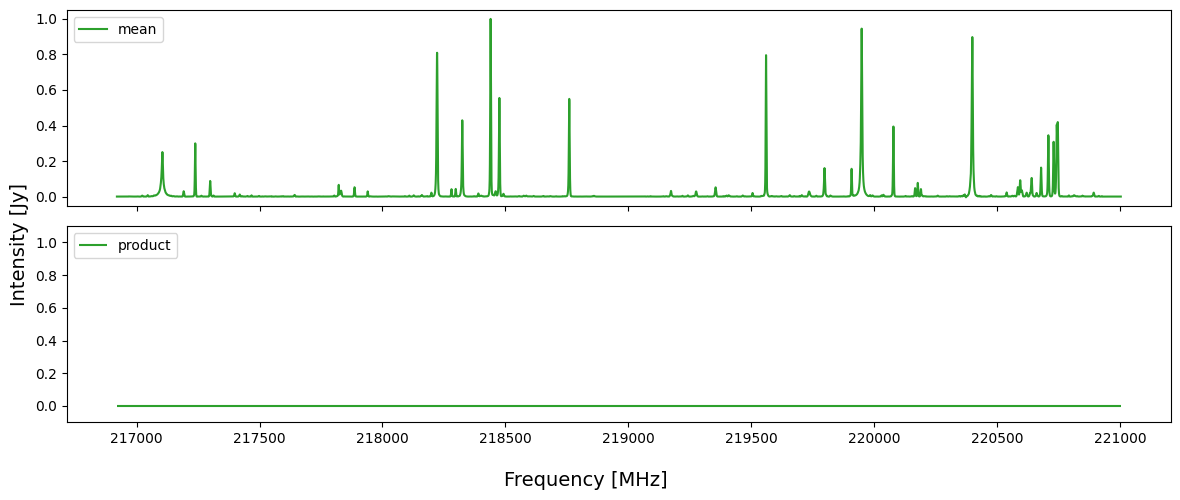

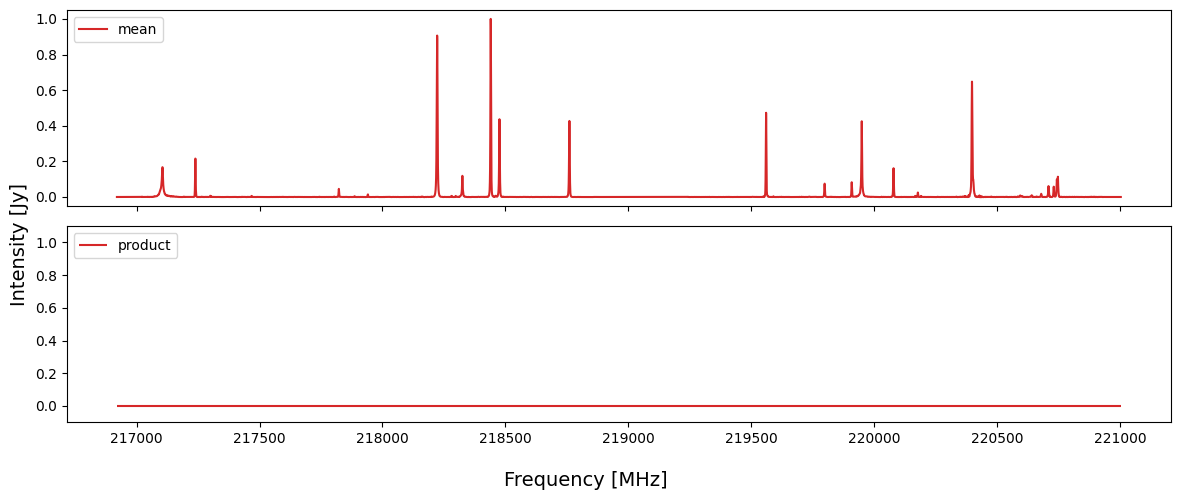

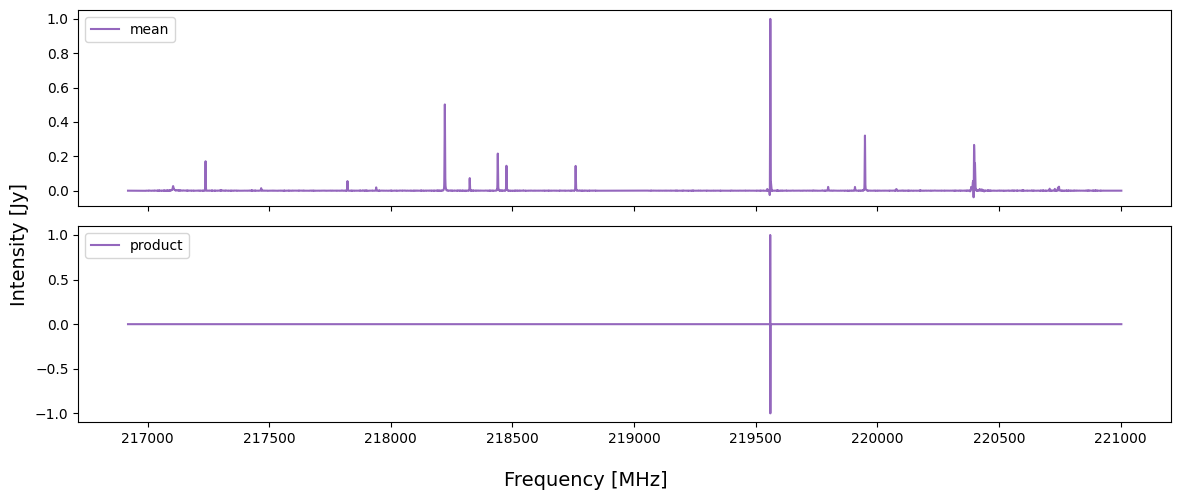

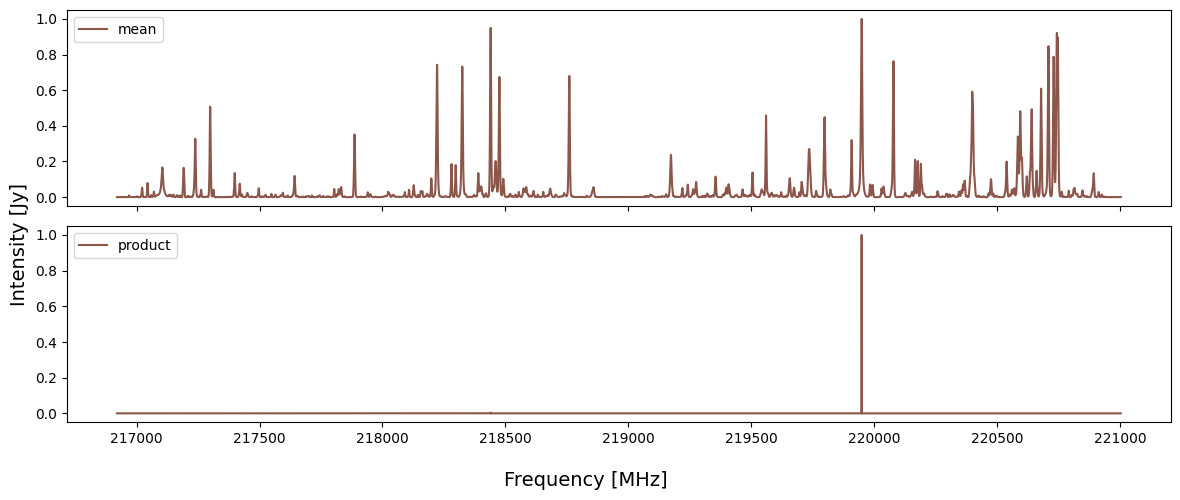

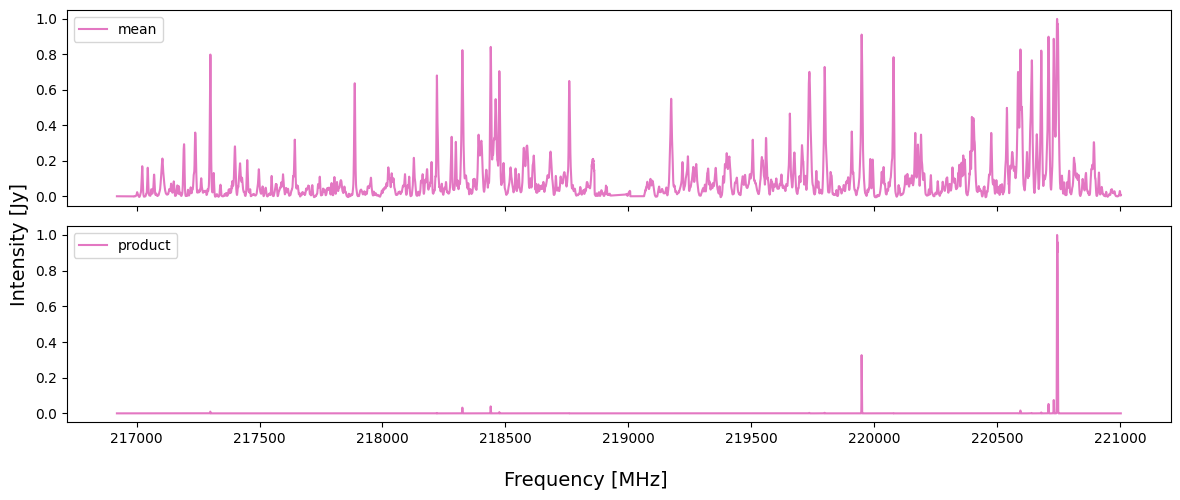

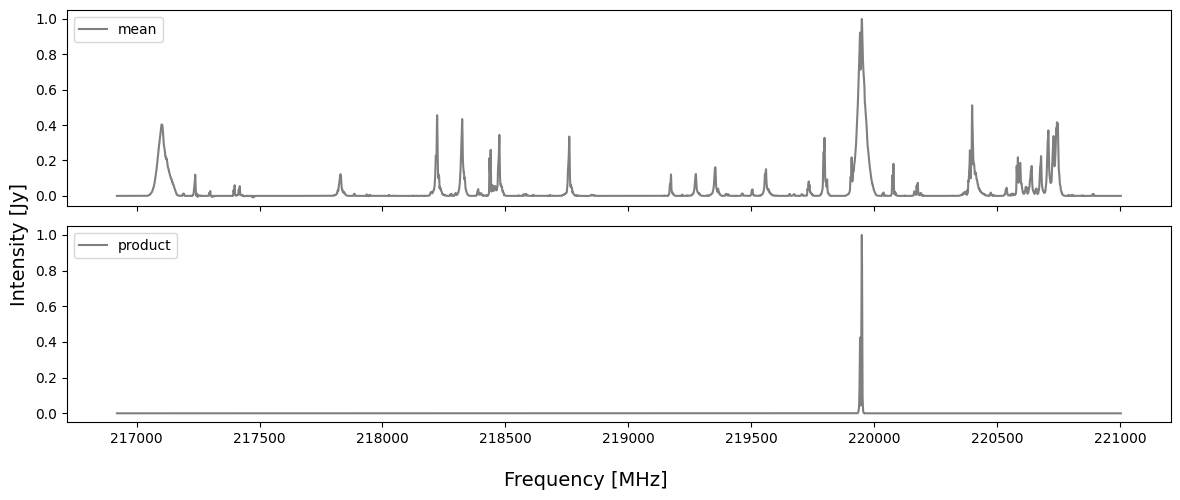

In [ ]:
n = 0
for label in np.unique(labels_10)[np.argsort(np.unique(labels_10, return_counts=True)[1])[::-1]]:
    if label == -1:
        continue
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 5))

    mean = subtraction_signals[labels_10==label].mean(axis=0)
    mean /= np.max(mean)
    mean[mean < -1] = -1

    # ax[0].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    ax[0].plot(freq, mean, color=colors[n], label="mean")
    ax[0].legend(loc="upper left")

    prod_signal = subtraction_signals[labels_10==label].prod(axis=0)
    
    # ax[1].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    if np.any(prod_signal > 0):
        prod_signal /= np.max(prod_signal)
        prod_signal[prod_signal < -1] = -1
        ax[1].plot(freq, prod_signal, color=colors[n], label="product")
    else:
        ax[1].hlines(y=0, xmin=min(freq), xmax=max(freq), color=colors[n], label="product")
        ax[1].set_ylim((-0.1, 1.1))
        ax[1].set_yticks(ticks=np.arange(0, 1.2, 0.2))

    ax[1].legend(loc="upper left")
    fig.supxlabel('Frequency [MHz]', fontsize=14)
    fig.supylabel('Intensity [Jy]', fontsize=14)
    fig.tight_layout()
    fig.savefig(f'results/analysis/cluster_{label}_composition.pdf')
    plt.show()
    n += 1

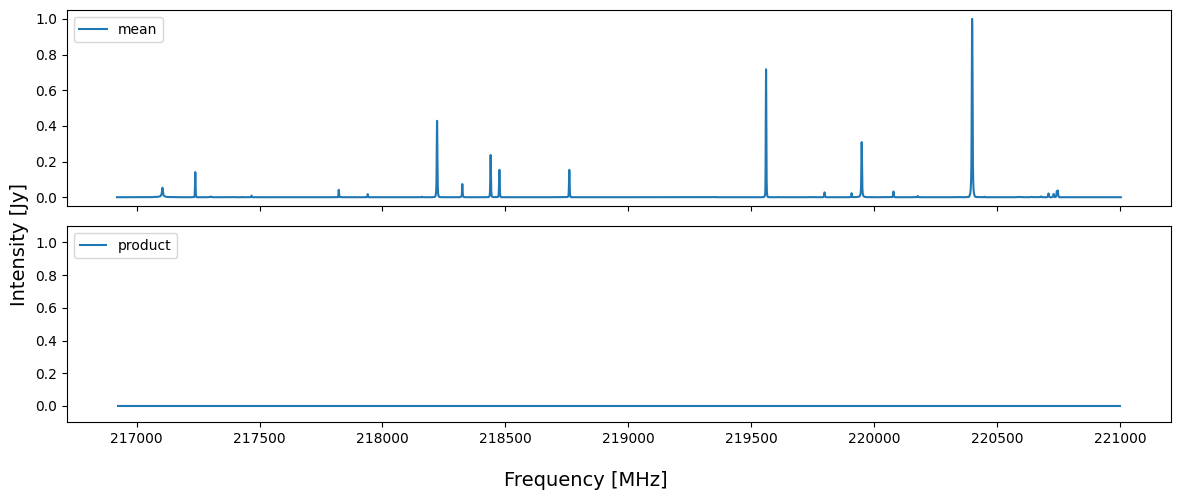

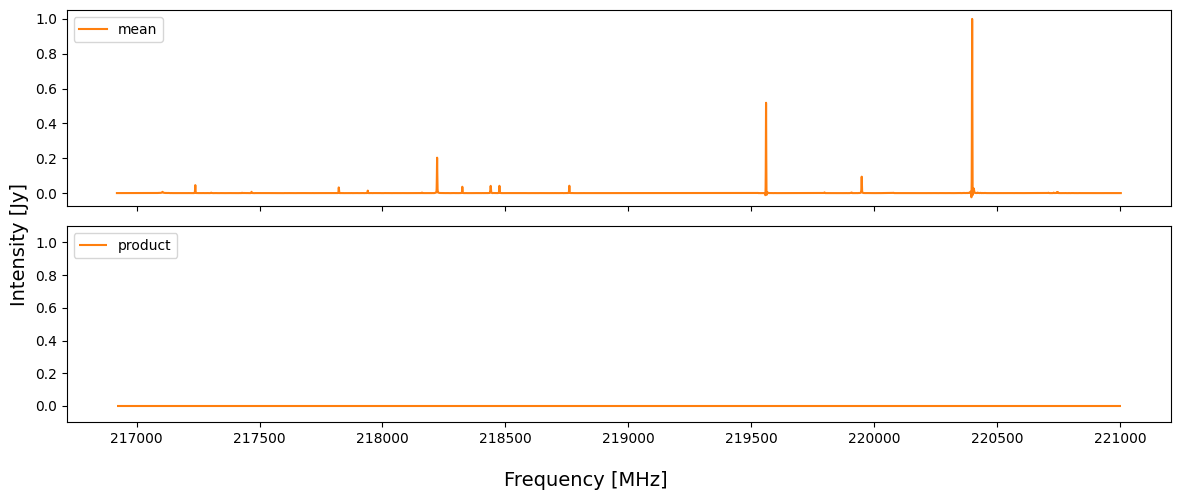

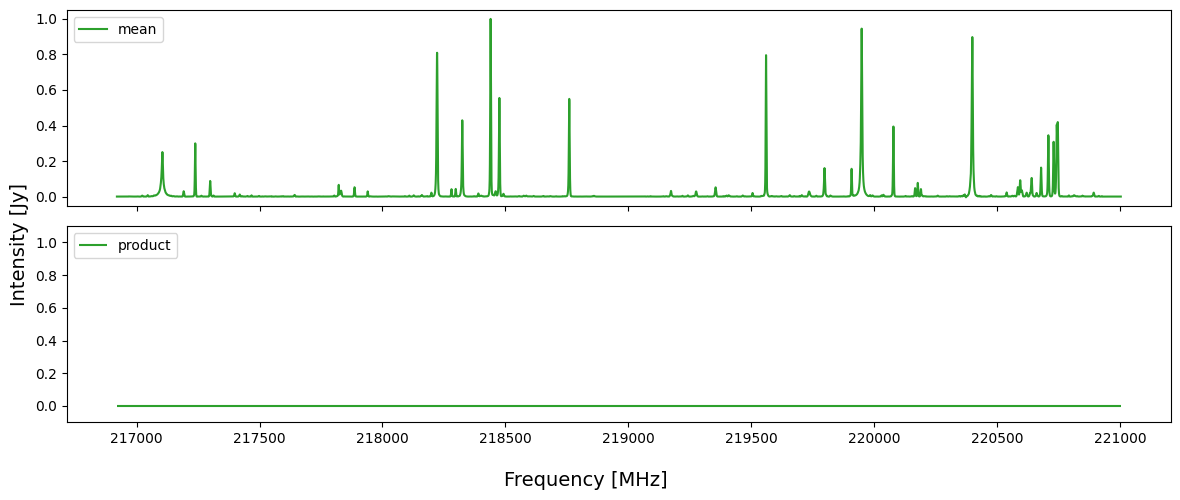

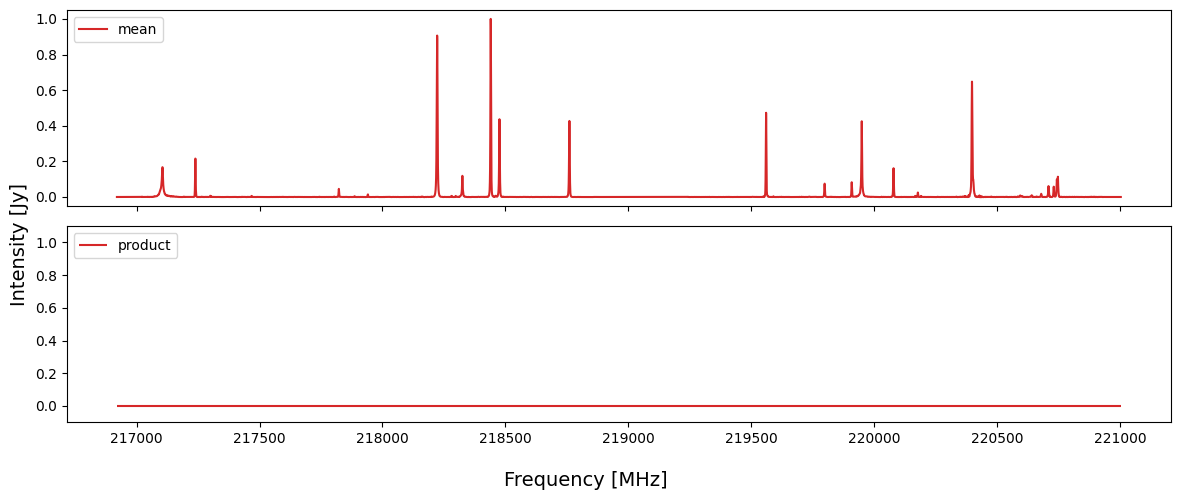

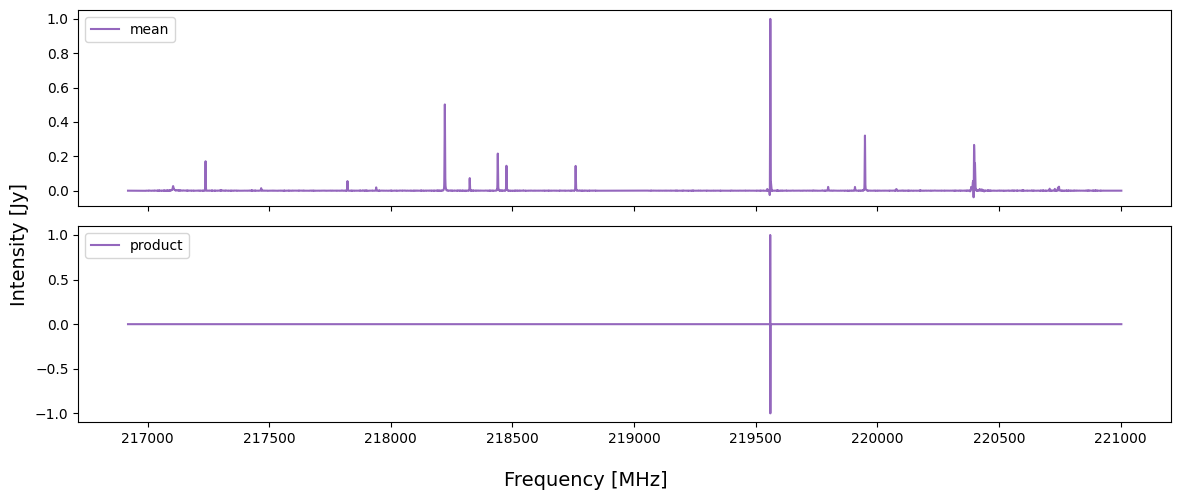

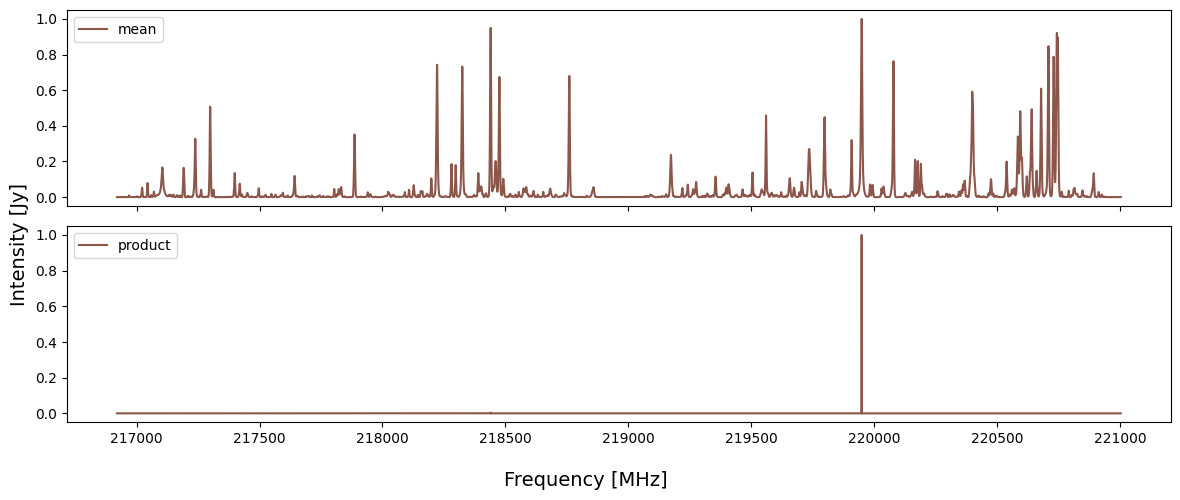

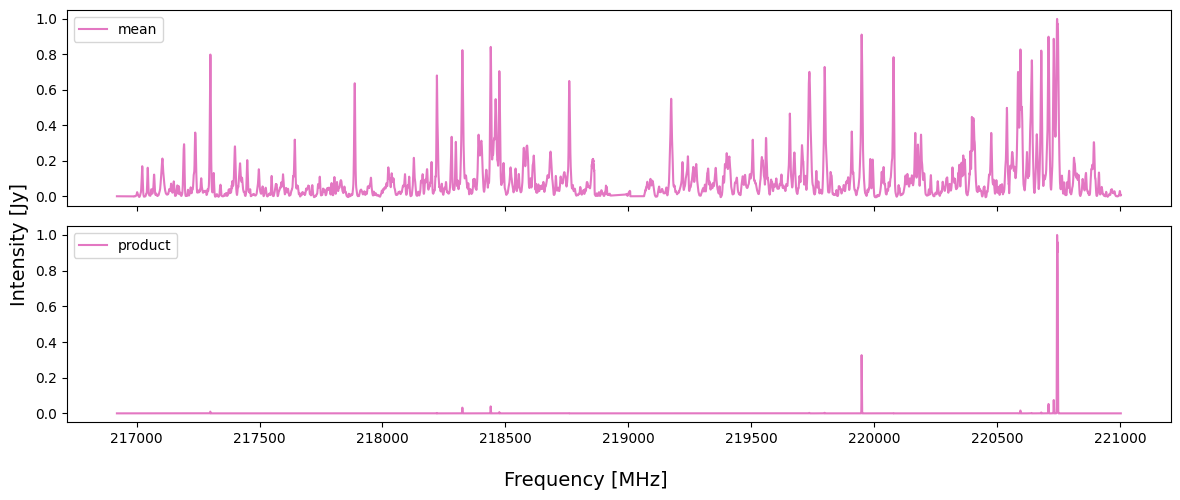

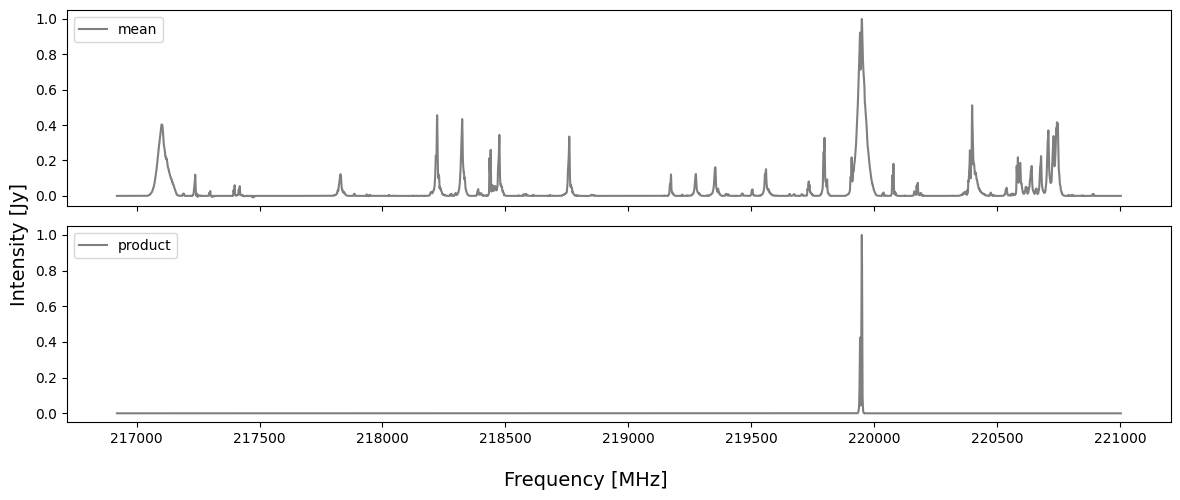

In [ ]:
n = 0
for label in np.unique(labels_10)[np.argsort(np.unique(labels_10, return_counts=True)[1])[::-1]]:
    if label == -1:
        continue
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 5))

    mean = subtraction_signals[labels_10==label].mean(axis=0)
    mean /= np.max(mean)
    mean[mean < -1] = -1

    # ax[0].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    ax[0].plot(freq, mean, color=colors[n], label="mean")
    ax[0].legend(loc="upper left")

    prod_signal = subtraction_signals[labels_10==label].prod(axis=0)
    
    # ax[1].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    if np.any(prod_signal > 0):
        prod_signal /= np.max(prod_signal)
        prod_signal[prod_signal < -1] = -1
        ax[1].plot(freq, prod_signal, color=colors[n], label="product")
    else:
        ax[1].hlines(y=0, xmin=min(freq), xmax=max(freq), color=colors[n], label="product")
        ax[1].set_ylim((-0.1, 1.1))
        ax[1].set_yticks(ticks=np.arange(0, 1.2, 0.2))

    ax[1].legend(loc="upper left")
    fig.supxlabel('Frequency [MHz]', fontsize=14)
    fig.supylabel('Intensity [Jy]', fontsize=14)
    fig.tight_layout()
    fig.savefig(f'results/analysis/cluster_{n}_composition.pdf')
    plt.show()
    n += 1

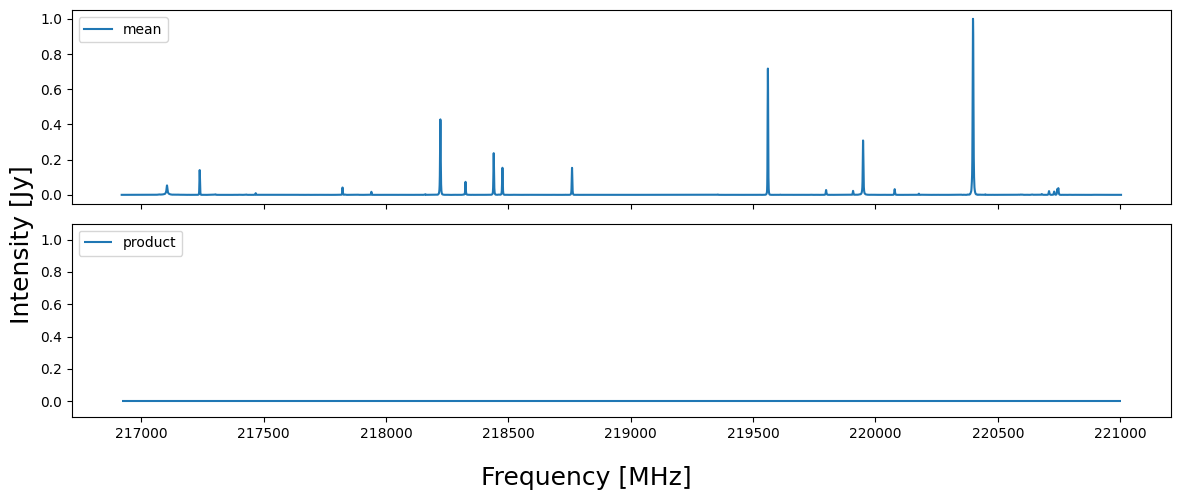

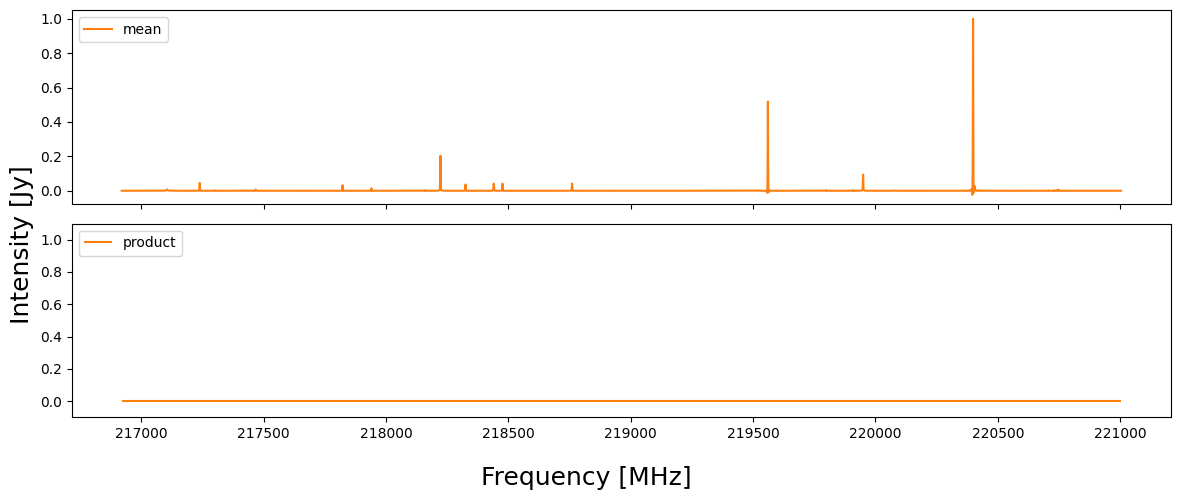

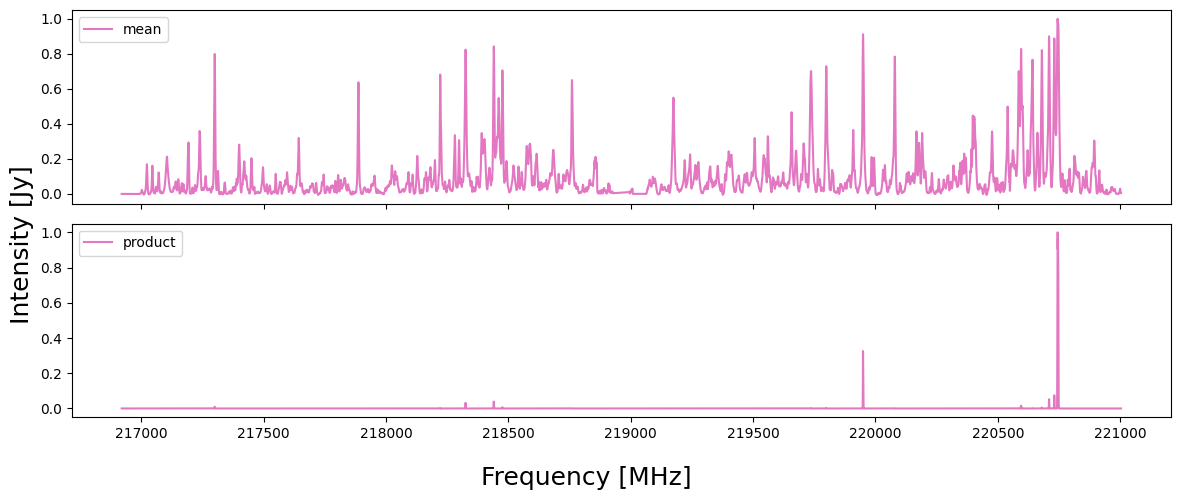

In [ ]:
n = 0
for label in np.unique(labels_10)[np.argsort(np.unique(labels_10, return_counts=True)[1])[::-1]]:
    if label == -1:
        continue
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 5))

    mean = subtraction_signals[labels_10==label].mean(axis=0)
    mean /= np.max(mean)
    mean[mean < -1] = -1

    # ax[0].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    ax[0].plot(freq, mean, color=colors[n], label="mean")
    ax[0].legend(loc="upper left")

    prod_signal = subtraction_signals[labels_10==label].prod(axis=0)
    
    # ax[1].plot(freq, subtraction_signals[labels_10 == label].T, color="grey", alpha=0.2)
    if np.any(prod_signal > 0):
        prod_signal /= np.max(prod_signal)
        prod_signal[prod_signal < -1] = -1
        ax[1].plot(freq, prod_signal, color=colors[n], label="product")
    else:
        ax[1].hlines(y=0, xmin=min(freq), xmax=max(freq), color=colors[n], label="product")
        ax[1].set_ylim((-0.1, 1.1))
        ax[1].set_yticks(ticks=np.arange(0, 1.2, 0.2))

    ax[1].legend(loc="upper left")
    fig.supxlabel('Frequency [MHz]', fontsize=18)
    fig.supylabel('Intensity [Jy]', fontsize=18)
    fig.tight_layout()
    fig.savefig(f'results/analysis/cluster_{n}_composition.pdf')
    plt.show()
    n += 1

In [ ]:
n = 0
for label in np.unique(labels_10)[np.argsort(np.unique(labels_10, return_counts=True)[1])[::-1]]:
    if label == -1:
        continue
    prod_signal = subtraction_signals[labels_10==label].prod(axis=0)
    print(f"Cluster {n}:")
    print(freq[np.where(prod_signal > 0)])
    n += 1

Cluster 0:
[]
Cluster 1:
[]
Cluster 2:
[]
Cluster 3:
[]
Cluster 4:
[218220.52589304 218221.12897778 218221.33000603 218222.13411901
 218222.33514726 218222.53617551 218223.13926025 218223.34028849
 218223.54131674 218223.74234498 218439.64668167 218439.84770991
 218475.42970953 218476.03279427 218476.23382252 218759.88467825
 218760.28673475 219558.26266982 219558.46385801 219559.26861078
 219559.46979897 219559.67098716 219559.87217535 219560.8781163
 219561.07930449 219561.28049268 219561.68286906 219562.08524544
 220395.20554272 220395.80910729 220396.61386005 220397.21742462
 220397.8209892  220398.82693015 220399.02811834 220399.22930653
 220399.43049472 220399.8328711  220400.03405929 220400.23524748
 220400.43643567 220400.63762386 220400.83881205 220401.04000024
 220401.64356482 220401.84475301]
Cluster 5:
[217103.81398404 217104.01501228 217104.21604053 217104.41706878
 217104.61809702 217104.81912527 217105.02015352 217105.22118176
 217105.42221001 217105.62323826 217236.8946

In [ ]:
from scipy.signal import find_peaks
n = 0
for label in np.unique(labels_10)[np.argsort(np.unique(labels_10, return_counts=True)[1])[::-1]]:
    if label == -1:
        continue
    prod_signal = subtraction_signals[labels_10==label].prod(axis=0)
    peaks, properties = find_peaks(prod_signal, height=0.01)
    print(f"Cluster {n}:")
    print(freq[peaks])
    n += 1

Cluster 0:
[]
Cluster 1:
[]
Cluster 2:
[]
Cluster 3:
[]
Cluster 4:
[]
Cluster 5:
[]
Cluster 6:
[]
Cluster 7:
[]


In [ ]:
from scipy.signal import find_peaks
n = 0
for label in np.unique(labels_10)[np.argsort(np.unique(labels_10, return_counts=True)[1])[::-1]]:
    if label == -1:
        continue
    prod_signal = subtraction_signals[labels_10==label].prod(axis=0)
    if np.any(prod_signal > 0):
        prod_signal /= np.max(prod_signal)
    peaks, properties = find_peaks(prod_signal, height=0.01)
    print(f"Cluster {n}:")
    print(peaks)
    n += 1

Cluster 0:
[]
Cluster 1:
[]
Cluster 2:
[]
Cluster 3:
[]
Cluster 4:
[12824]
Cluster 5:
[14759]
Cluster 6:
[ 6990  7563 14758 17968 18537 18643 18711 18718]
Cluster 7:
[14727 14762]


In [ ]:
from scipy.signal import find_peaks
n = 0
for label in np.unique(labels_10)[np.argsort(np.unique(labels_10, return_counts=True)[1])[::-1]]:
    if label == -1:
        continue
    prod_signal = subtraction_signals[labels_10==label].prod(axis=0)
    if np.any(prod_signal > 0):
        prod_signal /= np.max(prod_signal)
    peaks, properties = find_peaks(prod_signal, height=0.01)
    print(f"Cluster {n}:")
    print(freq[peaks])
    n += 1

Cluster 0:
[]
Cluster 1:
[]
Cluster 2:
[]
Cluster 3:
[]
Cluster 4:
[219559.87217535]
Cluster 5:
[219949.17132416]
Cluster 6:
[218324.85955295 218440.04873816 219948.97013597 220594.78422779
 220709.26030824 220730.58625645 220744.26705341 220745.67537074]
Cluster 7:
[219942.73330206 219949.77488873]


In [ ]:
cluster_composition = {}
n = 0
for label in np.unique(labels_10)[np.argsort(np.unique(labels_10, return_counts=True)[1])[::-1]]:
    if label == -1:
        continue
    mean_signal = subtraction_signals[labels_10==label].mean(axis=0)
    mean_signal /= np.max(mean_signal)


    prod_signal = subtraction_signals[labels_10==label].prod(axis=0)
    if np.any(prod_signal > 0):
        prod_signal /= np.max(prod_signal)
    peaks, properties = find_peaks(prod_signal, height=0.01)
    print(f"Cluster {n}:")
    print(freq[peaks])
    n += 1

Cluster 0:
[]
Cluster 1:
[]
Cluster 2:
[]
Cluster 3:
[]
Cluster 4:
[219559.87217535]
Cluster 5:
[219949.17132416]
Cluster 6:
[218324.85955295 218440.04873816 219948.97013597 220594.78422779
 220709.26030824 220730.58625645 220744.26705341 220745.67537074]
Cluster 7:
[219942.73330206 219949.77488873]


In [ ]:
cluster_composition = {}
n = 0
for label in np.unique(labels_10)[np.argsort(np.unique(labels_10, return_counts=True)[1])[::-1]]:
    if label == -1:
        continue
    mean_signal = subtraction_signals[labels_10==label].mean(axis=0)
    mean_signal /= np.max(mean_signal)
    mean_peaks = freq[find_peaks(mean_signal, height=0.01)[0]]

    prod_signal = subtraction_signals[labels_10==label].prod(axis=0)
    if np.any(prod_signal > 0):
        prod_signal /= np.max(prod_signal)
        prod_peaks = freq[find_peaks(prod_signal, height=0.01)[0]]
    else:
        prod_peaks = []
    cluster_composition[n] = {"mean": mean_peaks, "prod": prod_peaks}
    n += 1

In [ ]:
cluster

NameError: name 'cluster' is not defined

In [ ]:
cluster_composition

{0: {'mean': array([217104.81912527, 217238.50290916, 217822.08790859, 217939.890461  ,
         218222.13411901, 218324.6585247 , 218439.84770991, 218475.42970953,
         218759.88467825, 219560.27455173, 219798.07899302, 219908.33012147,
         219949.37251235, 220078.33414252, 220398.42455377, 220709.05912005,
         220730.18388007, 220742.85873607, 220747.08368808]),
  'prod': []},
 1: {'mean': array([217238.50290916, 217822.08790859, 217940.09148925, 218222.13411901,
         218324.6585247 , 218440.04873816, 218475.63073778, 218760.0857065 ,
         219560.27455173, 219949.37251235, 220398.62574196, 220405.26495225]),
  'prod': []},
 2: {'mean': array([217104.61809702, 217122.50961096, 217191.26127124, 217238.30188091,
         217299.01241134, 217398.72242157, 217419.42833096, 217821.88688034,
         217831.53623617, 217886.2159192 , 217939.890461  , 218198.81484243,
         218222.13411901, 218280.63333873, 218297.92176792, 218324.45749645,
         218389.79167655, 

In [ ]:
print("\\begin{tabular}{lll}")
print("\\textbf{Cluster} & \\textbf{Metric} & \\textbf{Frequencies [MHz]} \\\\ \\hline")
for cluster, metrics in cluster_composition.items():
    for metric, freqs in metrics.items():
        if isinstance(freqs, (np.ndarray, list)):
            freq_str = ", ".join([f"{f:.2f}" for f in freqs])
        else:
            freq_str = ""
        print(f"{cluster} & {metric} & {freq_str} \\\\")
print("\\end{tabular}")



\begin{tabular}{lll}
\textbf{Cluster} & \textbf{Metric} & \textbf{Frequencies [MHz]} \\ \hline
0 & mean & 217104.82, 217238.50, 217822.09, 217939.89, 218222.13, 218324.66, 218439.85, 218475.43, 218759.88, 219560.27, 219798.08, 219908.33, 219949.37, 220078.33, 220398.42, 220709.06, 220730.18, 220742.86, 220747.08 \\
0 & prod &  \\
1 & mean & 217238.50, 217822.09, 217940.09, 218222.13, 218324.66, 218440.05, 218475.63, 218760.09, 219560.27, 219949.37, 220398.63, 220405.26 \\
1 & prod &  \\
2 & mean & 217104.62, 217122.51, 217191.26, 217238.30, 217299.01, 217398.72, 217419.43, 217821.89, 217831.54, 217886.22, 217939.89, 218198.81, 218222.13, 218280.63, 218297.92, 218324.46, 218389.79, 218390.19, 218439.85, 218449.50, 218460.35, 218475.43, 218492.32, 218759.88, 219173.59, 219276.00, 219354.86, 219505.35, 219560.27, 219734.50, 219735.71, 219798.08, 219908.13, 219949.17, 220078.33, 220166.66, 220177.32, 220190.19, 220368.65, 220399.43, 220538.85, 220584.72, 220594.18, 220600.82, 220620.54, 22

In [ ]:
cluster_composition = {}
n = 0
for label in np.unique(labels_10)[np.argsort(np.unique(labels_10, return_counts=True)[1])[::-1]]:
    if label == -1:
        continue
    mean_signal = subtraction_signals[labels_10==label].mean(axis=0)
    mean_signal /= np.max(mean_signal)
    mean_peaks = freq[find_peaks(mean_signal, height=0.05)[0]]

    prod_signal = subtraction_signals[labels_10==label].prod(axis=0)
    if np.any(prod_signal > 0):
        prod_signal /= np.max(prod_signal)
        prod_peaks = freq[find_peaks(prod_signal, height=0.01)[0]]
    else:
        prod_peaks = []
    cluster_composition[n] = {"mean": mean_peaks, "prod": prod_peaks}
    n += 1

In [ ]:
import pandas as pd

In [ ]:
cluster_composition = pd.DataFrame(cluster_composition)

In [ ]:
cluster_composition

0  \
mean  [217104.81912527062, 217238.50290915667, 21822...   
prod                                                 []   

                                                      1  \
mean  [218222.13411901295, 219560.27455172912, 21994...   
prod                                                 []   

                                                      2  \
mean  [217104.61809702418, 217238.3018809102, 217299...   
prod                                                 []   

                                                      3  \
mean  [217104.81912527062, 217238.7039374031, 218222...   
prod                                                 []   

                                                      4  \
mean  [217238.50290915667, 217821.88688034058, 21822...   
prod                                [219559.8721753479]   

                                                      5  \
mean  [217022.19651598166, 217044.3096230906, 217104...   
prod                               [219949.17132415812]   

                                                      6  \
mean  [217022.59857247453, 217045.1137360764, 217071...   
prod  [218324.85955294644, 218440.04873815953, 21994...   

                                                      7  
mean  [217069.03609740338, 217101.40164508106, 21710...  
prod            [219942.73330205894, 219949.7748887299]

In [ ]:
for i in range(8):
    print(len(cluster_composition[i]["mean"]))



10
4
26
18
12
76
318
98


In [ ]:
cluster_composition[0]["mean"]

array([217104.81912527, 217238.50290916, 218222.13411901, 218324.6585247 ,
       218439.84770991, 218475.42970953, 218759.88467825, 219560.27455173,
       219949.37251235, 220398.42455377])

In [ ]:
peaks = cluster_composition[0]["mean"]

In [ ]:
for i in range(0, len(peaks), 3):
    print(f"{np.round(peak[i], 3)} & [-] & {np.round(peak[i + 1], 3)} & [-] & {np.round(peak[i + 2], 3)} & [-]\\\\ ")

NameError: name 'peak' is not defined

In [ ]:
for i in range(0, len(peaks), 3):
    print(f"{np.round(peaks[i], 3)} & [-] & {np.round(peaks[i + 1], 3)} & [-] & {np.round(peaks[i + 2], 3)} & [-]\\\\ ")

217104.819 & [-] & 217238.503 & [-] & 218222.134 & [-]\\ 
218324.659 & [-] & 218439.848 & [-] & 218475.43 & [-]\\ 
218759.885 & [-] & 219560.275 & [-] & 219949.373 & [-]\\ 


IndexError: index 10 is out of bounds for axis 0 with size 10

In [ ]:
peaks[-1]

np.float64(220398.42455376702)

In [ ]:
cluster_composition = {}
n = 0
for label in np.unique(labels_10)[np.argsort(np.unique(labels_10, return_counts=True)[1])[::-1]]:
    if label == -1:
        continue
    mean_signal = subtraction_signals[labels_10==label].mean(axis=0)
    mean_signal /= np.max(mean_signal)
    mean_peaks = freq[find_peaks(mean_signal, height=0.01)[0]]

    prod_signal = subtraction_signals[labels_10==label].prod(axis=0)
    if np.any(prod_signal > 0):
        prod_signal /= np.max(prod_signal)
        prod_peaks = freq[find_peaks(prod_signal, height=0.01)[0]]
    else:
        prod_peaks = []
    cluster_composition[n] = {"mean": mean_peaks, "prod": prod_peaks}
    n += 1

In [ ]:
for i in range(8):
    print(len(cluster_composition[i]["mean"]))

19
12
55
32
28
204
552
246


In [ ]:
sorted_labels = np.unique(labels_10)[np.argsort(np.unique(labels_10, return_counts=True)[1])[::-1]]

In [ ]:
sorted

<function sorted(iterable, /, *, key=None, reverse=False)>

In [ ]:
sorted_labels

array([ 0,  7, -1,  3,  5,  4,  2,  1,  8])

In [ ]:
freq[np.argmax(subtraction_signals[labels_10 == 0].mean(axis=0))]

np.float64(220398.42455376702)

In [ ]:
CO_idx = np.argmax(subtraction_signals[labels_10 == 0].mean(axis=0))

In [ ]:
cluster_composition = {}
n = 0
for label in np.unique(labels_10)[np.argsort(np.unique(labels_10, return_counts=True)[1])[::-1]]:
    if label == -1:
        continue
    mean_signal = subtraction_signals[labels_10==label].mean(axis=0)
    mean_signal /= mean_signal[CO_idx]
    mean_peaks = freq[find_peaks(mean_signal, height=0.01)[0]]

    prod_signal = subtraction_signals[labels_10==label].prod(axis=0)
    if np.any(prod_signal > 0):
        prod_signal /= np.max(prod_signal)
        prod_peaks = freq[find_peaks(prod_signal, height=0.01)[0]]
    else:
        prod_peaks = []
    cluster_composition[n] = {"mean": mean_peaks, "prod": prod_peaks}
    n += 1

In [ ]:
for i in range(8):
    print(len(cluster_composition[i]["mean"]))



19
12
67
45
68
266
610
327


In [ ]:
peaks = cluster_composition[0]["mean"]
for i in range(0, len(peaks), 4):
    print(f"{np.round(peaks[i], 3)} & [-] & {np.round(peaks[i + 1], 3)} & [-] & {np.round(peaks[i + 2], 3)} & [-] & {np.round(peaks[i + 3], 3)} & [-]\\\\ ")

217104.819 & [-] & 217238.503 & [-] & 217822.088 & [-] & 217939.89 & [-]\\ 
218222.134 & [-] & 218324.659 & [-] & 218439.848 & [-] & 218475.43 & [-]\\ 
218759.885 & [-] & 219560.275 & [-] & 219798.079 & [-] & 219908.33 & [-]\\ 
219949.373 & [-] & 220078.334 & [-] & 220398.425 & [-] & 220709.059 & [-]\\ 


IndexError: index 19 is out of bounds for axis 0 with size 19

In [ ]:
    print(f"{np.round(peaks[i], 3)} & [-] & {np.round(peaks[i + 1], 3)} & [-] & {np.round(peaks[i + 2], 3)} & [-] &  & \\\\ ")

220730.184 & [-] & 220742.859 & [-] & 220747.084 & [-] &  & \\ 


In [ ]:
peaks = cluster_composition[1]["mean"]
for i in range(0, len(peaks), 4):
    print(f"{np.round(peaks[i], 3)} & [-] & {np.round(peaks[i + 1], 3)} & [-] & {np.round(peaks[i + 2], 3)} & [-] & {np.round(peaks[i + 3], 3)} & [-]\\\\ ")

217238.503 & [-] & 217822.088 & [-] & 217940.091 & [-] & 218222.134 & [-]\\ 
218324.659 & [-] & 218440.049 & [-] & 218475.631 & [-] & 218760.086 & [-]\\ 
219560.275 & [-] & 219949.373 & [-] & 220398.626 & [-] & 220405.265 & [-]\\ 


In [ ]:
peaks = cluster_composition[2]["mean"]
print(len(peaks))
for i in range(0, len(peaks), 4):
    print(f"{np.round(peaks[i], 3)} & [-] & {np.round(peaks[i + 1], 3)} & [-] & {np.round(peaks[i + 2], 3)} & [-] & {np.round(peaks[i + 3], 3)} & [-]\\\\ ")

67
217045.114 & [-] & 217078.082 & [-] & 217079.088 & [-] & 217104.618 & [-]\\ 
217122.51 & [-] & 217126.731 & [-] & 217191.261 & [-] & 217238.302 & [-]\\ 
217299.012 & [-] & 217398.722 & [-] & 217419.428 & [-] & 217642.168 & [-]\\ 
217821.887 & [-] & 217831.536 & [-] & 217886.216 & [-] & 217939.89 & [-]\\ 
218160.217 & [-] & 218198.815 & [-] & 218222.134 & [-] & 218280.633 & [-]\\ 
218297.922 & [-] & 218324.457 & [-] & 218389.792 & [-] & 218390.194 & [-]\\ 
218439.848 & [-] & 218449.497 & [-] & 218451.105 & [-] & 218460.353 & [-]\\ 
218475.43 & [-] & 218492.316 & [-] & 218759.885 & [-] & 219173.591 & [-]\\ 
219275.996 & [-] & 219354.861 & [-] & 219505.35 & [-] & 219560.275 & [-]\\ 
219656.845 & [-] & 219705.331 & [-] & 219734.504 & [-] & 219735.711 & [-]\\ 
219798.079 & [-] & 219908.129 & [-] & 219949.171 & [-] & 219983.776 & [-]\\ 
220037.895 & [-] & 220078.334 & [-] & 220166.656 & [-] & 220177.319 & [-]\\ 
220190.195 & [-] & 220368.649 & [-] & 220399.43 & [-] & 220475.882 & [-]\\ 
2

IndexError: index 67 is out of bounds for axis 0 with size 67

In [ ]:
    print(f"{np.round(peaks[i], 3)} & [-] & {np.round(peaks[i + 1], 3)} & [-] & {np.round(peaks[i + 2], 3)} & [-] &  & \\\\ ")

220742.859 & [-] & 220746.882 & [-] & 220893.146 & [-] &  & \\ 


In [ ]:
peaks = cluster_composition[3]["mean"]
print(len(peaks))
for i in range(0, len(peaks), 4):
    print(f"{np.round(peaks[i], 3)} & [-] & {np.round(peaks[i + 1], 3)} & [-] & {np.round(peaks[i + 2], 3)} & [-] & {np.round(peaks[i + 3], 3)} & [-]\\\\ ")

45
217086.727 & [-] & 217088.134 & [-] & 217089.742 & [-] & 217104.819 & [-]\\ 
217116.077 & [-] & 217117.886 & [-] & 217119.896 & [-] & 217123.314 & [-]\\ 
217126.329 & [-] & 217129.948 & [-] & 217131.958 & [-] & 217238.704 & [-]\\ 
217299.213 & [-] & 217822.49 & [-] & 217940.494 & [-] & 218222.335 & [-]\\ 
218317.824 & [-] & 218324.86 & [-] & 218440.25 & [-] & 218460.152 & [-]\\ 
218461.358 & [-] & 218475.832 & [-] & 218760.287 & [-] & 219560.476 & [-]\\ 
219798.481 & [-] & 219908.732 & [-] & 219935.289 & [-] & 219937.905 & [-]\\ 
219949.574 & [-] & 219958.627 & [-] & 220078.938 & [-] & 220177.922 & [-]\\ 
220384.945 & [-] & 220390.377 & [-] & 220398.022 & [-] & 220403.052 & [-]\\ 
220427.999 & [-] & 220593.979 & [-] & 220595.187 & [-] & 220640.856 & [-]\\ 
220679.484 & [-] & 220709.26 & [-] & 220730.586 & [-] & 220743.261 & [-]\\ 


IndexError: index 45 is out of bounds for axis 0 with size 45

In [ ]:
print(f"{np.round(peaks[i], 3)} & [-] &  &  &  &  &  & \\\\ ")

220747.486 & [-] &  &  &  &  &  & \\ 


In [ ]:
peaks = cluster_composition[4]["mean"]
print(len(peaks))
for i in range(0, len(peaks), 4):
    print(f"{np.round(peaks[i], 3)} & [-] & {np.round(peaks[i + 1], 3)} & [-] & {np.round(peaks[i + 2], 3)} & [-] & {np.round(peaks[i + 3], 3)} & [-]\\\\ ")

68
217095.773 & [-] & 217097.582 & [-] & 217098.989 & [-] & 217100.397 & [-]\\ 
217105.221 & [-] & 217109.041 & [-] & 217110.448 & [-] & 217112.056 & [-]\\ 
217114.468 & [-] & 217115.675 & [-] & 217119.695 & [-] & 217120.298 & [-]\\ 
217120.901 & [-] & 217238.503 & [-] & 217303.033 & [-] & 217428.475 & [-]\\ 
217467.072 & [-] & 217821.887 & [-] & 217939.89 & [-] & 218222.134 & [-]\\ 
218230.376 & [-] & 218324.457 & [-] & 218327.674 & [-] & 218436.631 & [-]\\ 
218439.848 & [-] & 218444.672 & [-] & 218475.43 & [-] & 218759.885 & [-]\\ 
219547.801 & [-] & 219554.641 & [-] & 219555.848 & [-] & 219560.275 & [-]\\ 
219562.689 & [-] & 219591.056 & [-] & 219798.079 & [-] & 219908.33 & [-]\\ 
219941.124 & [-] & 219942.733 & [-] & 219943.739 & [-] & 219945.349 & [-]\\ 
219949.373 & [-] & 219954.603 & [-] & 219957.42 & [-] & 220077.932 & [-]\\ 
220078.938 & [-] & 220176.916 & [-] & 220177.319 & [-] & 220386.152 & [-]\\ 
220386.756 & [-] & 220387.56 & [-] & 220389.975 & [-] & 220392.791 & [-]\\ 
2

In [ ]:
peaks = cluster_composition[5]["mean"]
print(len(peaks))
for i in range(0, len(peaks), 4):
    print(f"{np.round(peaks[i], 3)} & [-] & {np.round(peaks[i + 1], 3)} & [-] & {np.round(peaks[i + 2], 3)} & [-] & {np.round(peaks[i + 3], 3)} & [-]\\\\ ")

266
216968.924 & [-] & 217022.197 & [-] & 217044.31 & [-] & 217058.985 & [-]\\ 
217070.041 & [-] & 217078.886 & [-] & 217080.495 & [-] & 217085.118 & [-]\\ 
217089.742 & [-] & 217104.417 & [-] & 217121.705 & [-] & 217129.546 & [-]\\ 
217132.561 & [-] & 217137.788 & [-] & 217139.597 & [-] & 217150.05 & [-]\\ 
217164.323 & [-] & 217176.385 & [-] & 217191.261 & [-] & 217208.349 & [-]\\ 
217238.503 & [-] & 217262.023 & [-] & 217299.012 & [-] & 217312.079 & [-]\\ 
217398.923 & [-] & 217419.227 & [-] & 217428.274 & [-] & 217450.387 & [-]\\ 
217496.623 & [-] & 217524.365 & [-] & 217548.086 & [-] & 217564.973 & [-]\\ 
217587.89 & [-] & 217589.498 & [-] & 217590.905 & [-] & 217594.524 & [-]\\ 
217614.627 & [-] & 217642.369 & [-] & 217652.621 & [-] & 217654.832 & [-]\\ 
217697.048 & [-] & 217700.265 & [-] & 217712.528 & [-] & 217737.656 & [-]\\ 
217738.46 & [-] & 217744.491 & [-] & 217757.759 & [-] & 217803.794 & [-]\\ 
217814.047 & [-] & 217821.887 & [-] & 217831.536 & [-] & 217831.938 & [-]\\ 

IndexError: index 266 is out of bounds for axis 0 with size 266

In [ ]:
    print(f"{np.round(peaks[i], 3)} & [-] & {np.round(peaks[i + 1], 3)} & [-] &  &  &  & \\\\ ")

220913.265 & [-] & 220925.94 & [-] &  &  &  & \\ 


In [ ]:
peaks = cluster_composition[6]["mean"]
print(len(peaks))
for i in range(0, len(peaks), 4):
    print(f"{np.round(peaks[i], 3)} & [-] & {np.round(peaks[i + 1], 3)} & [-] & {np.round(peaks[i + 2], 3)} & [-] & {np.round(peaks[i + 3], 3)} & [-]\\\\ ")

610
217001.893 & [-] & 217022.599 & [-] & 217038.882 & [-] & 217039.485 & [-]\\ 
217045.114 & [-] & 217051.949 & [-] & 217053.356 & [-] & 217059.99 & [-]\\ 
217062.804 & [-] & 217071.046 & [-] & 217079.892 & [-] & 217083.711 & [-]\\ 
217085.721 & [-] & 217088.536 & [-] & 217104.819 & [-] & 217122.912 & [-]\\ 
217124.118 & [-] & 217127.334 & [-] & 217132.762 & [-] & 217135.979 & [-]\\ 
217140.2 & [-] & 217144.824 & [-] & 217150.855 & [-] & 217165.128 & [-]\\ 
217171.762 & [-] & 217177.792 & [-] & 217192.869 & [-] & 217202.519 & [-]\\ 
217208.751 & [-] & 217219.606 & [-] & 217225.838 & [-] & 217227.044 & [-]\\ 
217238.302 & [-] & 217249.157 & [-] & 217253.379 & [-] & 217256.394 & [-]\\ 
217262.626 & [-] & 217272.879 & [-] & 217274.085 & [-] & 217275.09 & [-]\\ 
217276.296 & [-] & 217278.508 & [-] & 217281.724 & [-] & 217288.961 & [-]\\ 
217299.817 & [-] & 217313.084 & [-] & 217321.93 & [-] & 217326.553 & [-]\\ 
217340.826 & [-] & 217357.914 & [-] & 217364.146 & [-] & 217369.171 & [-]\\ 


IndexError: index 610 is out of bounds for axis 0 with size 610

In [ ]:
    print(f"{np.round(peaks[i], 3)} & [-] & {np.round(peaks[i + 1], 3)} & [-] &  &  &  & \\\\ ")

220994.143 & [-] & 220999.374 & [-] &  &  &  & \\ 


In [ ]:
n_peaks = [len(cluster_composition[i]["mean"]) for i in range(8)]

In [ ]:
n_signals = np.sort(np.unique(labels_10[labels_10 != -1])[1])[::-1]

AxisError: axis -1 is out of bounds for array of dimension 0

In [ ]:
n_signals = np.sort(np.unique(labels_10[labels_10 != -1], return_counts=True)[1])[::-1]

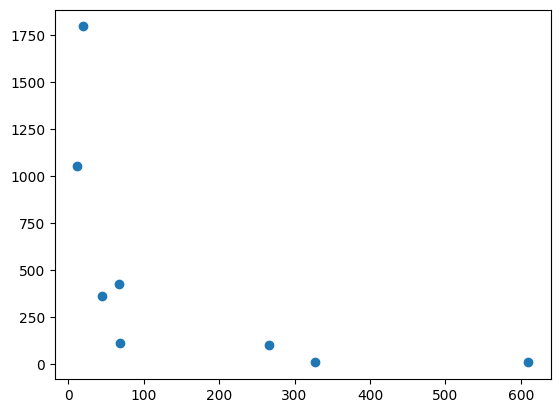

In [ ]:
plt.scatter(n_peaks, n_signals)

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
def func(x, a):
    return np.exp(-a * x)

In [ ]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

In [ ]:
popt, pcov = curve_fit(func, n_peaks, n_signals)

<ipython-input-91-6b0737a5148d>:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


In [ ]:
fig, ax = plt.subplots()
ax.scatter(n_peaks, n_signals)
ax.plot(np.linspace(1, 600, 1000), func(np.linspace(1, 600, 1000), *popt), linestyle='--', color="tab:red", label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
ax.set_xlabel("Number of spectral lines", fontsize=14)
ax.set_ylabel("Number of signals", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(n_peaks, n_signals, label="Data points")
ax.plot(np.linspace(1, 600, 1000), func(np.linspace(1, 600, 1000), *popt), linestyle='--', color="tab:red", label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
ax.set_xlabel("Number of spectral lines", fontsize=14)
ax.set_ylabel("Number of signals", fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()

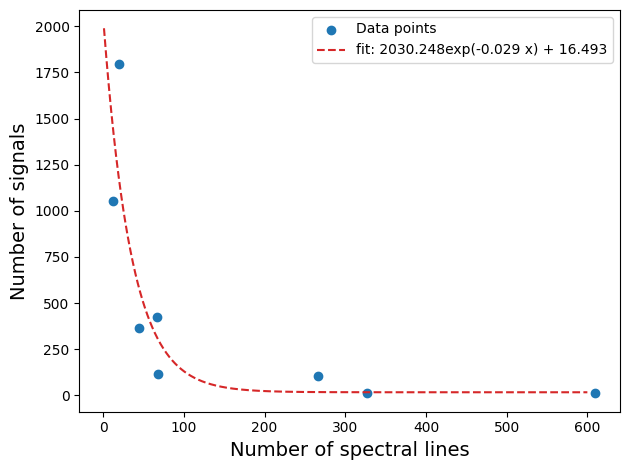

In [ ]:
fig, ax = plt.subplots()
ax.scatter(n_peaks, n_signals, label="Data points")
ax.plot(np.linspace(1, 600, 1000), func(np.linspace(1, 600, 1000), *popt), linestyle='--', color="tab:red", label='fit: %5.3fexp(-%5.3f x) + %5.3f' % tuple(popt))
ax.set_xlabel("Number of spectral lines", fontsize=14)
ax.set_ylabel("Number of signals", fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(n_signals, f(n_peaks, *popt)))

NameError: name 'f' is not defined

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(n_signals, func(n_peaks, *popt)))

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [ ]:
perr = np.sqrt(np.diag(pcov))

In [ ]:
perr

array([6.39633662e+02, 1.60352190e-02, 2.02887245e+02])

In [ ]:
np.sum((n_signals - func(n_peaks, *popt))**2)

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [ ]:
n_peaks = np.array(n_peaks)

In [ ]:
n_signals = np.array(n_signals)

In [ ]:
print(r2_score(n_signals, func(n_peaks, *popt)))

0.7758366847873022


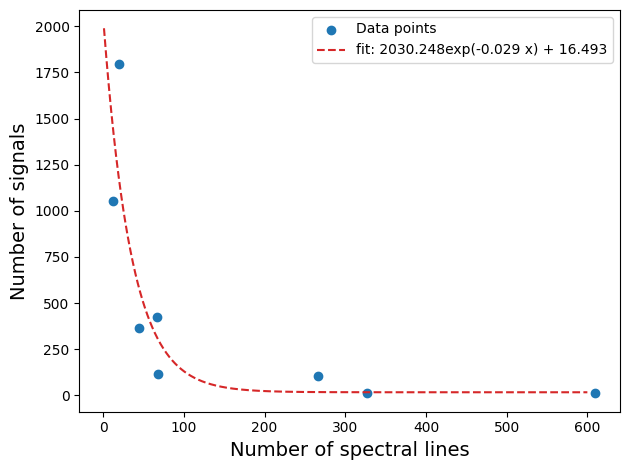

In [ ]:
fig, ax = plt.subplots()
ax.scatter(n_peaks, n_signals, label="Data points")
ax.plot(np.linspace(1, 600, 1000), func(np.linspace(1, 600, 1000), *popt), linestyle='--', color="tab:red", label='fit: %5.3fexp(-%5.3f x) + %5.3f' % tuple(popt))
ax.set_xlabel("Number of spectral lines", fontsize=14)
ax.set_ylabel("Number of signals", fontsize=14)
ax.legend()
plt.tight_layout()
plt.savefig("results/analysis/peaks_per_signal.pdf")
plt.show()

In [ ]:
for i in range(8):
    plt.scatter(n_peaks[i], n_signals[i])



In [ ]:
for i in range(8):
    print(len(cluster_composition[i]["prod"]))



0
0
0
0
1
1
8
2
